## Prediction Model for Traffic Flow in South Dublin Jan-Jun 2022
#### Firstly, we want to split the prepared dataset up into Weekdays VS Weekends, traffic congestion will vary a lot depedning on the time in the week, so it is best to treat the weekdays (the working week) differently to the weekend

In [1]:
#Importations of libraries needed:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [2]:
#Import dataset as dataframe:
df = pd.read_csv('../Datasets/TrafficFlow/prepared_FlowJanJun2022.csv')
df = df.drop('ObjectId', axis=1)
df = df.drop('Unnamed: 0', axis=1) # Remove unknown column
print("The data contains {0} rows and {1} columns".format(df.shape[0], df.shape[1]))
df.head(5)

The data contains 12704 rows and 8 columns


site day        date              start_time end_time      flow  cong  \
0  N01111A  TU  04/01/2022  2022/11/07 11:45:00+00    12:00  0.844311     2   
1  N01111A  TU  04/01/2022  2022/11/07 14:00:00+00    14:15  0.970060     2   
2  N01111A  MO  03/01/2022  2022/11/07 12:45:00+00    13:00  0.644711     2   
3  N01111A  TU  04/01/2022  2022/11/07 15:45:00+00    16:00  0.724551     2   
4  N01111A  TH  06/01/2022  2022/11/07 17:30:00+00    17:45  0.816367     4   

   dsat  
0    37  
1    39  
2    29  
3    31  
4    34

In [3]:
# Change form of start_time to match end_time
df['start_time'] = pd.to_datetime(df['start_time']).dt.strftime('%H:%M')
df.head(5)

site day        date start_time end_time      flow  cong  dsat
0  N01111A  TU  04/01/2022      11:45    12:00  0.844311     2    37
1  N01111A  TU  04/01/2022      14:00    14:15  0.970060     2    39
2  N01111A  MO  03/01/2022      12:45    13:00  0.644711     2    29
3  N01111A  TU  04/01/2022      15:45    16:00  0.724551     2    31
4  N01111A  TH  06/01/2022      17:30    17:45  0.816367     4    34

In [4]:
# Get unique values in the 'day' column
unique_days = df['day'].unique()

# Print the unique values
print(unique_days)

['TU' 'MO' 'TH' 'FR' 'WE' 'SU' 'SA']


#### Commpare congestion weekday vs weekend

In [5]:
# Filter for weekdays
df_weekday = df[df['day'].isin(['MO', 'TU', 'WE', 'TH', 'FR'])]

# Filter for weekend
df_weekend = df[df['day'].isin(['SA', 'SU'])]

# Now, df_weekday contains entries for Monday to Friday, and df_weekend contains entries for Saturday and Sunday
print(df_weekday['day'].unique())
print(df_weekend['day'].unique())

['TU' 'MO' 'TH' 'FR' 'WE']
['SU' 'SA']


In [6]:
def showDistribution(dataframe1, dataframe2):
    columns = ['flow', 'cong', 'dsat']  # The columns to plot

    for col in columns:
        plt.figure(figsize=(10, 4))
        # Plot the first DataFrame histogram
        plt.hist(dataframe1[col], bins=30, color='r', alpha=0.6, label='Weekdays')
        # Plot the second DataFrame histogram
        plt.hist(dataframe2[col], bins=30, color='b', alpha=0.6, label='Weekends')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

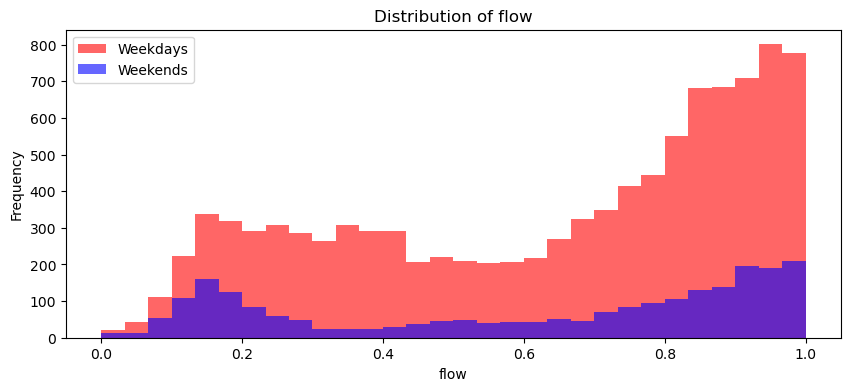

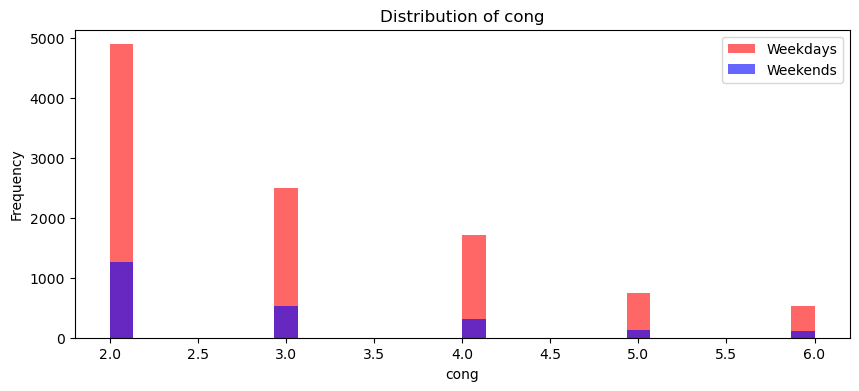

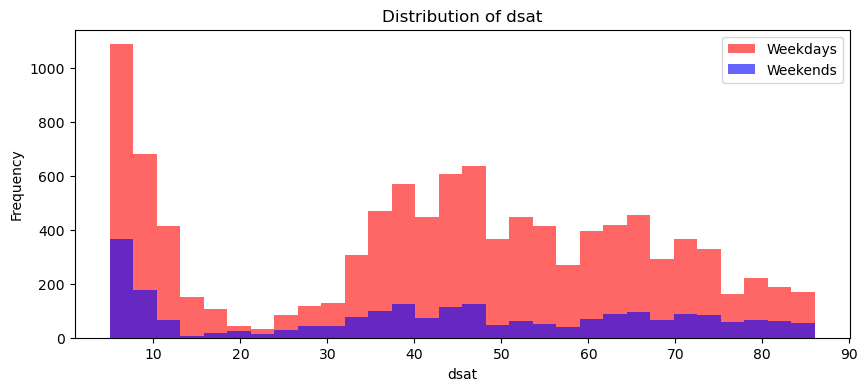

In [7]:
showDistribution(df_weekday, df_weekend)

#### Compare total `flow`, `cong` and `dsat` based on the Days

In [8]:
def showDistributionByDay(dataframe):
    columns = ['flow', 'cong', 'dsat']  # The columns to plot
    days = ['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']  # Days of the week

    for col in columns:
        plt.figure(figsize=(8, 6))
        totals = []  # Initialize an empty list to store totals for all days
        for day in days:
            # Sum the values in the current column for the current day
            total = dataframe[dataframe['day'] == day][col].sum()
            totals.append(total)
        # Plot the totals for all days for the current column
        plt.bar(days, totals, alpha=0.6)
        plt.xlabel('Day')
        plt.ylabel(f'Total {col}')
        plt.title(f'Total {col} by Day')
        plt.show()


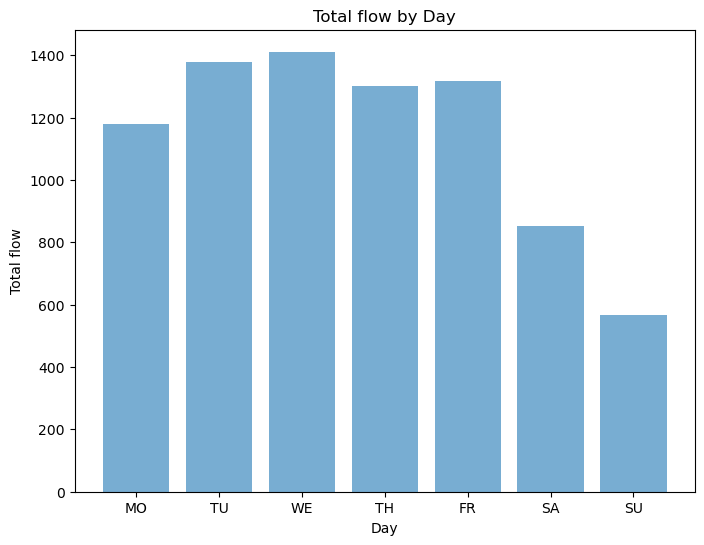

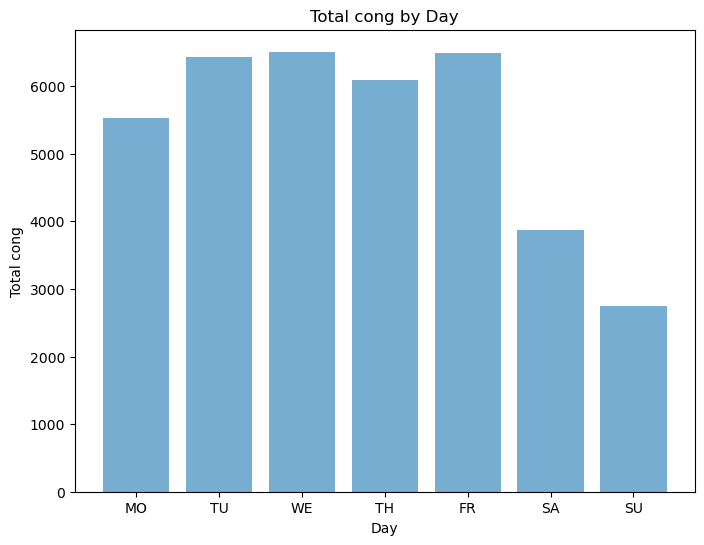

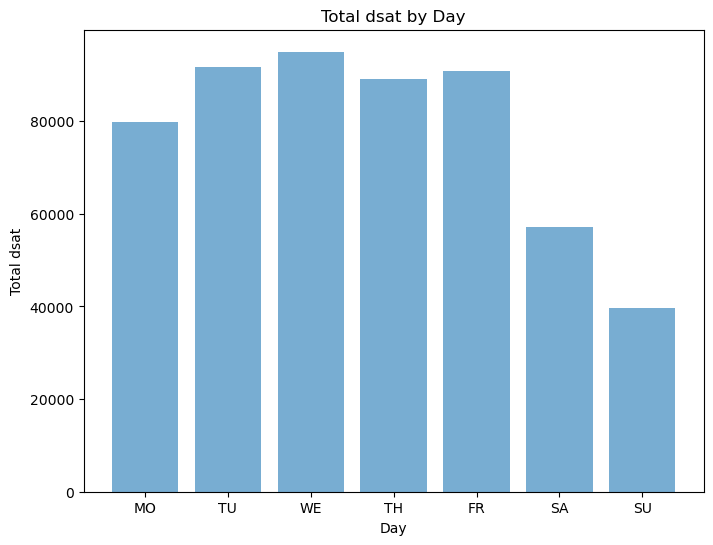

In [9]:
showDistributionByDay(df)

#### Compare total `flow`, `cong` and `dsat` based on the time

In [10]:
def showDistributionByStartTime(dataframe):
    columns = ['flow', 'cong', 'dsat']  # The columns to plot

    # Get unique start times in the order they appear in the dataframe
    unique_start_times = dataframe['start_time'].sort_values().unique()

    for col in columns:
        plt.figure(figsize=(12, 6))  # Adjusted figure size for potentially large number of unique times
        totals = []  # Initialize an empty list to store totals for each unique start time
        
        for start_time in unique_start_times:
            # Sum the values in the current column for the current start time
            total = dataframe[dataframe['start_time'] == start_time][col].sum()
            totals.append(total)
        
        # Plot the totals for each unique start time for the current column
        plt.bar(range(len(unique_start_times)), totals, alpha=0.6)
        plt.xticks(range(len(unique_start_times)), labels=unique_start_times, rotation=90)  # Rotate labels for readability
        plt.xlabel('Start Time')
        plt.ylabel(f'Total {col}')
        plt.title(f'Total {col} by Start Time')
        plt.tight_layout()  # Adjust layout to make room for label rotation
        plt.show()


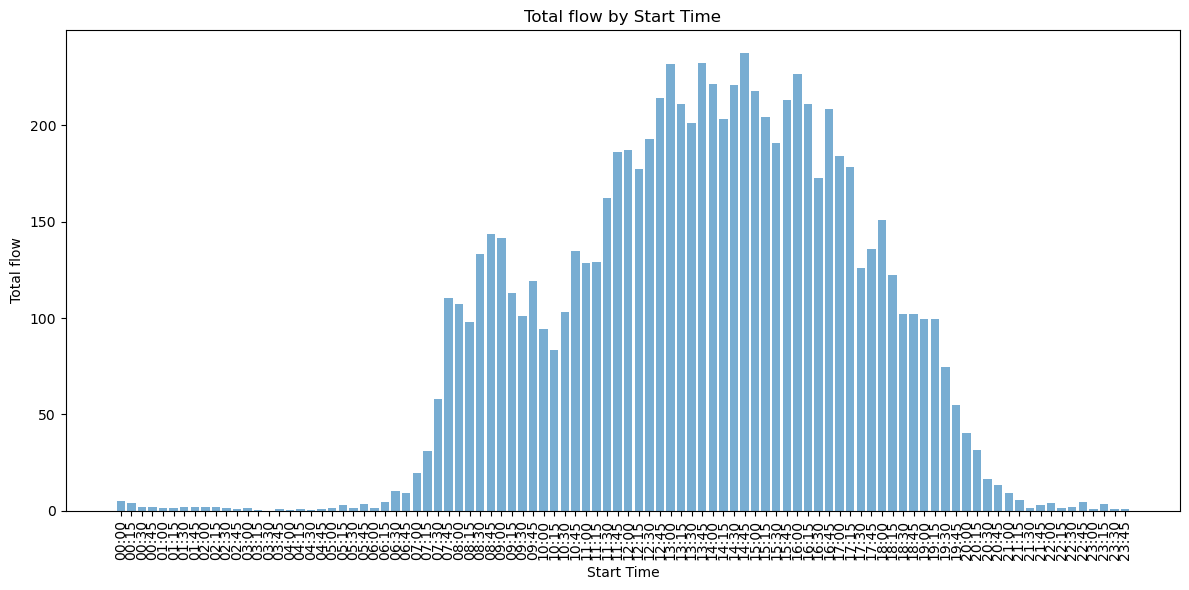

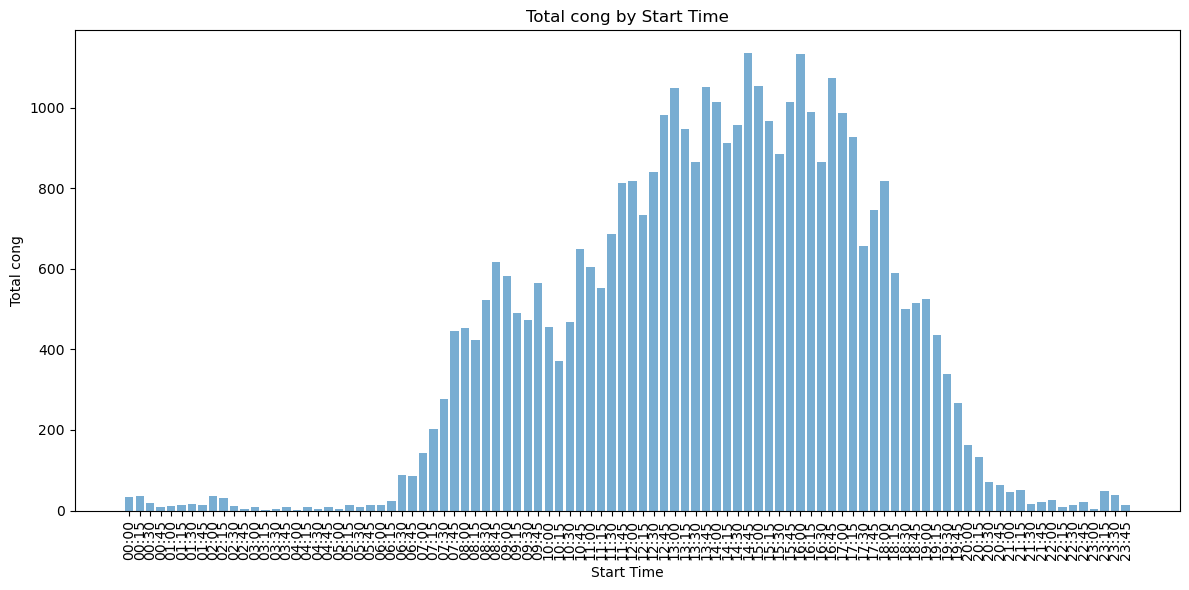

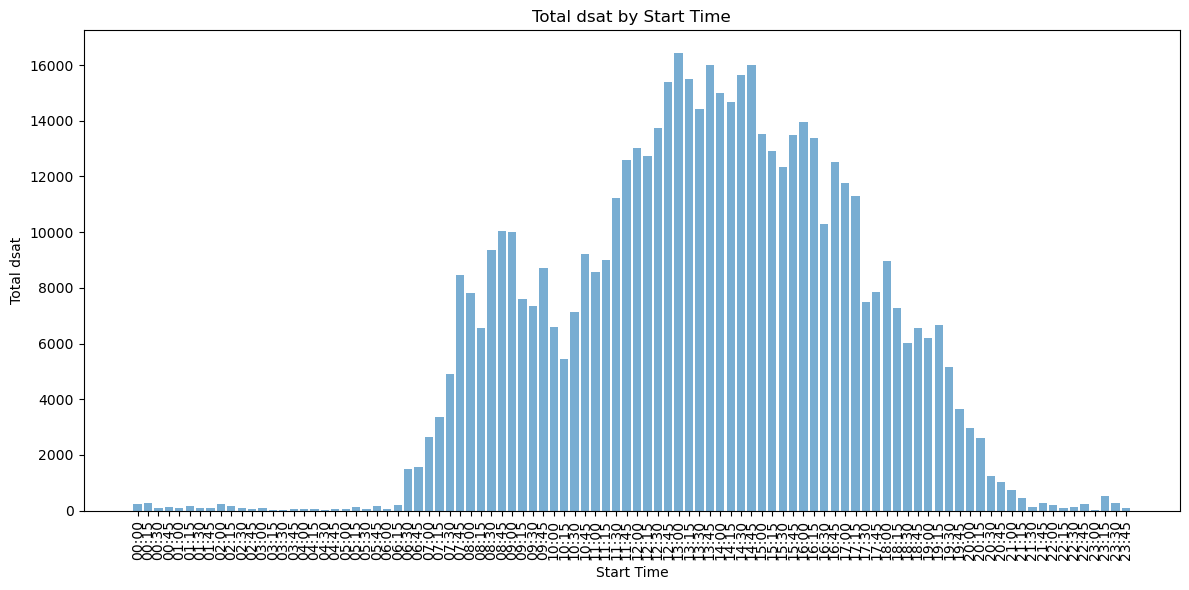

In [11]:
showDistributionByStartTime(df)

In [12]:
df_weekday.dtypes

site           object
day            object
date           object
start_time     object
end_time       object
flow          float64
cong            int64
dsat            int64
dtype: object

### Now we must reformat the data so that the formats of the data can be read by our prediction model

In [13]:
df.head(5)

site day        date start_time end_time      flow  cong  dsat
0  N01111A  TU  04/01/2022      11:45    12:00  0.844311     2    37
1  N01111A  TU  04/01/2022      14:00    14:15  0.970060     2    39
2  N01111A  MO  03/01/2022      12:45    13:00  0.644711     2    29
3  N01111A  TU  04/01/2022      15:45    16:00  0.724551     2    31
4  N01111A  TH  06/01/2022      17:30    17:45  0.816367     4    34

In [14]:
def reformatDatafram(dataframe):
    # Handle "24:00" in 'end_time'
    dataframe['end_time'] = dataframe['end_time'].replace('24:00', '00:00')

    # Convert 'date' to datetime
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%d/%m/%Y')

    # Convert 'start_time' and 'end_time' to datetime
    dataframe['start_time'] = pd.to_datetime(dataframe['start_time'], format='%H:%M')
    dataframe['end_time'] = pd.to_datetime(dataframe['end_time'], format='%H:%M')

    # Increment the date by one day where end_time is "00:00"
    dataframe.loc[dataframe['end_time'].dt.strftime('%H:%M') == '00:00', 'date'] += pd.Timedelta(days=1)

    # Extract year, month, and day as new features
    dataframe['year'] = dataframe['date'].dt.year
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['day_of_month'] = dataframe['date'].dt.day

    # Calculate duration in minutes as a new feature
    dataframe['duration'] = (dataframe['end_time'] - dataframe['start_time']).dt.total_seconds() / 60

    # Extract hour and minute from 'start_time' and 'end_time'
    dataframe['start_hour'] = dataframe['start_time'].dt.hour
    dataframe['start_minute'] = dataframe['start_time'].dt.minute
    dataframe['end_hour'] = dataframe['end_time'].dt.hour
    dataframe['end_minute'] = dataframe['end_time'].dt.minute

    # Convert 'site' and 'day' to string type
    dataframe['site'] = dataframe['site'].astype(str)
    dataframe['day'] = dataframe['day'].astype(str)

    # One-hot encode 'site' and 'day' features
    dataframe = pd.get_dummies(dataframe, columns=['site', 'day'])

    # Now drop the original 'date', 'start_time', and 'end_time' columns as they are not needed
    dataframe = dataframe.drop(['date', 'start_time', 'end_time'], axis=1)
    
    return dataframe

In [15]:
df_weekday.head(5)

site day        date start_time end_time      flow  cong  dsat
0  N01111A  TU  04/01/2022      11:45    12:00  0.844311     2    37
1  N01111A  TU  04/01/2022      14:00    14:15  0.970060     2    39
2  N01111A  MO  03/01/2022      12:45    13:00  0.644711     2    29
3  N01111A  TU  04/01/2022      15:45    16:00  0.724551     2    31
4  N01111A  TH  06/01/2022      17:30    17:45  0.816367     4    34

In [16]:
df_weekday = reformatDatafram(df_weekday)
df_weekend = reformatDatafram(df_weekend)

/var/folders/fj/1ykv5jrn7k5bplnhdvwsmzmr0000gn/T/ipykernel_4673/464071904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['end_time'] = dataframe['end_time'].replace('24:00', '00:00')
/var/folders/fj/1ykv5jrn7k5bplnhdvwsmzmr0000gn/T/ipykernel_4673/464071904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = pd.to_datetime(dataframe['date'], format='%d/%m/%Y')
/var/folders/fj/1ykv5jrn7k5bplnhdvwsmzmr0000gn/T/ipykernel_4673/464071904.py:9: SettingWithCopyWarning: 
A value is

In [17]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

# Now, when you display your DataFrame, all columns will be shown
print(df_weekday)
print(df_weekend)

           flow  cong  dsat  year  month  day_of_month  duration  start_hour  \
0      0.844311     2    37  2022      1             4      15.0          11   
1      0.970060     2    39  2022      1             4      15.0          14   
2      0.644711     2    29  2022      1             3      15.0          12   
3      0.724551     2    31  2022      1             4      15.0          15   
4      0.816367     4    34  2022      1             6      15.0          17   
...         ...   ...   ...   ...    ...           ...       ...         ...   
12699  0.321357     4    68  2022      4             1      15.0          17   
12700  0.263473     6    66  2022      3            31      15.0          18   
12701  0.343313     4    82  2022      4             6      15.0          18   
12702  0.528942     4    73  2022      4             6      15.0           9   
12703  0.538922     2    40  2022      4             6      15.0          10   

       start_minute  end_hour  end_minu

In [18]:
df_weekday.shape

(10373, 54)

In [19]:
df_weekday.head(5)

flow  cong  dsat  year  month  day_of_month  duration  start_hour  \
0  0.844311     2    37  2022      1             4      15.0          11   
1  0.970060     2    39  2022      1             4      15.0          14   
2  0.644711     2    29  2022      1             3      15.0          12   
3  0.724551     2    31  2022      1             4      15.0          15   
4  0.816367     4    34  2022      1             6      15.0          17   

   start_minute  end_hour  end_minute  site_N01111A  site_N01111C  \
0            45        12           0          True         False   
1             0        14          15          True         False   
2            45        13           0          True         False   
3            45        16           0          True         False   
4            30        17          45          True         False   

   site_N01111D  site_N01111M  site_N01111R  site_N01121E  site_N01121G  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   site_N01121H  site_N01121J  site_N01121V  site_N01131A  site_N01131B  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   site_N01131C  site_N01131F  site_N01131P  site_N01141G  site_N01151A  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   site_N01151B  site_N01151C  site_N01151J  site_N01151L  site_N02111A  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   site_N02111B  site_N02111C  site_N02111D  site_N02111K  site_N02111M  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   site_N02121E  site_N02121G  site_N02121H  site_N02131A  site_N02131C  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   site_N02131D  site_N03111B  site_N03111D  site_N03111L  site_N03121A  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         Fa

In [20]:
df_weekend.shape

(2331, 47)

In [21]:
df_weekend.head(5)

flow  cong  dsat  year  month  day_of_month  duration  start_hour  \
21  0.720559     3    30  2022      1            16      15.0          12   
22  0.888224     2    39  2022      1            16      15.0          14   
47  0.676647     4    30  2022      1            29      15.0          18   
73  0.952096     2    34  2022      2            12      15.0          12   
74  0.638723     2    29  2022      2            13      15.0          12   

    start_minute  end_hour  end_minute  site_N01111A  site_N01111C  \
21             0        12          15          True         False   
22             0        14          15          True         False   
47             0        18          15          True         False   
73             0        12          15          True         False   
74            15        12          30          True         False   

    site_N01111D  site_N01111M  site_N01121E  site_N01121G  site_N01121H  \
21         False         False         False         False         False   
22         False         False         False         False         False   
47         False         False         False         False         False   
73         False         False         False         False         False   
74         False         False         False         False         False   

    site_N01121J  site_N01121V  site_N01131A  site_N01131B  site_N01131C  \
21         False         False         False         False         False   
22         False         False         False         False         False   
47         False         False         False         False         False   
73         False         False         False         False         False   
74         False         False         False         False         False   

    site_N01131F  site_N01141G  site_N01151A  site_N01151B  site_N01151C  \
21         False         False         False         False         False   
22         False         False         False         False         False   
47         False         False         False         False         False   
73         False         False         False         False         False   
74         False         False         False         False         False   

    site_N01151J  site_N01151L  site_N02111A  site_N02111C  site_N02111D  \
21         False         False         False         False         False   
22         False         False         False         False         False   
47         False         False         False         False         False   
73         False         False         False         False         False   
74         False         False         False         False         False   

    site_N02111K  site_N02111M  site_N02121E  site_N02121G  site_N02121H  \
21         False         False         False         False         False   
22         False         False         False         False         False   
47         False         False         False         False         False   
73         False         False         False         False         False   
74         False         False         False         False         False   

    site_N02131A  site_N02131C  site_N02131D  site_N03111B  site_N03111D  \
21         False         False         False         False         False   
22         False         False         False         False         False   
47         False         False         False         False         False   
73         False         False         False         False         False   
74         False         False         False         False         False   

    site_N03111L  site_N03121A  day_SA  day_SU  
21         False         False   False    True  
22         False         False   False    True  
47         False         False    True   False  
73         False         False    True   False  
74         False         False   False    True

## Prediciton Model

Evaluation metrics are crucial for assessing the performance of regression models. Each metric offers unique insights but also comes with its own set of advantages and disadvantages. Let's go through the metrics you've mentioned:

#### 1. MAE (Mean Absolute Error)
**Advantages:**
- **Interpretability:** The MAE is measured in the same units as the data, making it easy to understand and interpret.
- **Robustness:** It is less sensitive to outliers compared to MSE, as it treats all errors linearly.

**Disadvantages:**
- **Scale Dependency:** The MAE can vary significantly with the scale of the data, making it hard to compare across different datasets.
- **Lack of Sensitivity to Small Errors:** Because all errors are treated equally, it might not reflect well on the performance of the model when small errors are critical to the application.

#### 2. MSE (Mean Squared Error)
**Advantages:**
- **Sensitivity to Large Errors:** The squaring of errors penalizes large errors more than smaller ones, which can be beneficial in many applications where large errors are particularly undesirable.
- **Differentiability:** The MSE function is continuously differentiable, making it more suitable for optimization using gradient descent.

**Disadvantages:**
- **Impact of Outliers:** Due to squaring, outliers have a more pronounced effect on MSE, potentially skewing the model evaluation.
- **Scale Dependency:** Like MAE, the MSE is dependent on the scale of the data, making comparisons across datasets difficult. Additionally, the units of MSE are squared, making interpretation less intuitive.

#### 3. RMSE (Root Mean Squared Error)
**Advantages:**
- **Interpretability:** Taking the square root of MSE makes the scale similar to the original data, improving interpretability compared to MSE.
- **Sensitivity to Large Errors:** Like MSE, RMSE is more sensitive to large errors, making it useful for emphasizing significant errors.

**Disadvantages:**
- **Outlier Sensitivity:** RMSE retains MSE's sensitivity to outliers, which can disproportionately affect the model evaluation.
- **Scale Dependency:** RMSE is still scale-dependent and can vary with the data's scale.

#### 4. R² (R-Squared)
**Advantages:**
- **Interpretability:** R² provides a measure of how well future samples are likely to be predicted by the model. It's expressed as a percentage, making it intuitive.
- **Scale Independence:** R² is scale-independent, making it useful for comparing models across different datasets.

**Disadvantages:**
- **Non-linearity Sensitivity:** R² assumes a linear relationship between predictors and response, which can be misleading for models that don't meet this assumption.
- **No Insight on Error Magnitude:** R² doesn't convey the size of errors directly, so a high R² model can still have large predictive errors.

#### 5. MAPE (Mean Absolute Percentage Error)
**Advantages:**
- **Scale Independence:** MAPE is expressed as a percentage, making it scale-independent and suitable for comparing models across different scales.
- **Interpretability:** It directly measures the average percentage error, making it intuitive for understanding model accuracy in terms of relative error.

**Disadvantages:**
- **Undefined for Zero Values:** MAPE becomes undefined or infinitely large when the actual values include zeros, making it unsuitable for datasets with zero or near-zero values.
- **Disproportionate Impact of Small Errors:** Small actual values lead to disproportionately large errors, potentially skewing the evaluation.

In [22]:
def get_location_from_scn(input_string, scn_to_locn_mapping):
    for scn in scn_to_locn_mapping.keys():
        if scn in input_string:
            return scn_to_locn_mapping[scn]
    return input_string


In [23]:
scn_to_locn_mapping = {
    'N01111': 'Airton GrHill',
    'N01121': 'Mayberry GrHill',
    'N01131': 'Tymon North',
    'N01141': 'Cuckoos Nest',
    'N01151': 'Harvey GrHills',
    'N02111': 'OB Rd Old Court',
    'N02121': 'Kiltipper',
    'N02131': 'Firhouse Rd W',
    'N03111': 'ORR Lucan Road',
    'N03121': 'N4 Off Ramp EB',
    'N03131': 'ORR-Hermitage',
    'N03141': 'ORR-Ballyowen',
    'N04111': 'N4 OVAL',
    'N04121': 'N4-Kennelsfort',
    'N05111': 'Old Belgard/Emb',
    'N05121': 'Belgard/Embank',
    'N05131': 'BelgrdCookstown',
    'N05141': 'Belgrd/Mayberry',
    'N06111': 'Embank/Sylvan',
    'N07111': 'M50 I/C East SB',
    'N07112': 'FL L/T to M50',
    'N07113': 'M50 FL L/T O/R',
    'N07121': 'M50 I/C West NB',
    'N07122': 'FI-LT to M50 NB',
    'N08111': 'Killyninny Junc',
    'N08112': 'N4-Newcastle SO',
    'N08113': 'hillcrest junc',
    'N08114': 'hillcrest Remote',
    'N13111': 'T376-Castleside',
    'N13121': 'P488 Castle STO',
    'N13122': 'P488 Castle ST1',
    'N13131': 'T380-Butter STO',
    'N13132': 'T380-Butt ST1',
    'N13141': 'T337b-Yellow Hs',
    'N13151': 'T338-Nutgrove',
    'N25191': 'FIRHOUSE-MORTON',
    'N25211': 'Firehouse-Delfor'
}

# Weekdays (Mon-Fri)

In [24]:
sites_columns = [col for col in df_weekday.columns if col.startswith('site_')]
# Now, `sites_columns` is a list of column names that start with 'site_'
for index, site in enumerate(sites_columns):
    print(f"Index: {index}, Site Column: {site}")

Index: 0, Site Column: site_N01111A
Index: 1, Site Column: site_N01111C
Index: 2, Site Column: site_N01111D
Index: 3, Site Column: site_N01111M
Index: 4, Site Column: site_N01111R
Index: 5, Site Column: site_N01121E
Index: 6, Site Column: site_N01121G
Index: 7, Site Column: site_N01121H
Index: 8, Site Column: site_N01121J
Index: 9, Site Column: site_N01121V
Index: 10, Site Column: site_N01131A
Index: 11, Site Column: site_N01131B
Index: 12, Site Column: site_N01131C
Index: 13, Site Column: site_N01131F
Index: 14, Site Column: site_N01131P
Index: 15, Site Column: site_N01141G
Index: 16, Site Column: site_N01151A
Index: 17, Site Column: site_N01151B
Index: 18, Site Column: site_N01151C
Index: 19, Site Column: site_N01151J
Index: 20, Site Column: site_N01151L
Index: 21, Site Column: site_N02111A
Index: 22, Site Column: site_N02111B
Index: 23, Site Column: site_N02111C
Index: 24, Site Column: site_N02111D
Index: 25, Site Column: site_N02111K
Index: 26, Site Column: site_N02111M
Index: 27, 

### ML Model

In [25]:
# Prediction Model

# Normalize all features except 'start_hour'
columns_to_normalize = df_weekday.columns.difference(['flow'])
X_to_normalize = df_weekday[columns_to_normalize]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_to_normalize)
X_normalized_df = pd.DataFrame(X_normalized, columns=columns_to_normalize, index=df_weekday.index)

# Add 'start_hour' back to the features without normalization
X_normalized_df['start_hour'] = df_weekday['start_hour'] 

X_normalized_df = X_normalized_df.drop(columns=['cong', 'dsat'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized_df, df_weekday[['flow']], test_size=0.2, random_state=23) #removed cong and dsat from this

# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to create and evaluate the model, now including 'start_hour' in training
def train_and_evaluate_model(neurons, lr, activation):
    model = Sequential([
        LSTM(neurons, activation=activation, input_shape=(1, X_train.shape[1])),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    # Fit model
    model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_test_reshaped, y_test), batch_size=32, verbose=0)
    
    # Predict on test set
    predictions = model.predict(X_test_reshaped)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print(f"MAE:{mae} || RMSE:{rmse} || MSE:{mse} || R2:{r2} || MAPE:{mape} || Model: {model}")
    print("==========================================================================")

    return mae, mse, rmse, r2, mape, model

# Parameters for model training
neurons = [10, 50, 100]
learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['relu', 'tanh', 'sigmoid']

# Store results
results = []

# Iterate over parameter combinations
for neuron in neurons:
    for lr in learning_rates:
        for activation in activation_functions:
            mae, mse, rmse, r2, mape, trained_model = train_and_evaluate_model(neuron, lr, activation)
            results.append({
                'neurons': neuron,
                'learning_rate': lr,
                'activation': activation,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape,
                'model': trained_model
            })

# Find the best model configuration
best_result = sorted(results, key=lambda x: x['MAE'])[0]
best_model = best_result['model']

# Predict on reshaped test set with the best model
predictions = best_model.predict(X_test_reshaped)

print("Best configuration:", best_result)


65/65 [==============================] - 0s 383us/step


MAE:0.08070683892137506 || RMSE:0.10675546297563585 || MSE:0.011396728875142356 || R2:0.8614009766293931 || MAPE:22.50192486696625 || Model: <keras.src.engine.sequential.Sequential object at 0x29317ae50>
65/65 [==============================] - 0s 352us/step


MAE:0.080628258474233 || RMSE:0.1064812438456996 || MSE:0.01133825529092734 || R2:0.8621120913495877 || MAPE:24.92370565636282 || Model: <keras.src.engine.sequential.Sequential object at 0x294e44bd0>
65/65 [==============================] - 0s 377us/step


MAE:0.08239068184377707 || RMSE:0.10888048257879337 || MSE:0.011854959486590927 || R2:0.8558282973175415 || MAPE:23.51984967107981 || Model: <keras.src.engine.sequential.Sequential object at 0x2936a5190>
65/65 [==============================] - 0s 336us/step


MAE:0.07597485761957172 || RMSE:0.10326199679242656 || MSE:0.010663039981559114 || R2:0.8703235863731673 || MAPE:20.56309072911127 || Model: <keras.src.engine.sequential.Sequential object at 0x29a6c5ad0>
65/65 [==============================] - 0s 354us/step


MAE:0.07354077589088162 || RMSE:0.09885715947164071 || MSE:0.009772737978801403 || R2:0.8811508149085634 || MAPE:19.904217065173473 || Model: <keras.src.engine.sequential.Sequential object at 0x294fd3f10>
65/65 [==============================] - 0s 336us/step


MAE:0.07632850775863777 || RMSE:0.10250997051612759 || MSE:0.01050829405521735 || R2:0.872205497796745 || MAPE:19.665135237962186 || Model: <keras.src.engine.sequential.Sequential object at 0x29e254750>
65/65 [==============================] - 0s 405us/step


MAE:0.10309517273769186 || RMSE:0.1389841253650968 || MSE:0.01931658710350094 || R2:0.765085215527245 || MAPE:33.03042346957976 || Model: <keras.src.engine.sequential.Sequential object at 0x29ff9fb90>
65/65 [==============================] - 0s 352us/step


MAE:0.08193764439985537 || RMSE:0.11142410558000689 || MSE:0.01241533130430452 || R2:0.8490134482928431 || MAPE:22.586319963477322 || Model: <keras.src.engine.sequential.Sequential object at 0x2a0080dd0>
65/65 [==============================] - 0s 347us/step


MAE:0.09267890579448251 || RMSE:0.12002278456997563 || MSE:0.01440546881593078 || R2:0.8248107916791343 || MAPE:23.944789897249528 || Model: <keras.src.engine.sequential.Sequential object at 0x2a36fa7d0>
65/65 [==============================] - 0s 351us/step


MAE:0.07832927388813413 || RMSE:0.10731379341062397 || MSE:0.011516250256178081 || R2:0.8599474414207431 || MAPE:21.446618320522084 || Model: <keras.src.engine.sequential.Sequential object at 0x2a3cd6850>
65/65 [==============================] - 0s 364us/step


MAE:0.0777776642579468 || RMSE:0.10480028079519382 || MSE:0.010983098854751471 || R2:0.8664312548338682 || MAPE:21.44310651475452 || Model: <keras.src.engine.sequential.Sequential object at 0x2a0537610>
65/65 [==============================] - 0s 349us/step


MAE:0.082904977164006 || RMSE:0.10925525673295834 || MSE:0.011936711123784638 || R2:0.8548340912433134 || MAPE:24.400159065609145 || Model: <keras.src.engine.sequential.Sequential object at 0x2a8c03a50>
65/65 [==============================] - 0s 352us/step


MAE:0.08380514290816536 || RMSE:0.1154262208069119 || MSE:0.013323212449765979 || R2:0.8379724345531901 || MAPE:22.925471007962496 || Model: <keras.src.engine.sequential.Sequential object at 0x2cd7d4e50>
65/65 [==============================] - 0s 375us/step


MAE:0.07432733505791556 || RMSE:0.10057015338505915 || MSE:0.010114355751894325 || R2:0.876996299149222 || MAPE:19.498422852166826 || Model: <keras.src.engine.sequential.Sequential object at 0x2ce58b710>
65/65 [==============================] - 0s 371us/step


MAE:0.07500950259084789 || RMSE:0.1008538239864251 || MSE:0.010171493812684815 || R2:0.8763014261282339 || MAPE:19.691887700078695 || Model: <keras.src.engine.sequential.Sequential object at 0x2cfa7e510>
65/65 [==============================] - 0s 367us/step


MAE:0.24955420704610135 || RMSE:0.28924211833970354 || MSE:0.08366100302163908 || R2:-0.01742644227462442 || MAPE:95.9293258790449 || Model: <keras.src.engine.sequential.Sequential object at 0x2ce56d310>
65/65 [==============================] - 0s 388us/step


MAE:0.09302286936375433 || RMSE:0.1202591183402337 || MSE:0.014462255543970334 || R2:0.8241201913206524 || MAPE:24.79407796788723 || Model: <keras.src.engine.sequential.Sequential object at 0x2d48ad210>
65/65 [==============================] - 0s 391us/step


MAE:0.1119417543912676 || RMSE:0.13962705083991037 || MSE:0.019495713326250913 || R2:0.7629068080381134 || MAPE:21.329723341501797 || Model: <keras.src.engine.sequential.Sequential object at 0x2a9141dd0>
65/65 [==============================] - 0s 393us/step


MAE:0.07715876516731542 || RMSE:0.101484637086495 || MSE:0.010299131564577594 || R2:0.8747491853097177 || MAPE:21.703852669640966 || Model: <keras.src.engine.sequential.Sequential object at 0x2d4963710>
65/65 [==============================] - 0s 416us/step


MAE:0.07903527635694056 || RMSE:0.10521549230704969 || MSE:0.011070299821414832 || R2:0.8653707778365716 || MAPE:22.643283103453214 || Model: <keras.src.engine.sequential.Sequential object at 0x2d4180710>
65/65 [==============================] - 0s 408us/step


MAE:0.08470403177089837 || RMSE:0.11186398722334201 || MSE:0.012513551637504023 || R2:0.847818961488276 || MAPE:25.69716662361306 || Model: <keras.src.engine.sequential.Sequential object at 0x2dba1d310>
65/65 [==============================] - 0s 389us/step


MAE:0.07837248773887079 || RMSE:0.12294785068760654 || MSE:0.01511617398870199 || R2:0.8161676938280154 || MAPE:22.194452341979872 || Model: <keras.src.engine.sequential.Sequential object at 0x2ddab4710>
65/65 [==============================] - 0s 399us/step


MAE:0.07616943384697264 || RMSE:0.10297028522322602 || MSE:0.010602879638952518 || R2:0.8710552142658956 || MAPE:19.547296322810652 || Model: <keras.src.engine.sequential.Sequential object at 0x2dfe776d0>
65/65 [==============================] - 0s 399us/step


MAE:0.07533270557214035 || RMSE:0.10362709757458712 || MSE:0.010738575351732999 || R2:0.8694049781785939 || MAPE:19.130011814505977 || Model: <keras.src.engine.sequential.Sequential object at 0x2e2a0e190>
65/65 [==============================] - 0s 391us/step


MAE:0.09511013168035051 || RMSE:0.12706576212265072 || MSE:0.01614570790381006 || R2:0.8036472244262973 || MAPE:34.410108519414806 || Model: <keras.src.engine.sequential.Sequential object at 0x2e40bef50>
65/65 [==============================] - 0s 448us/step


MAE:0.08777025450313171 || RMSE:0.11534339803031123 || MSE:0.013304099469178805 || R2:0.8382048732180127 || MAPE:24.36493009607475 || Model: <keras.src.engine.sequential.Sequential object at 0x2e18e0650>
65/65 [==============================] - 0s 401us/step
MAE:0.07839525873924269 || RMSE:0.10520575155365228 || MSE:0.011068250159968809 || R2:0.8653957043815277 || MAPE:23.193386398261158 || Model: <keras.src.engine.sequential.Sequential object at 0x2e2a6cc50>
65/65 [==============================] - 0s 321us/step
Best configuration: {'neurons': 10, 'learning_rate': 0.01, 'activation': 'tanh', 'MAE': 0.07354077589088162, 'MSE': 0.009772737978801403, 'RMSE': 0.09885715947164071, 'R2': 0.8811508149085634, 'MAPE': 19.904217065173473, 'model': <keras.src.engine.sequential.Sequential object at 0x294fd3f10>}


### Display Results

#### `Flow`

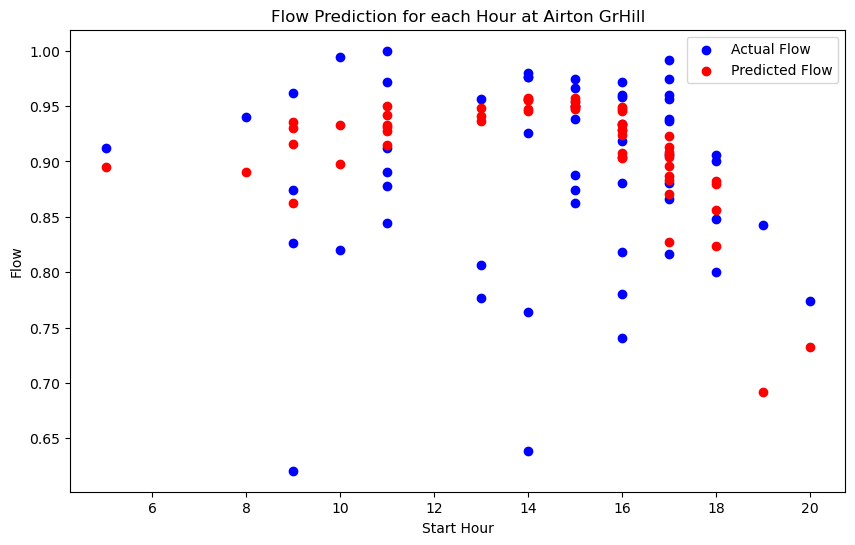

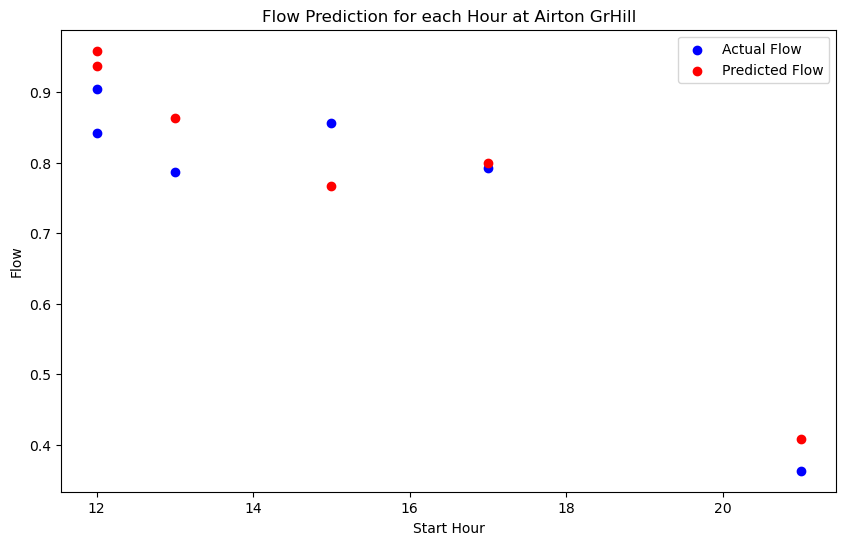

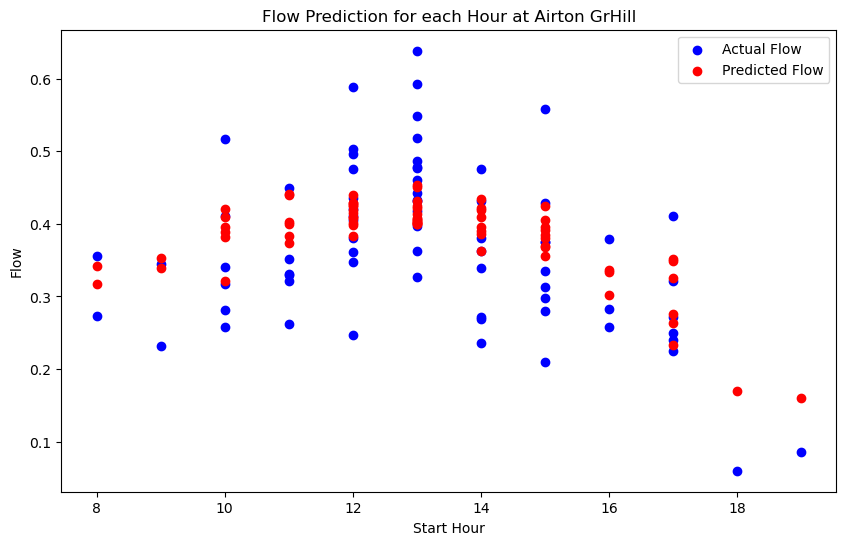

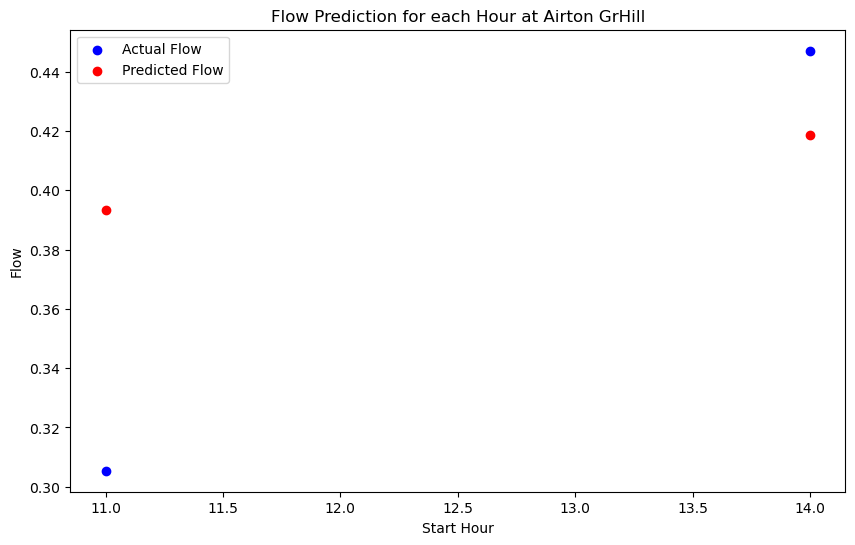

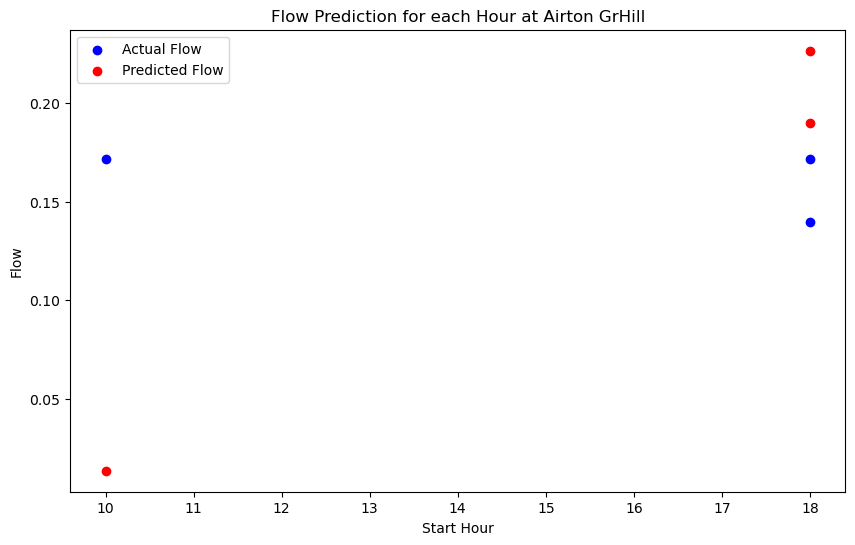

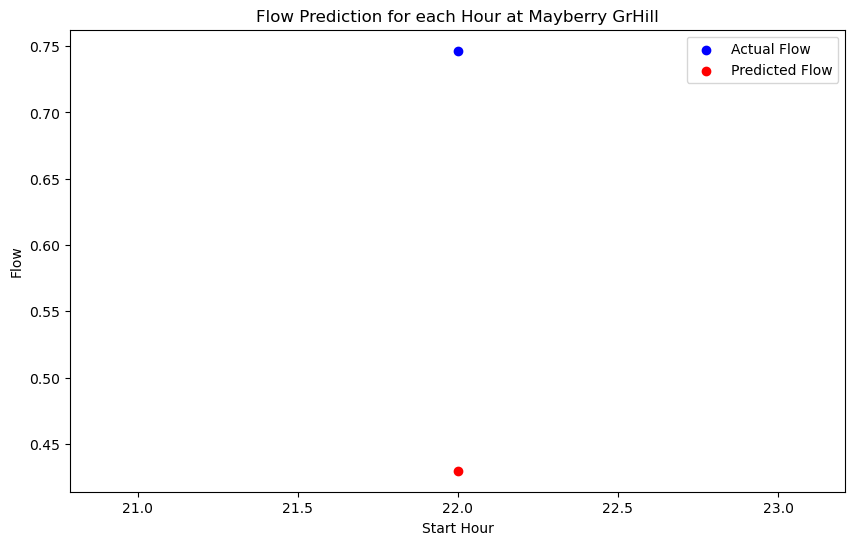

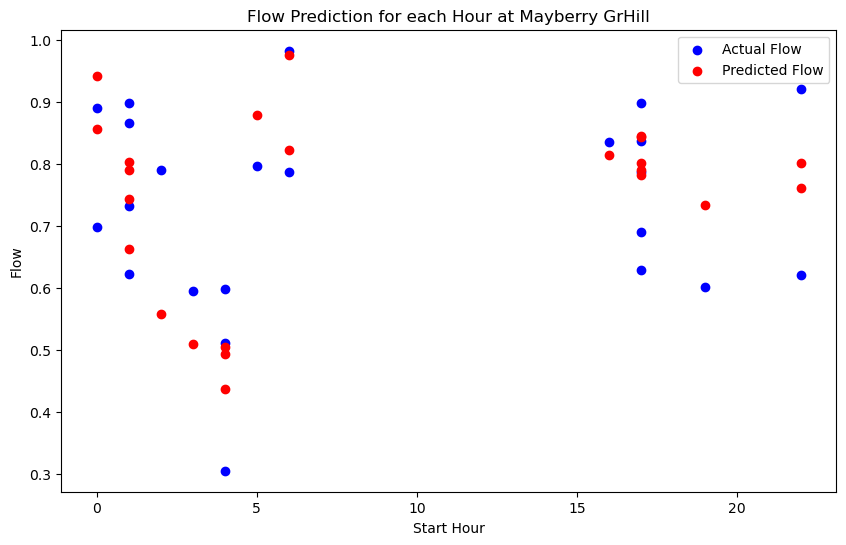

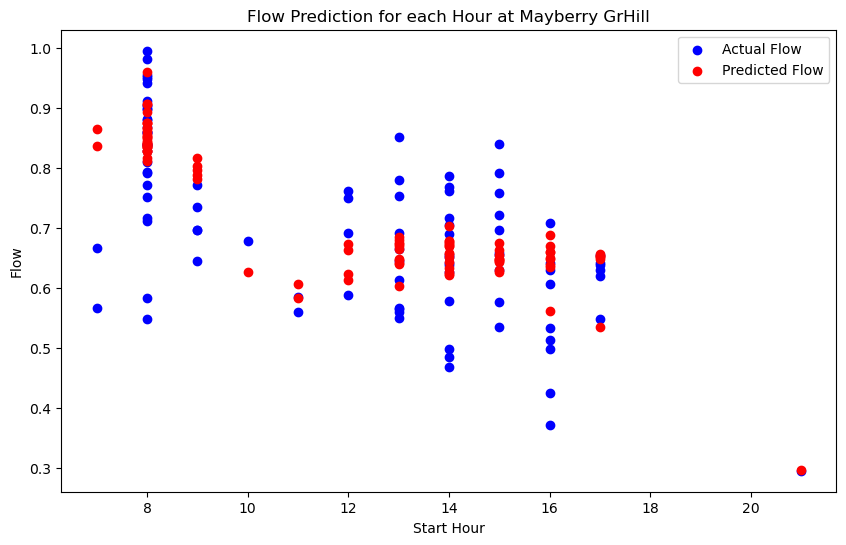

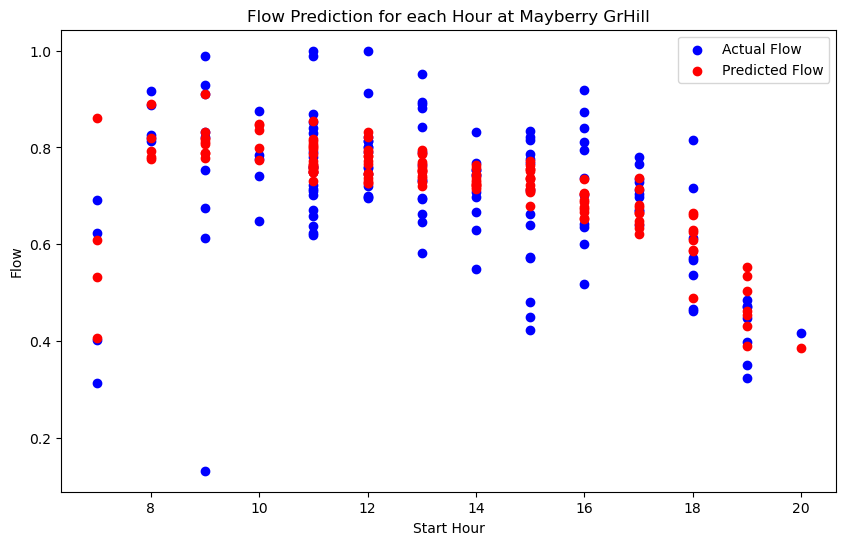

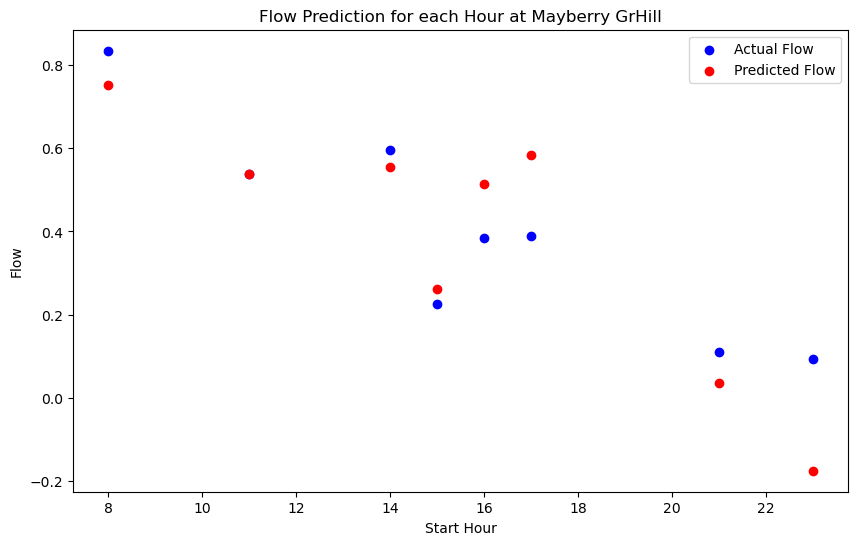

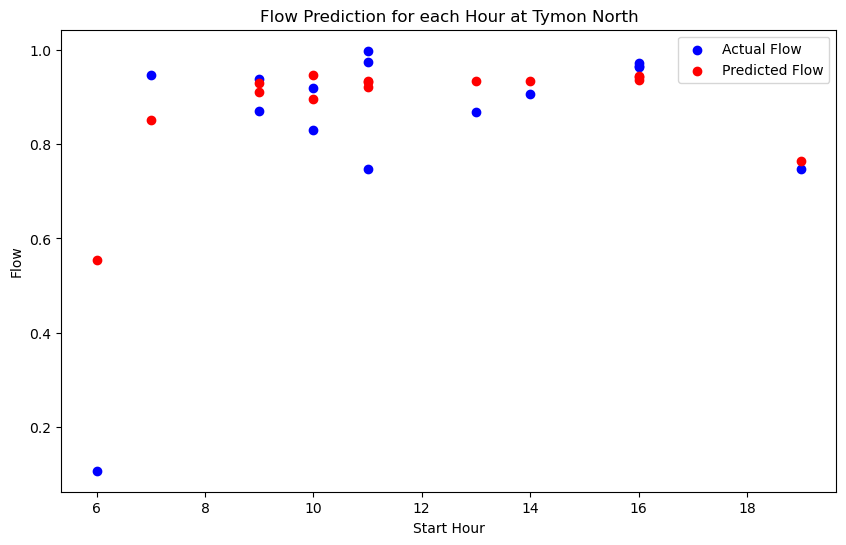

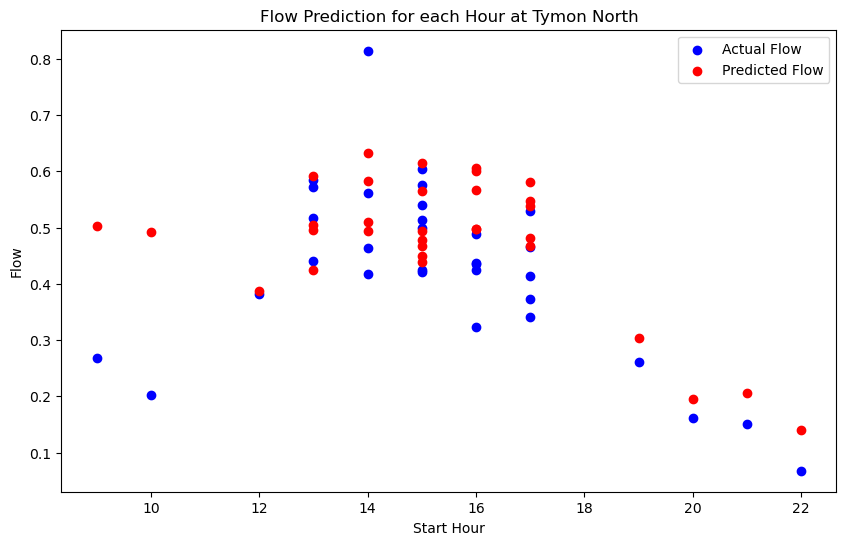

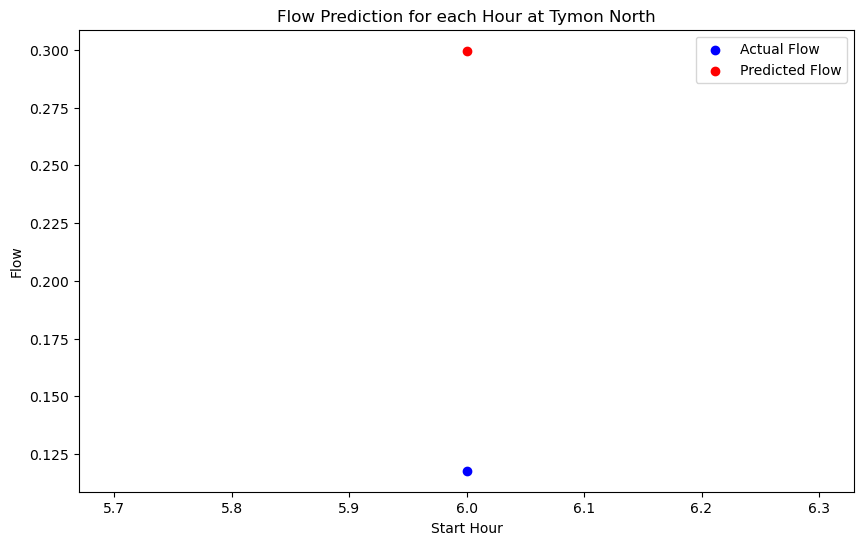

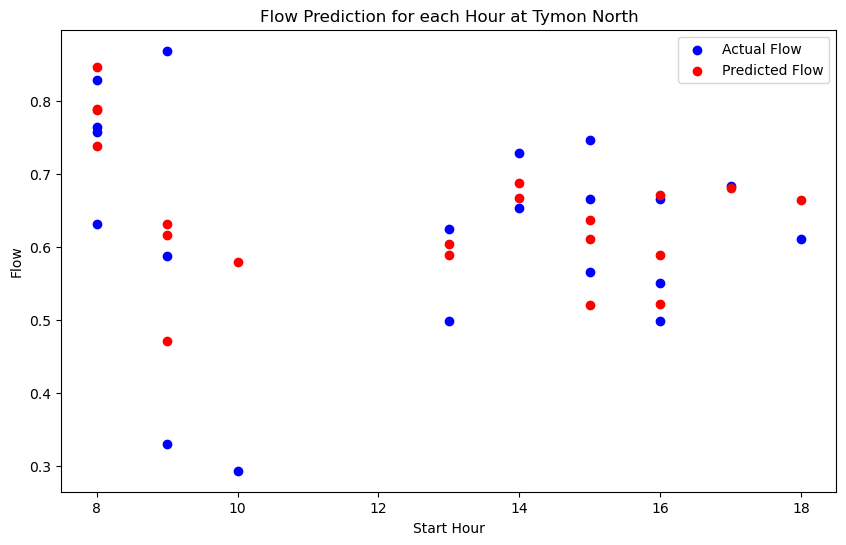

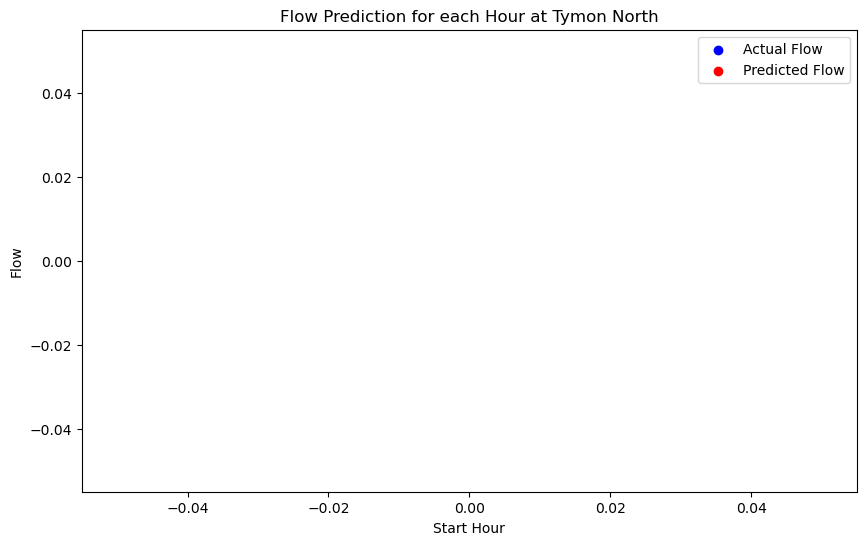

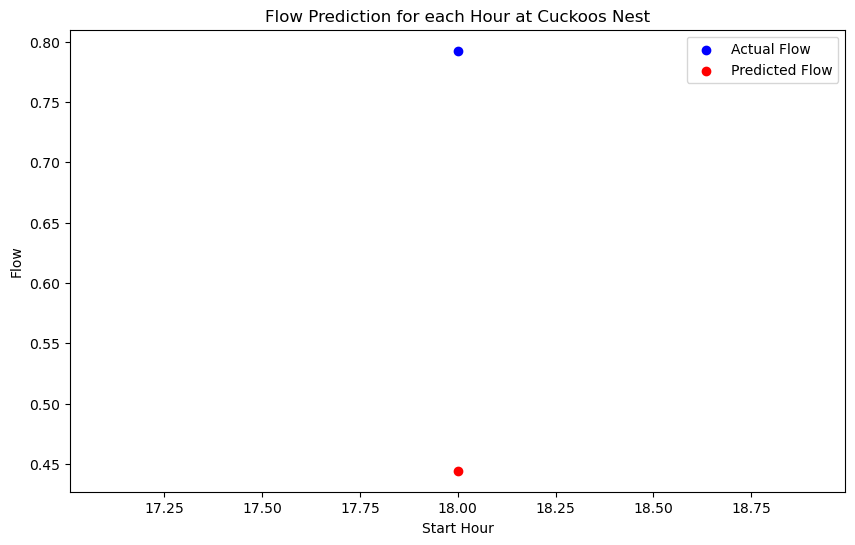

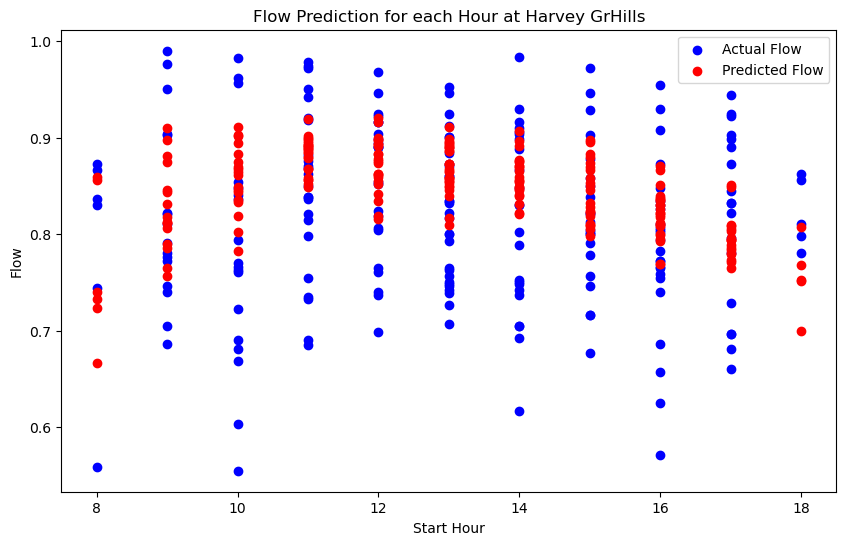

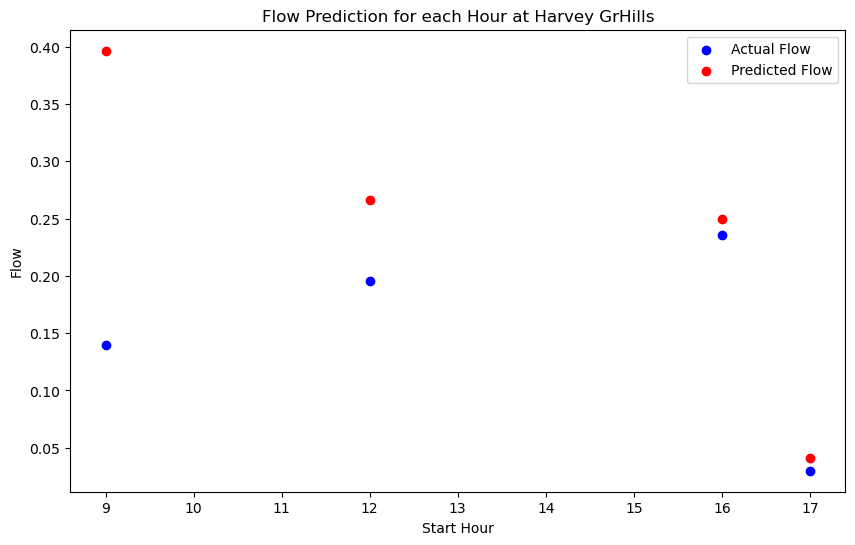

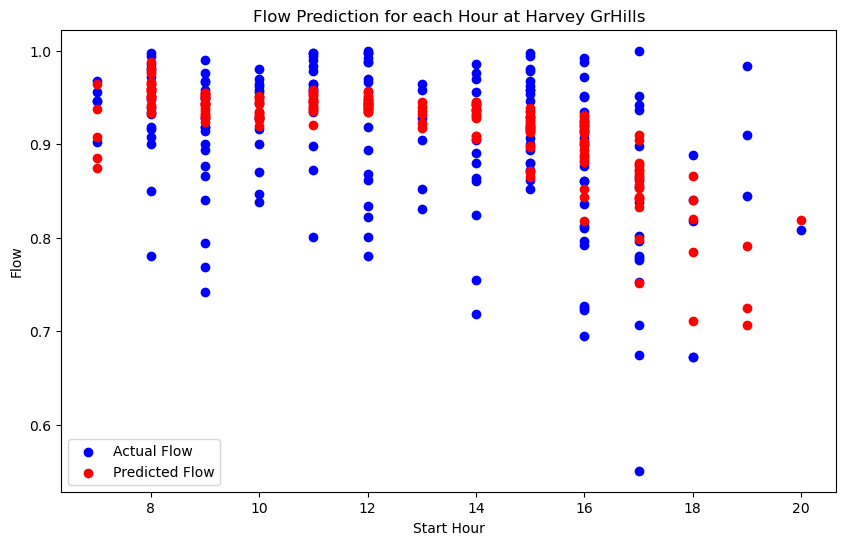

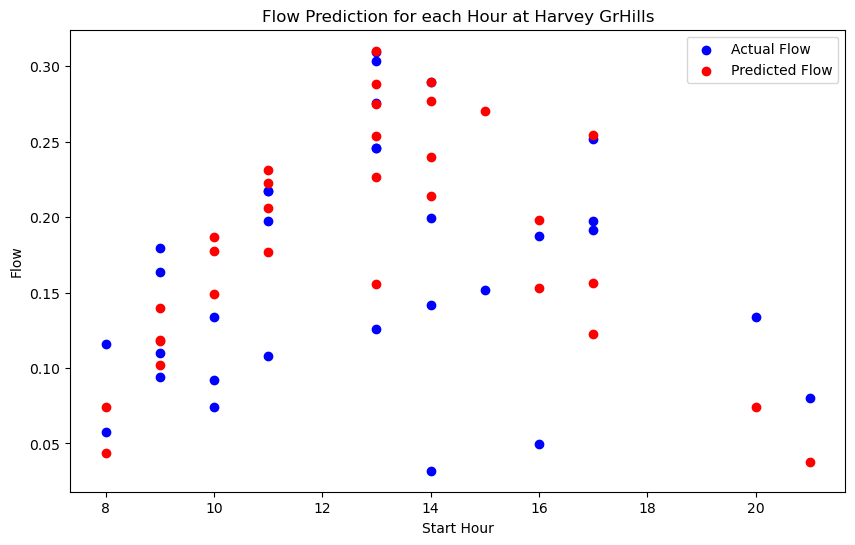

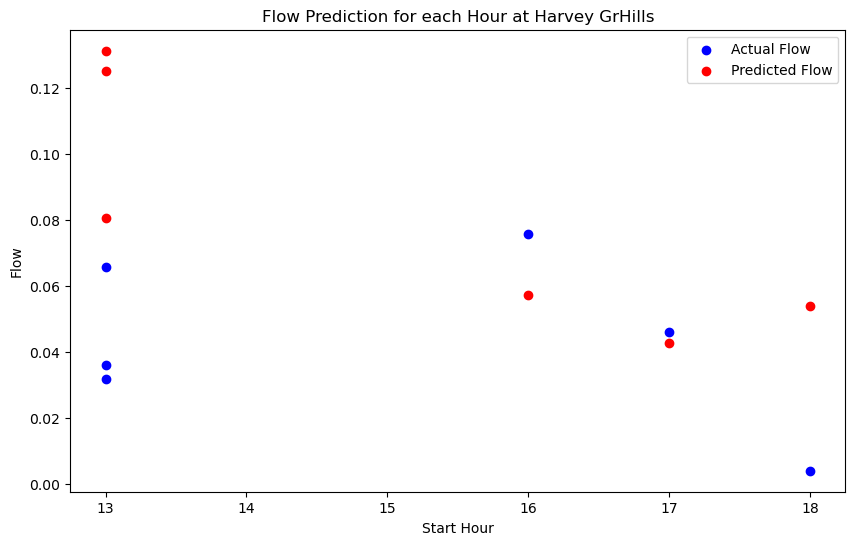

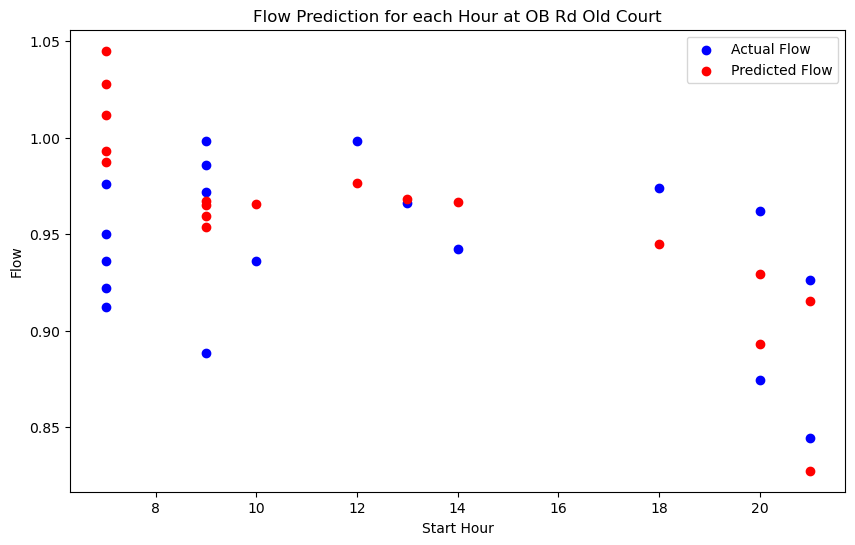

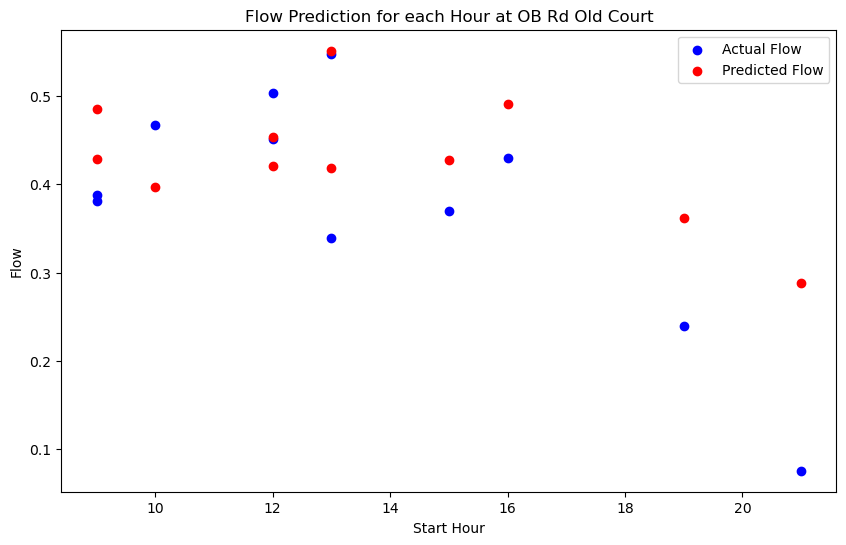

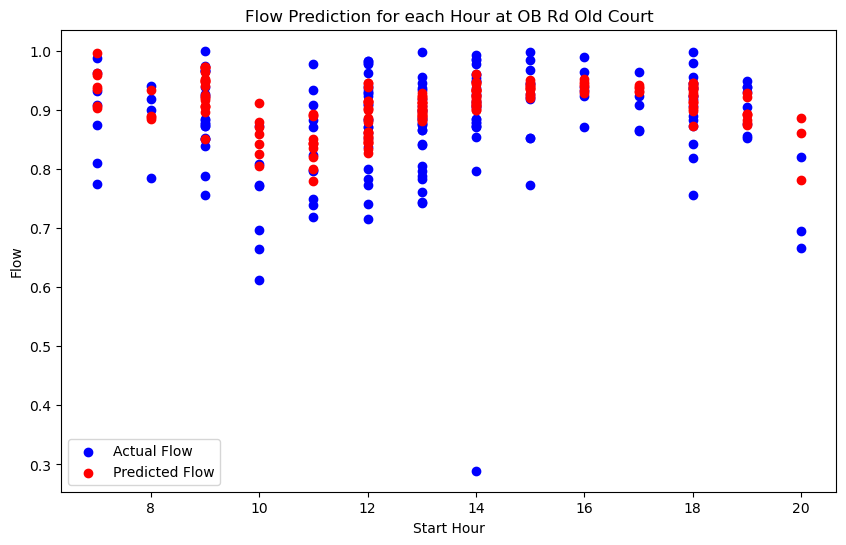

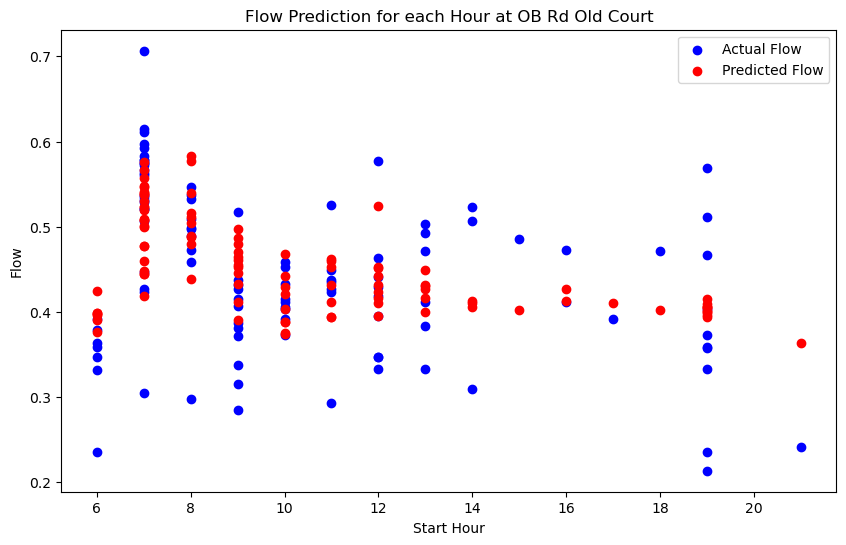

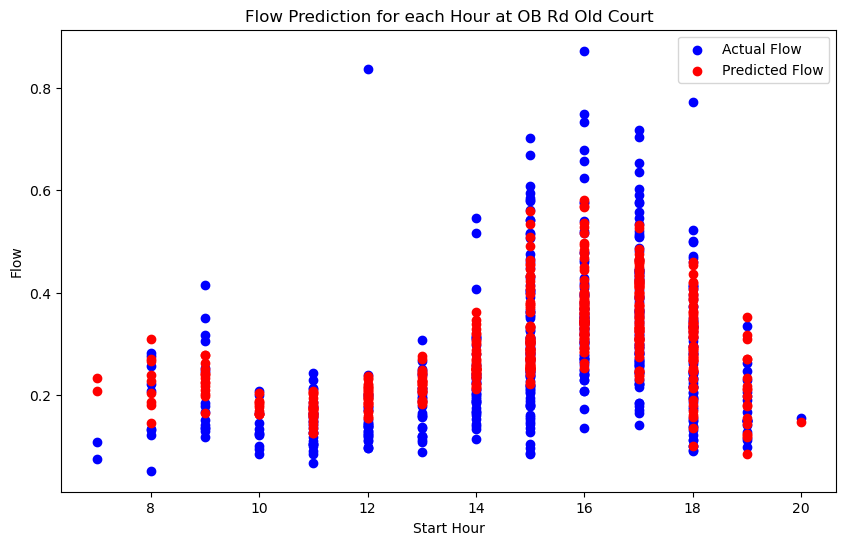

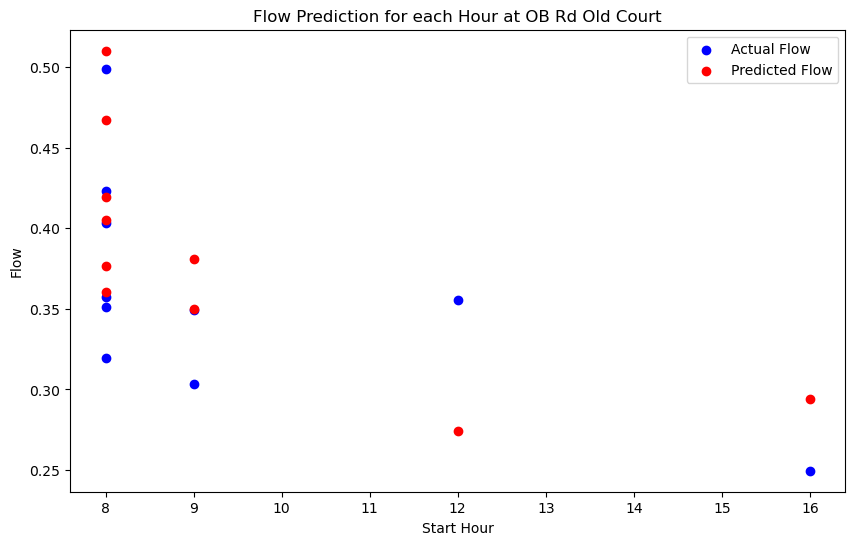

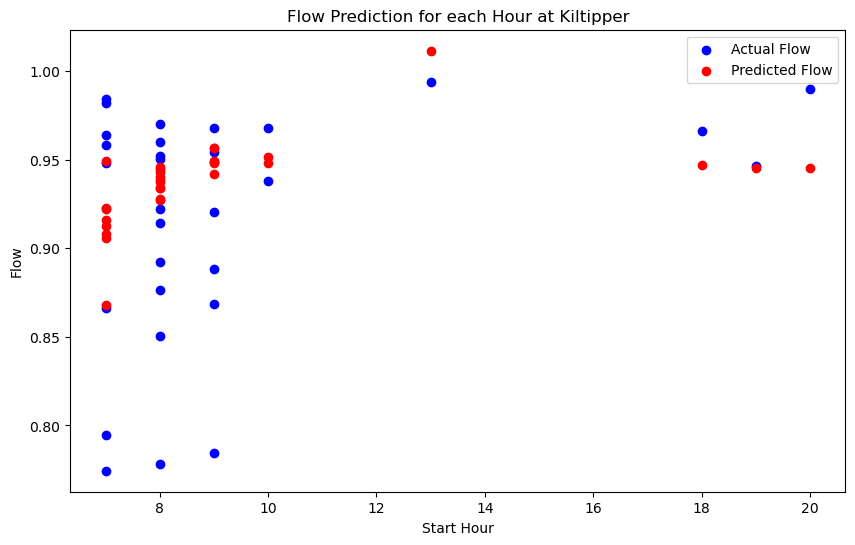

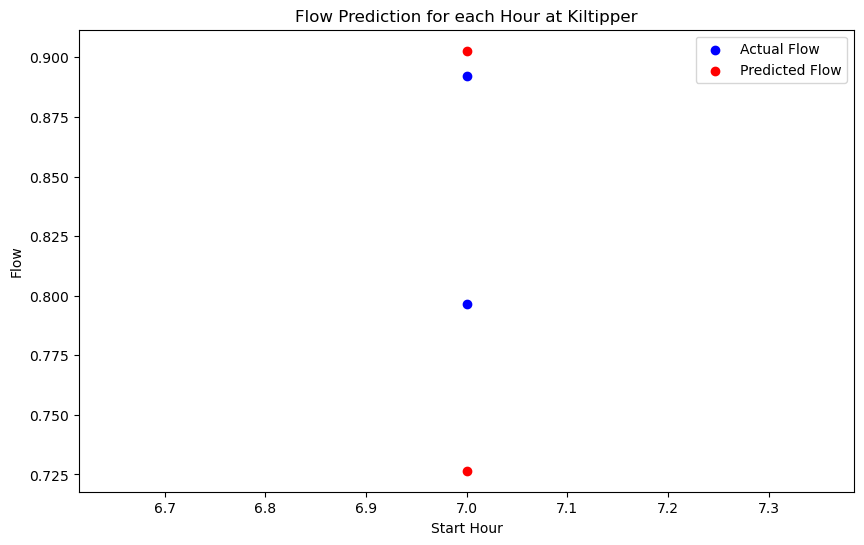

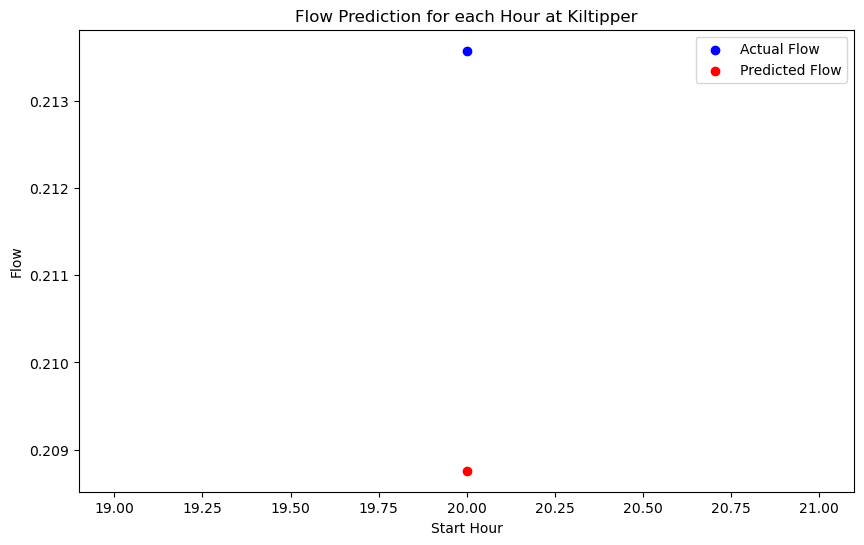

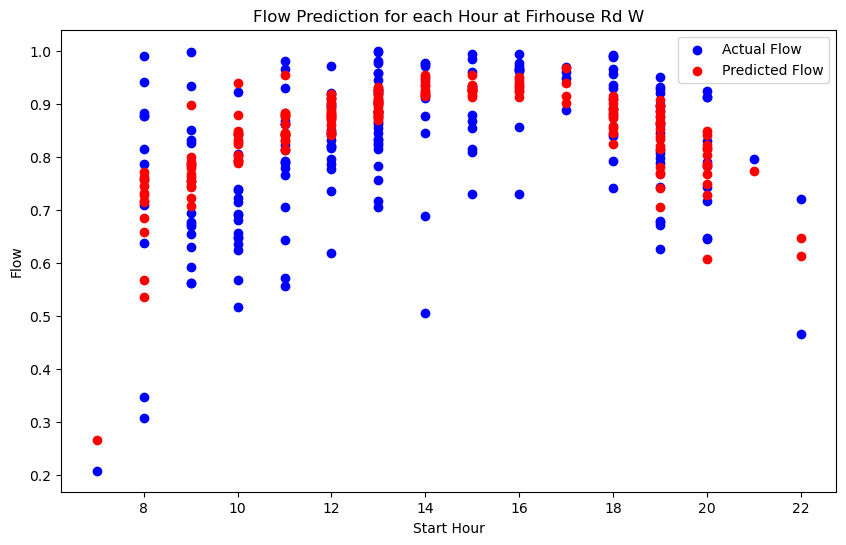

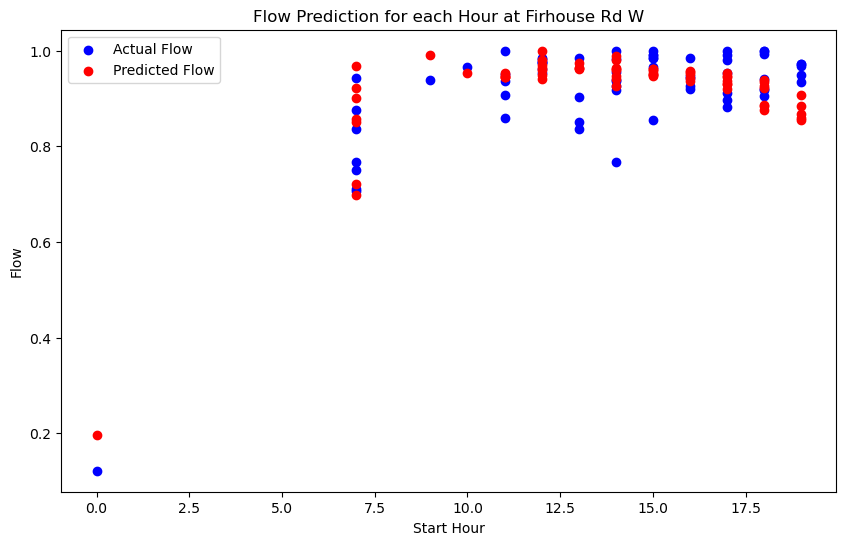

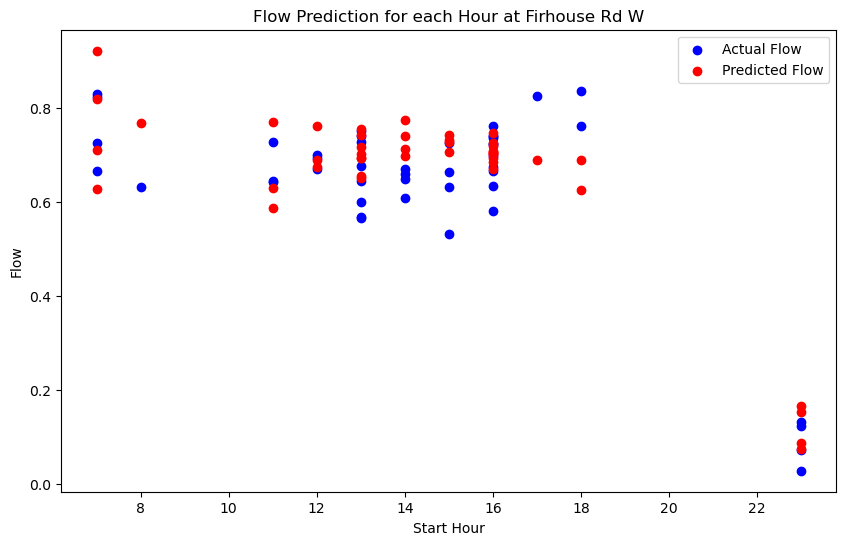

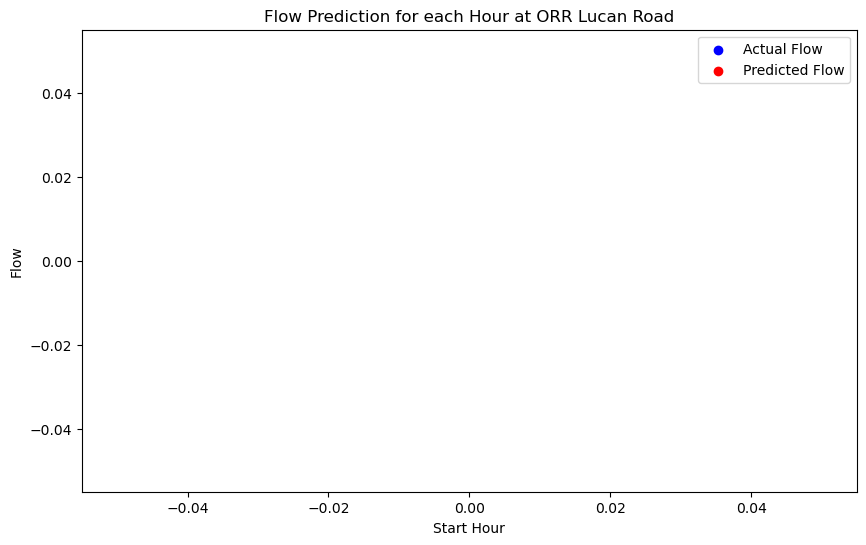

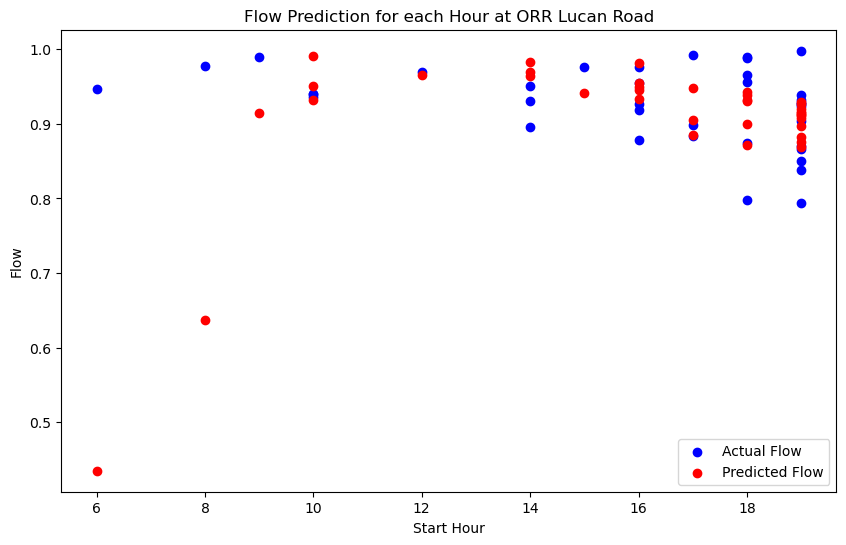

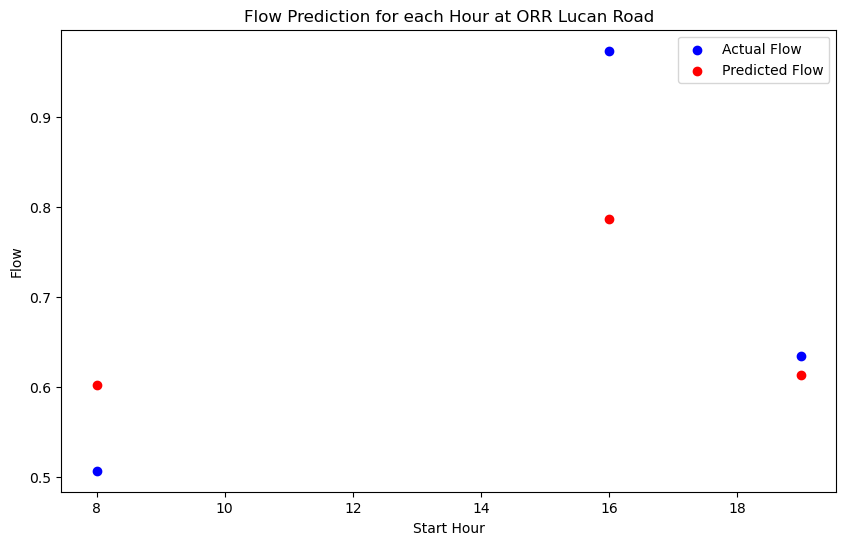

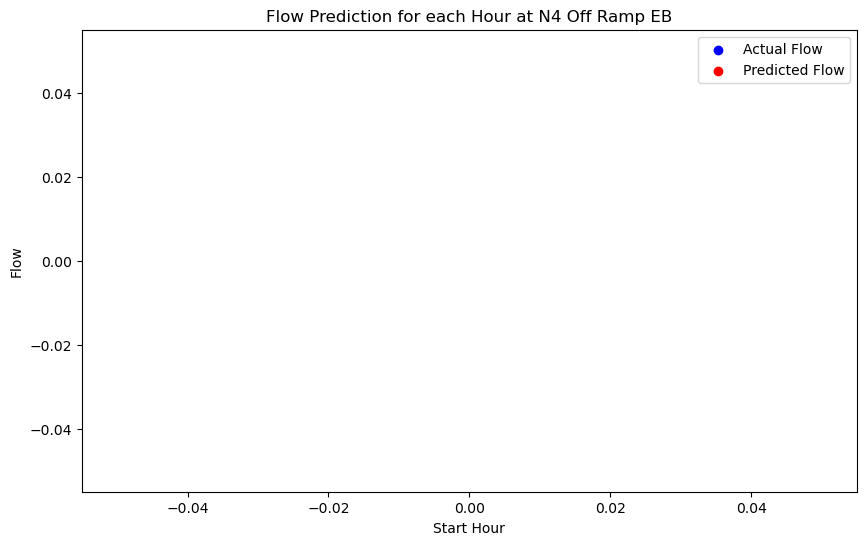

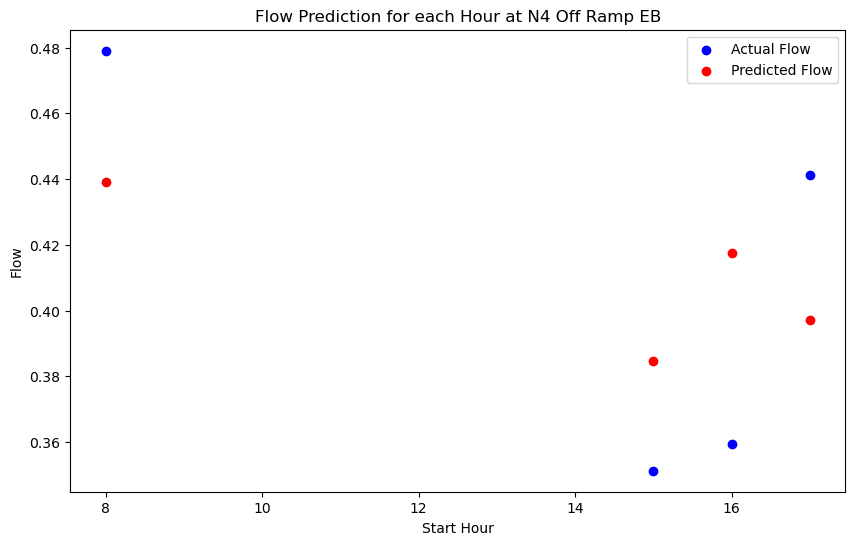

In [26]:
# Scatter Plot

for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), y_test_site_sorted['flow'], label='Actual Flow', color='blue')
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), predictions_site_sorted[:, 0], label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()

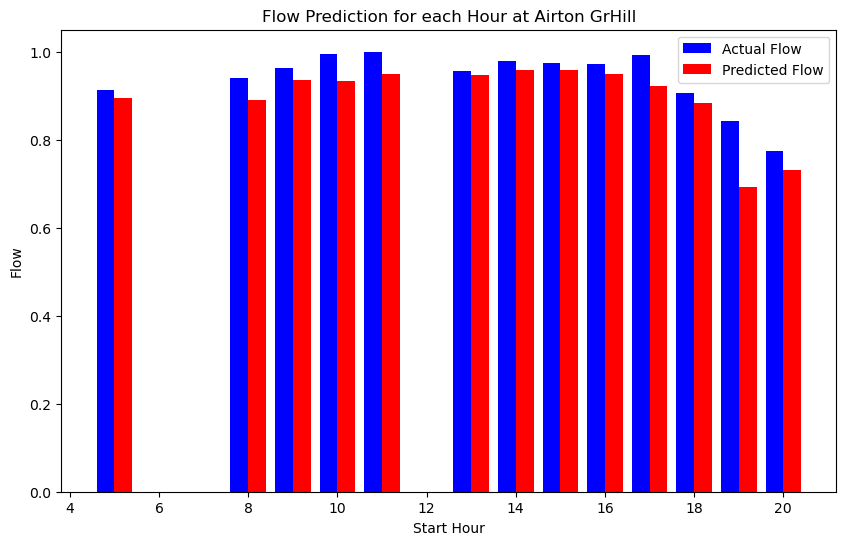

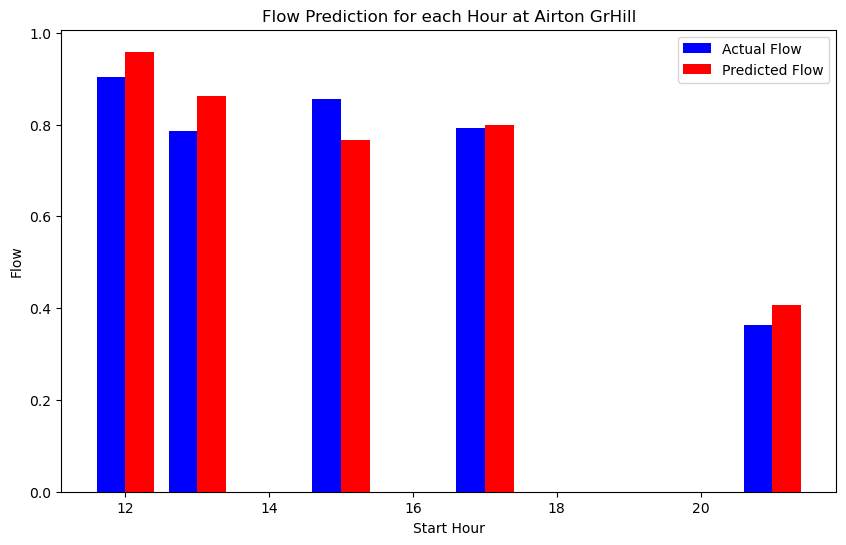

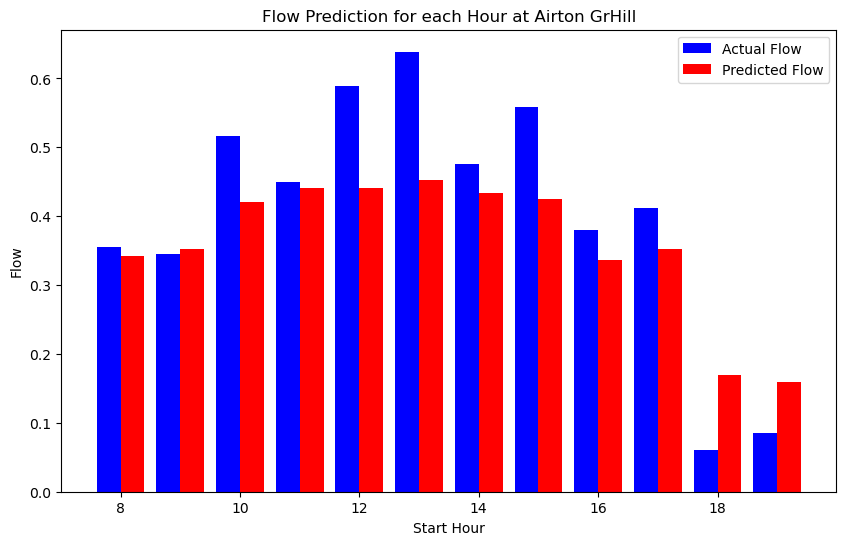

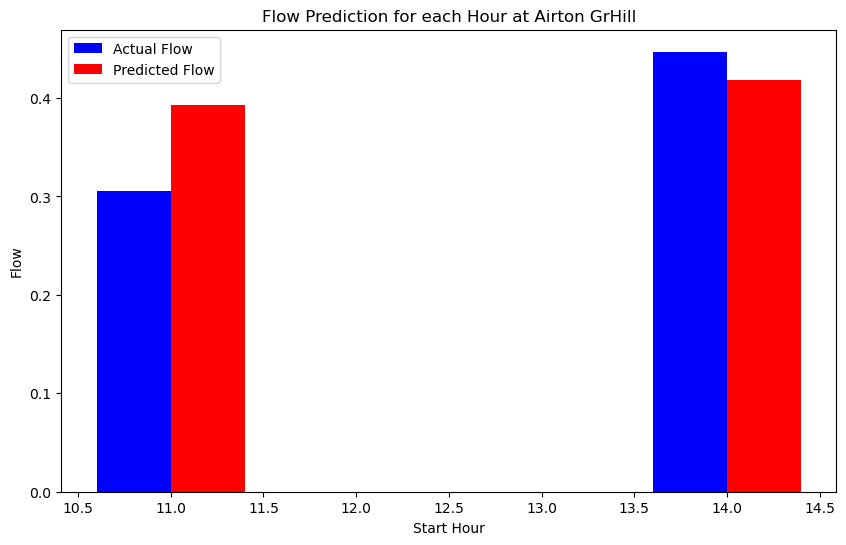

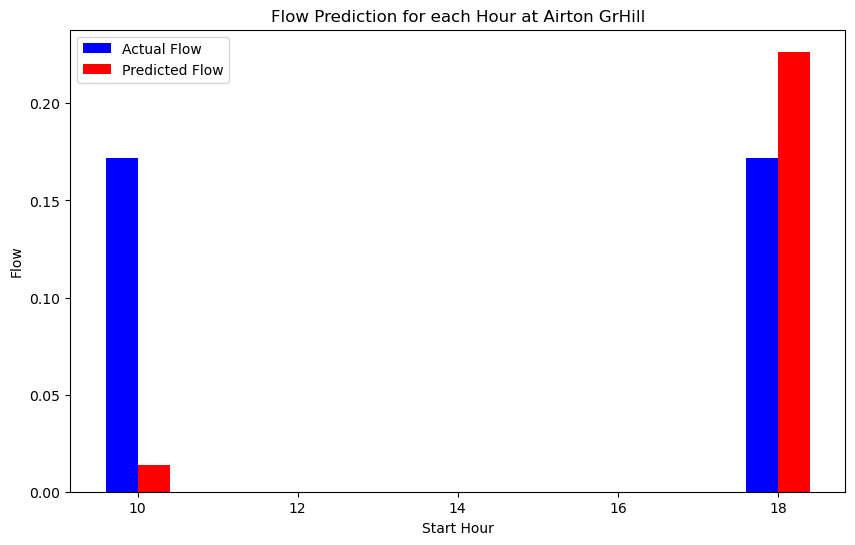

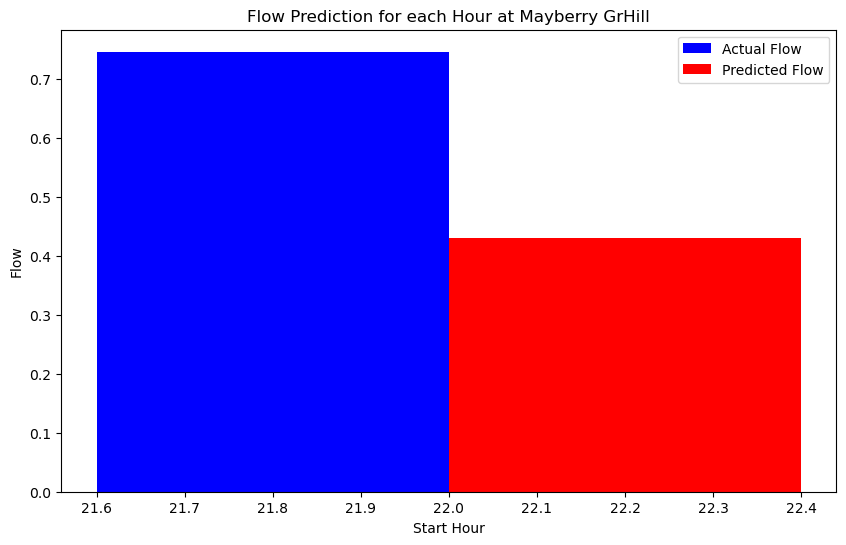

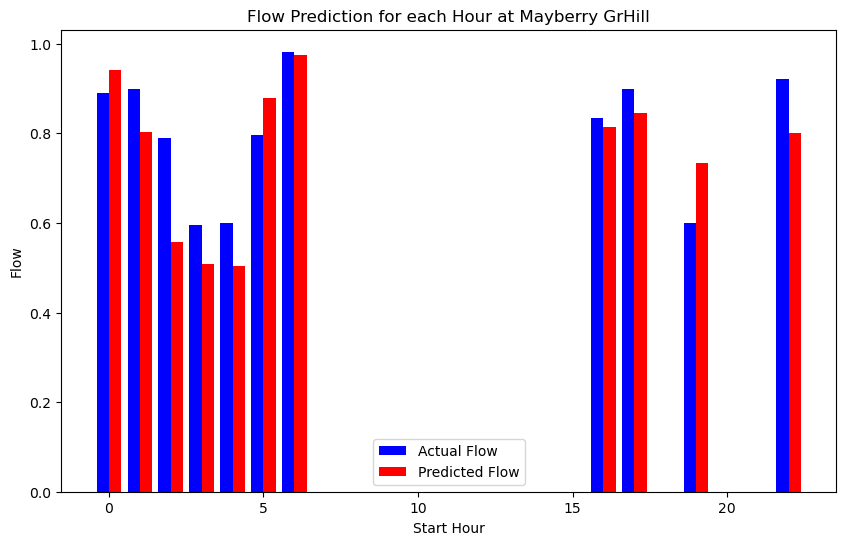

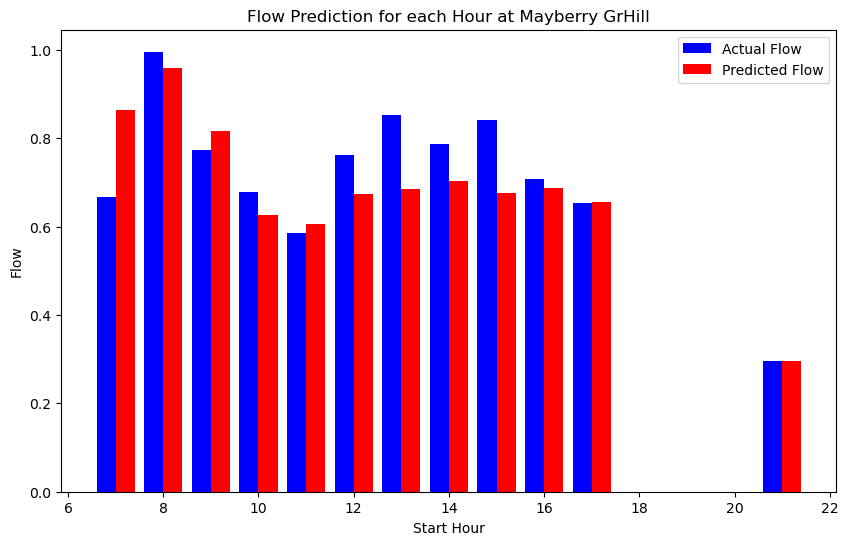

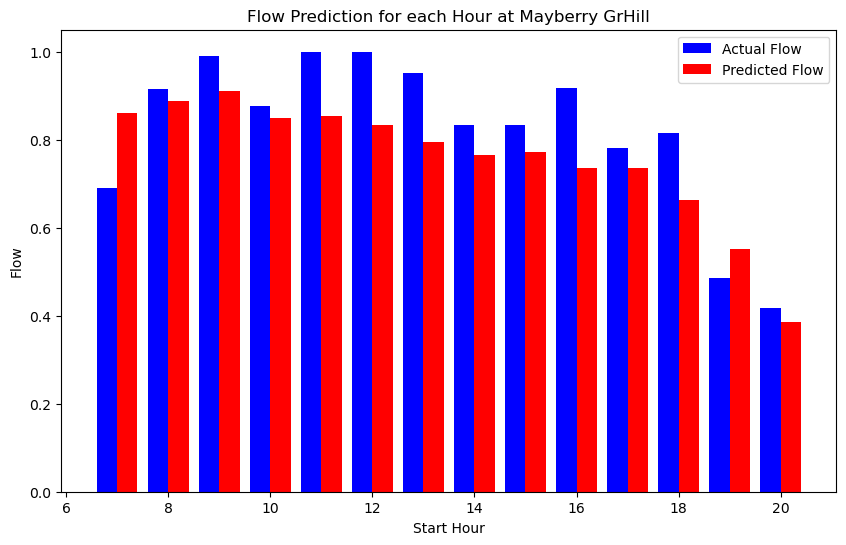

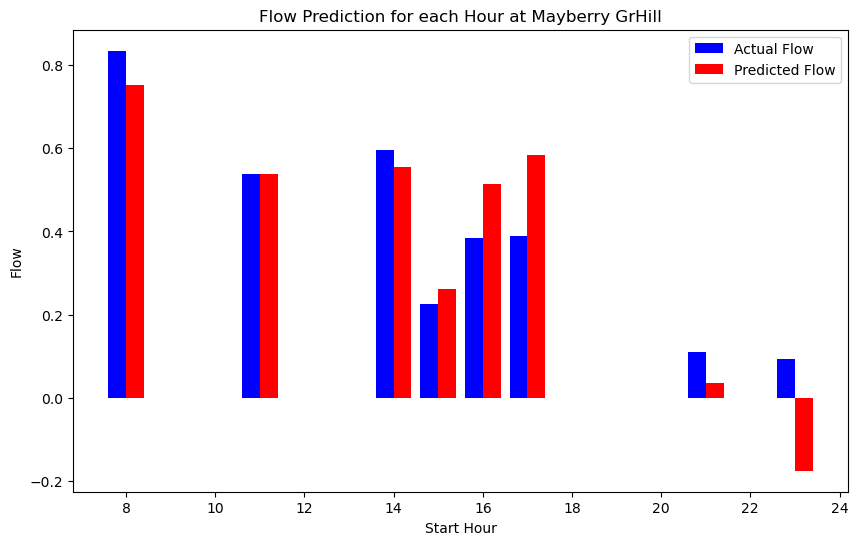

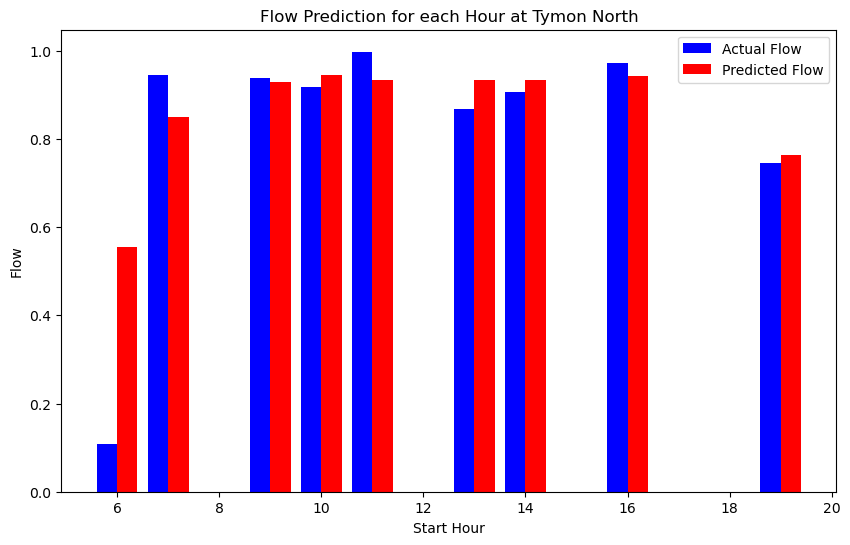

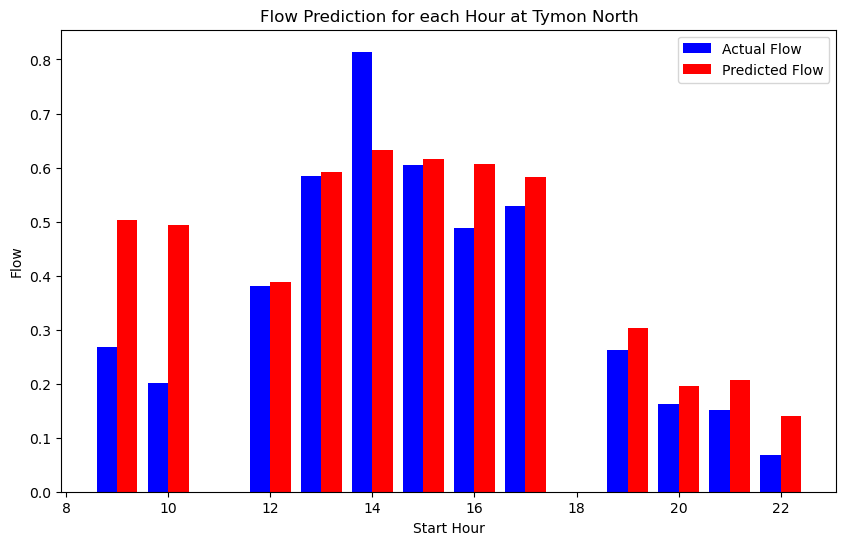

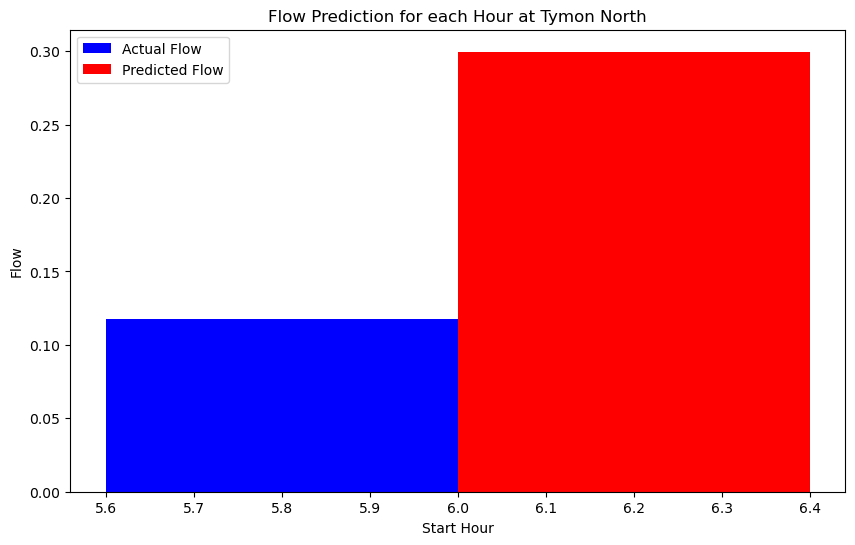

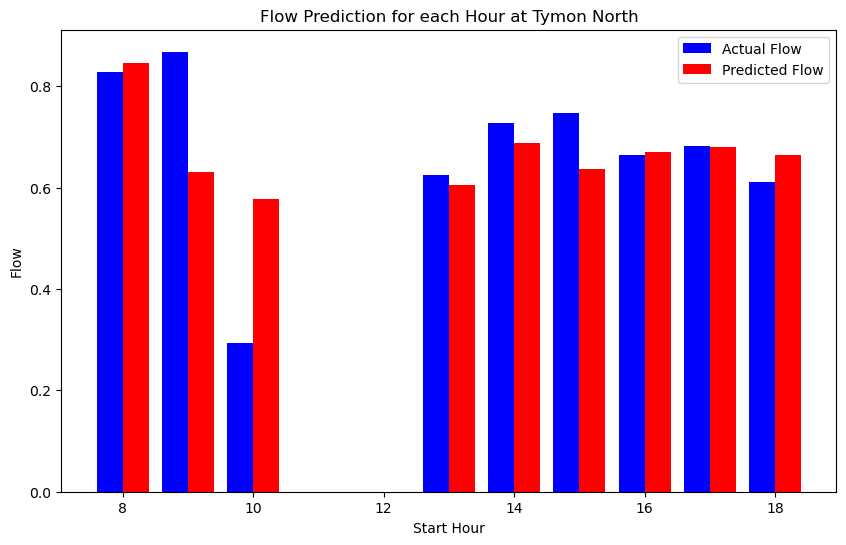

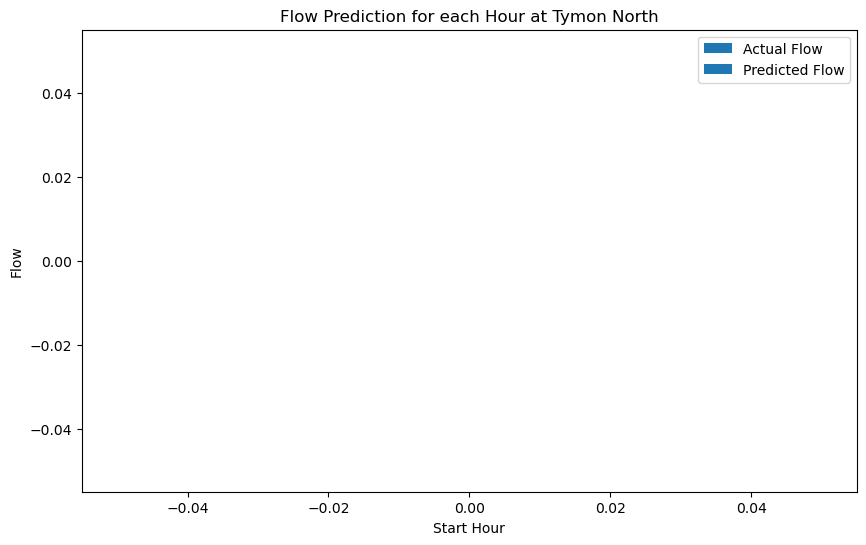

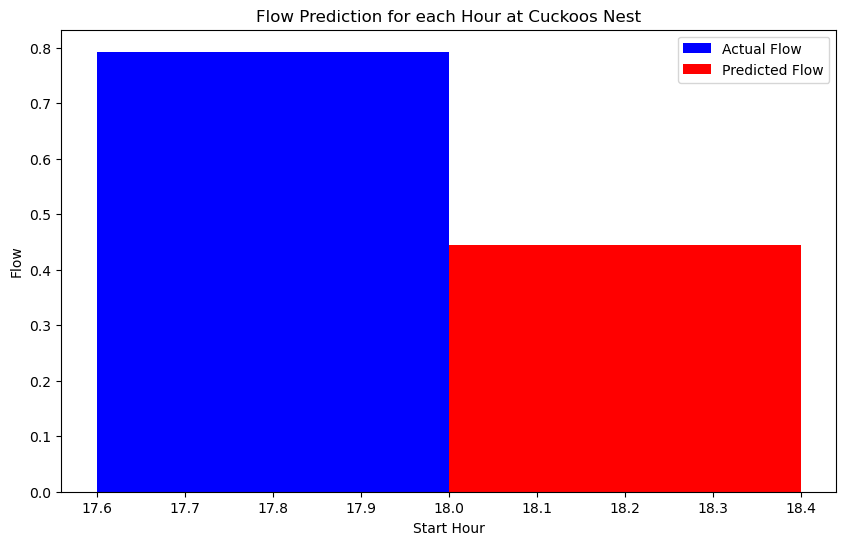

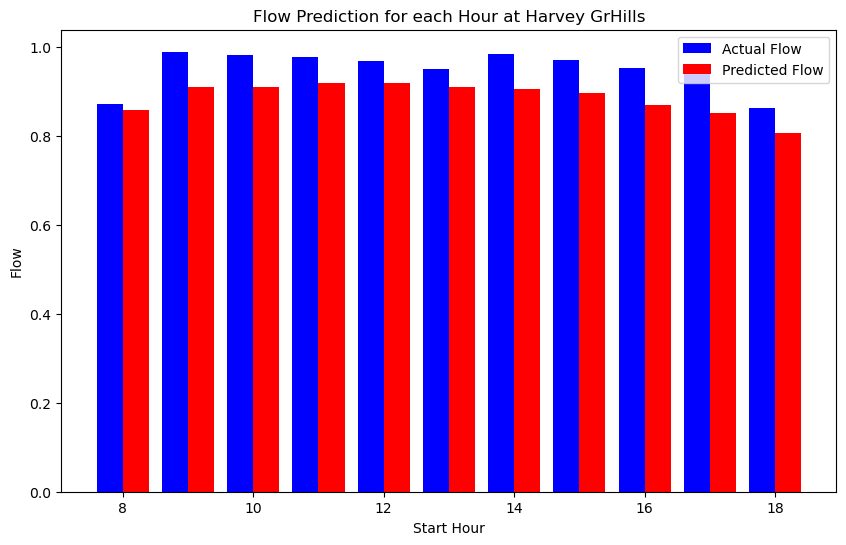

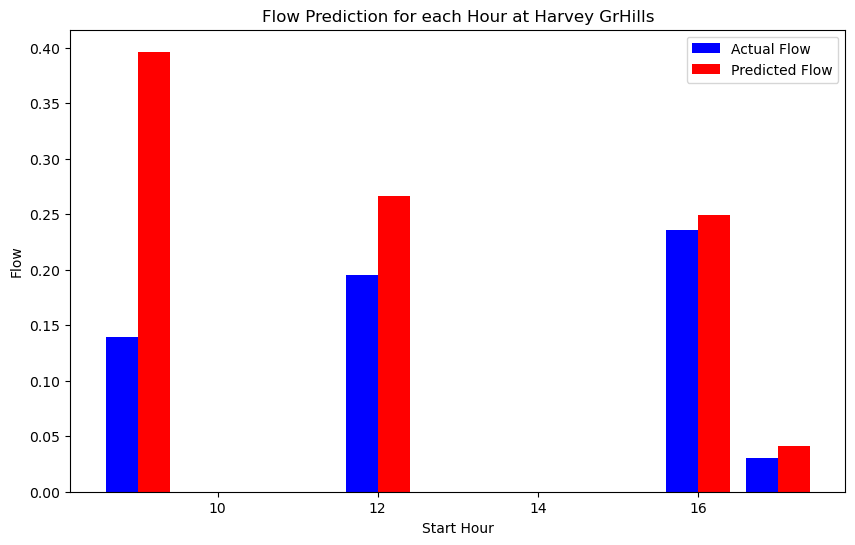

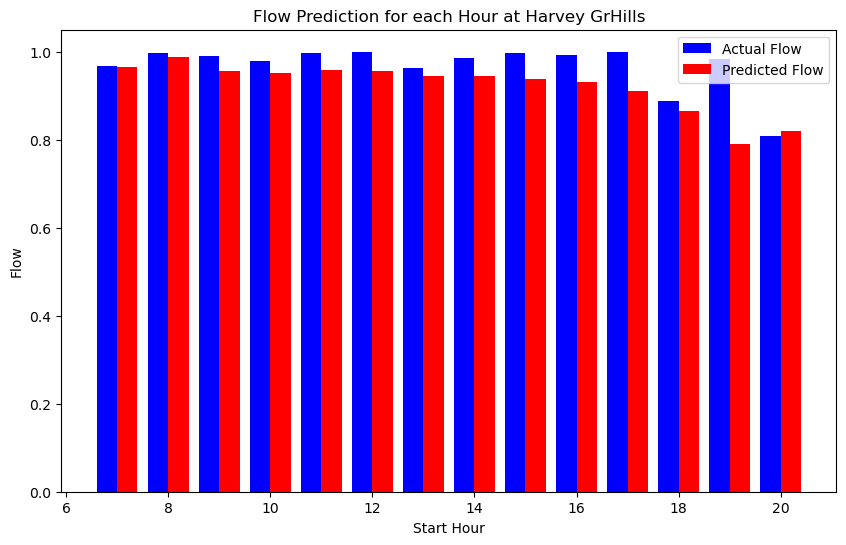

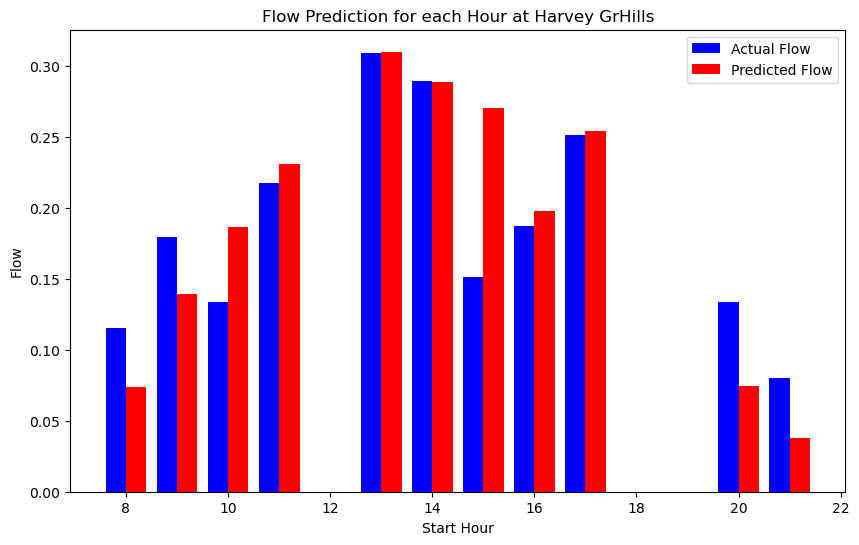

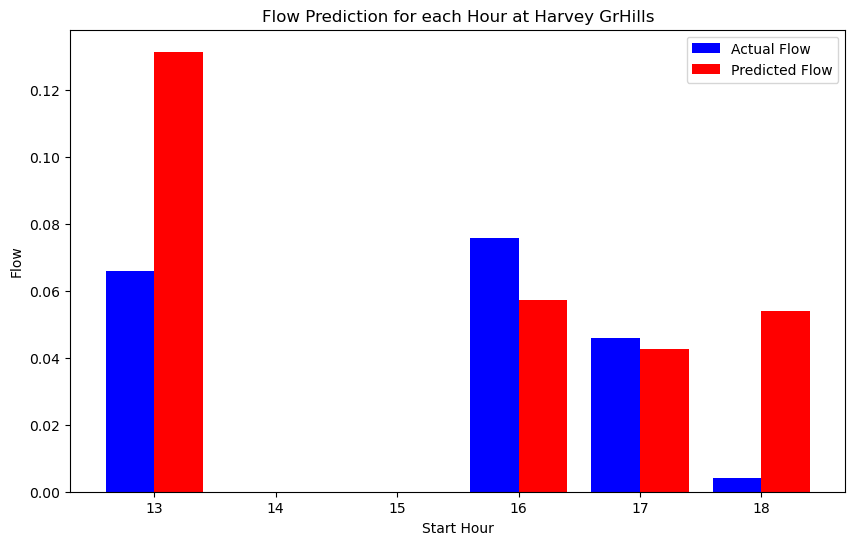

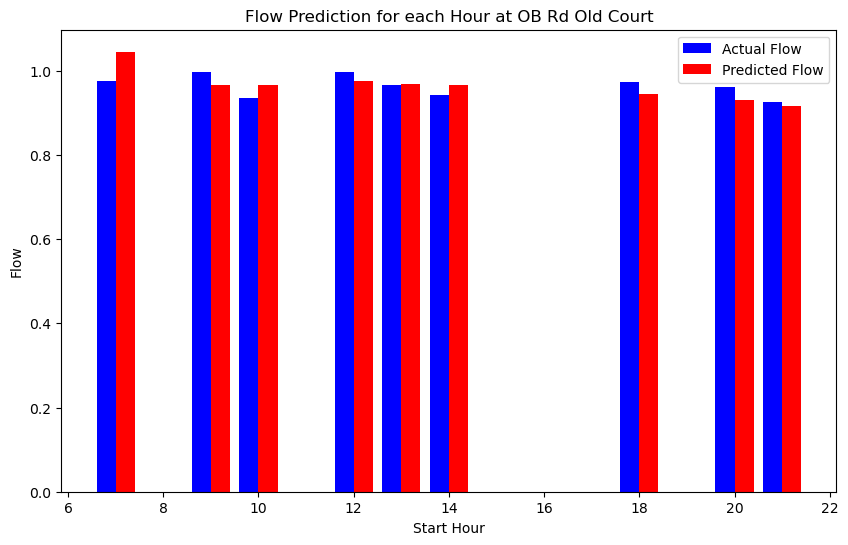

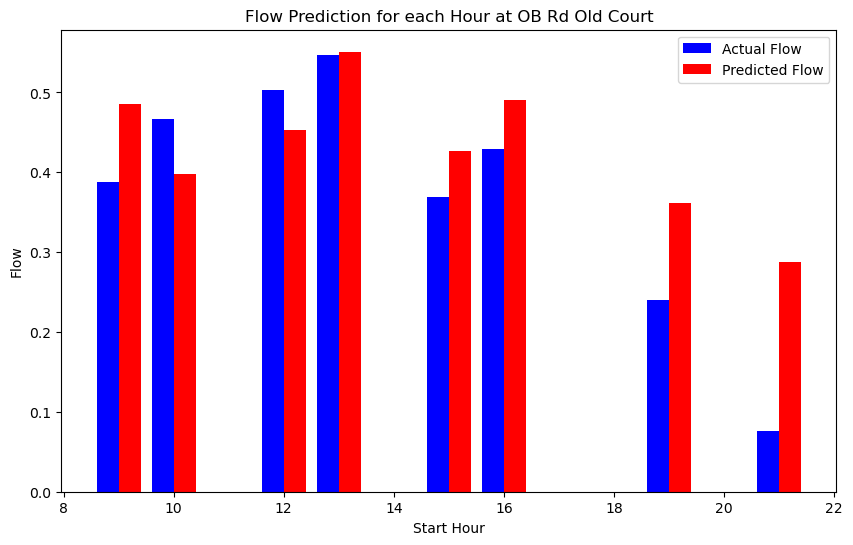

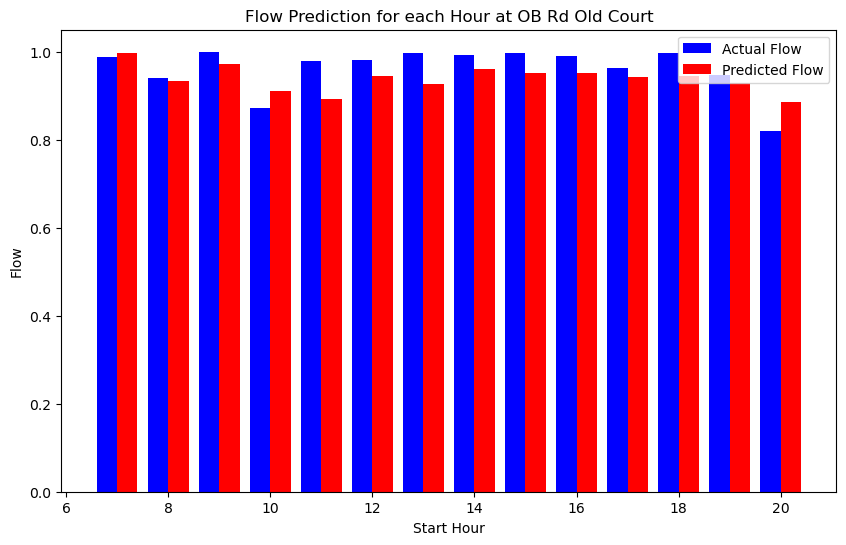

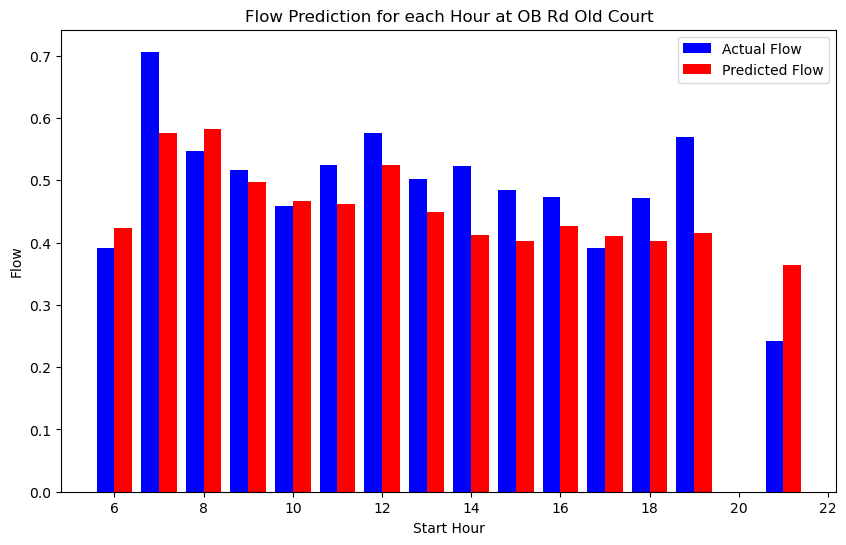

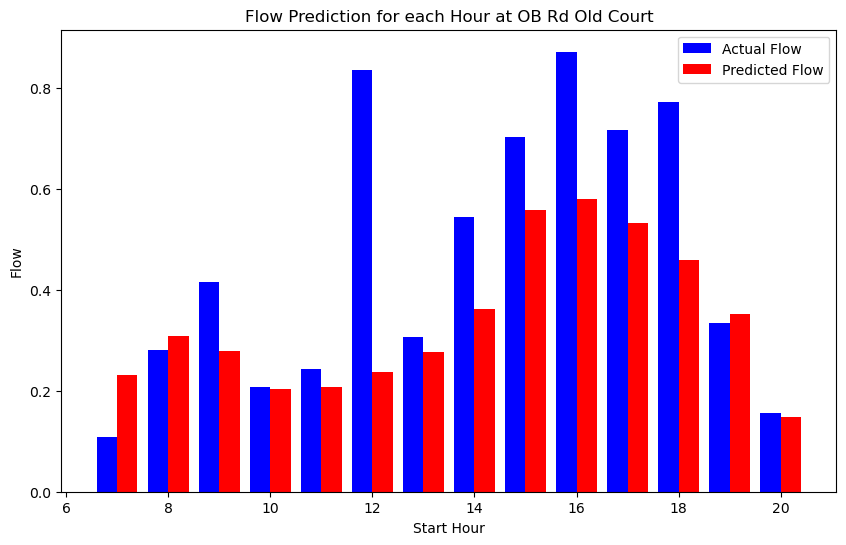

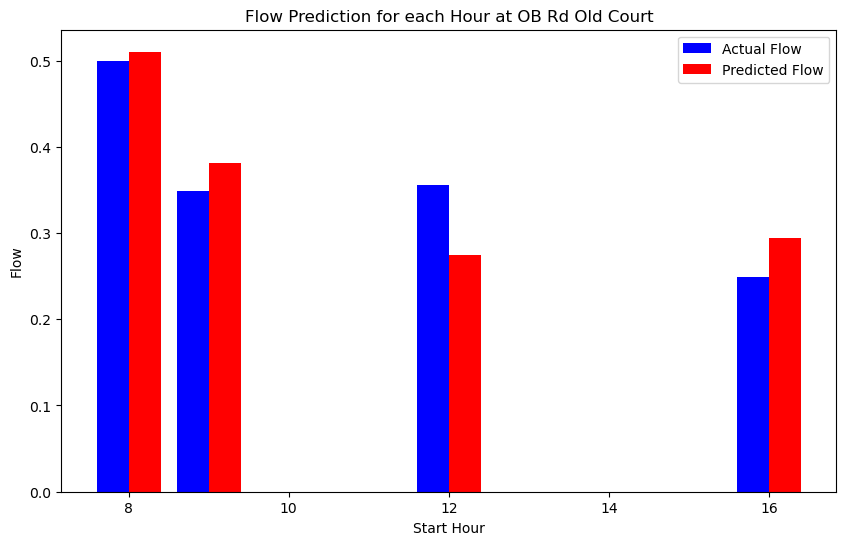

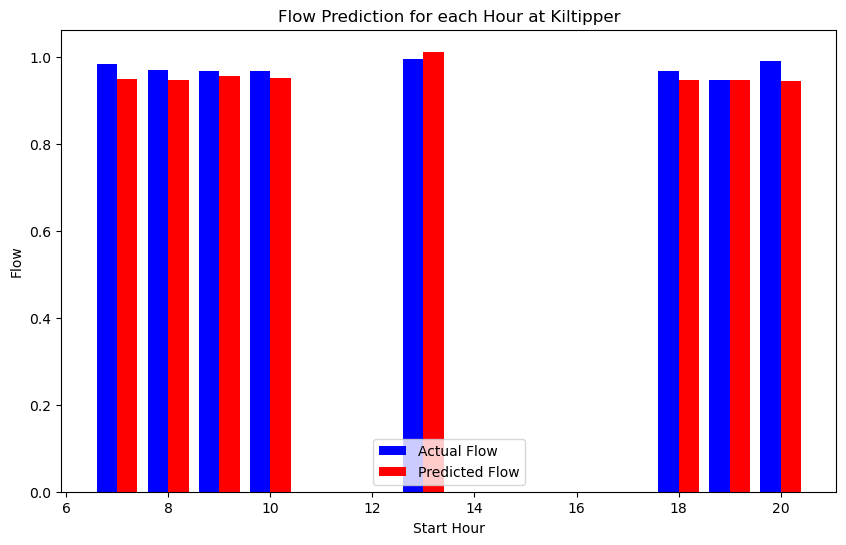

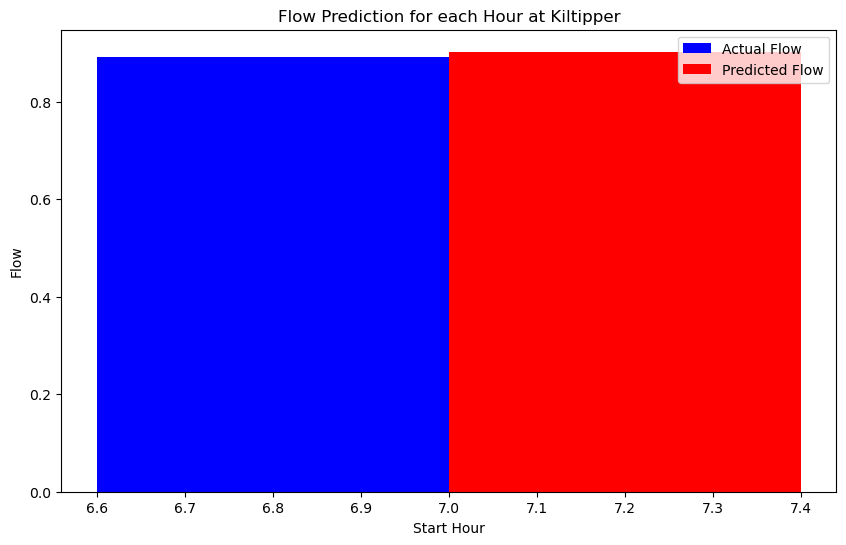

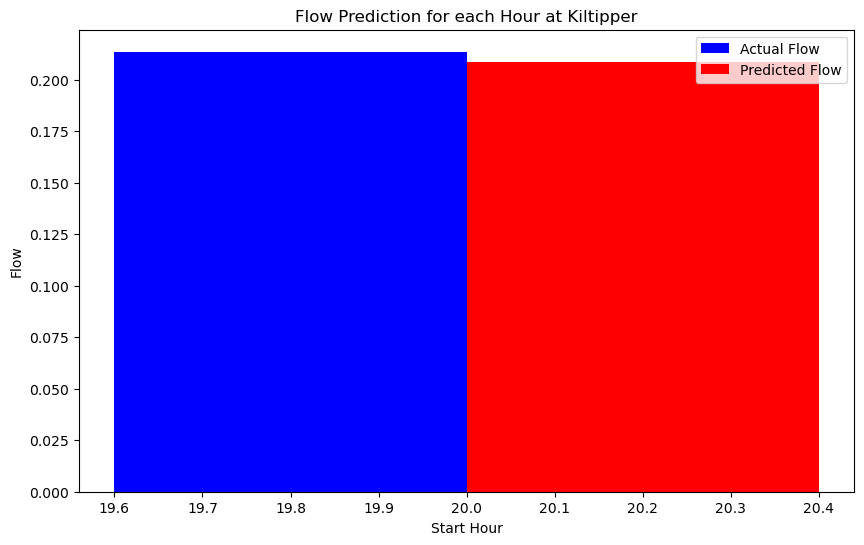

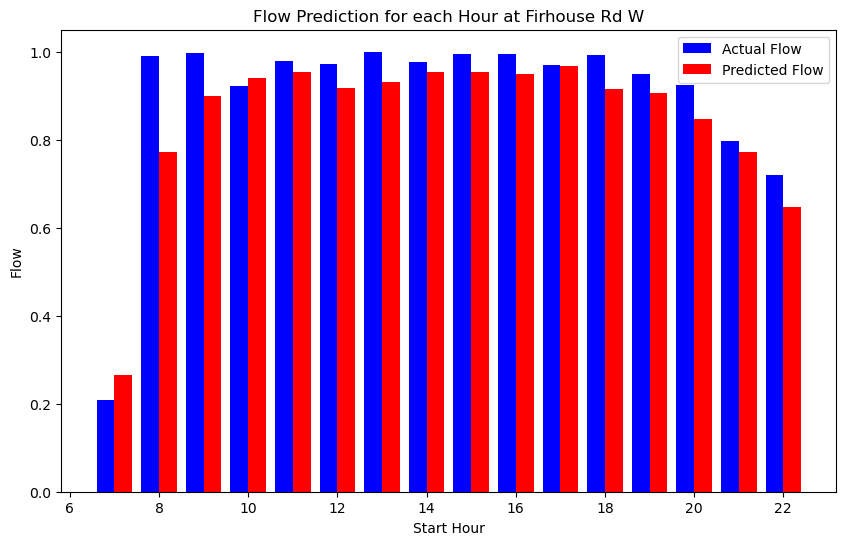

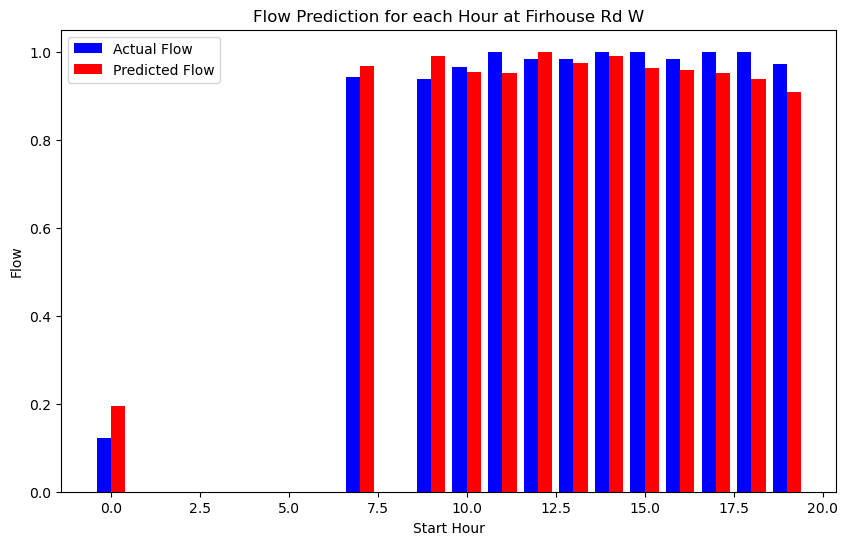

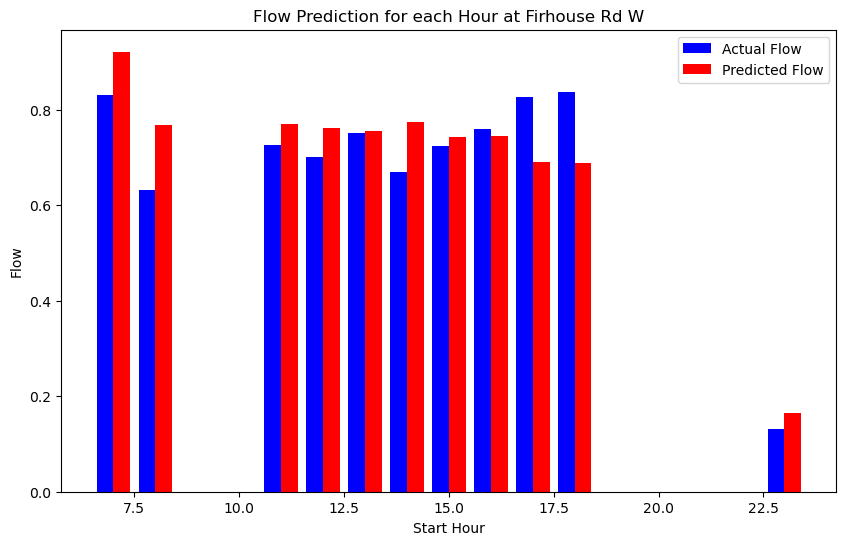

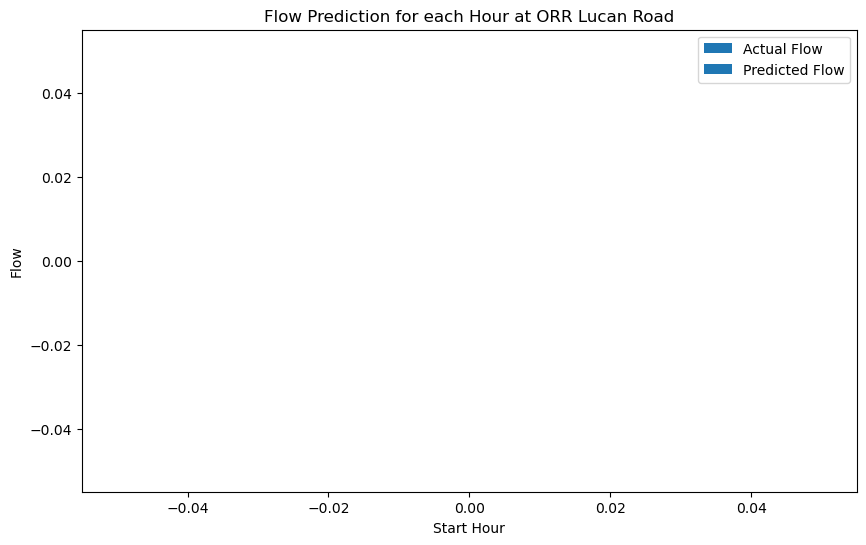

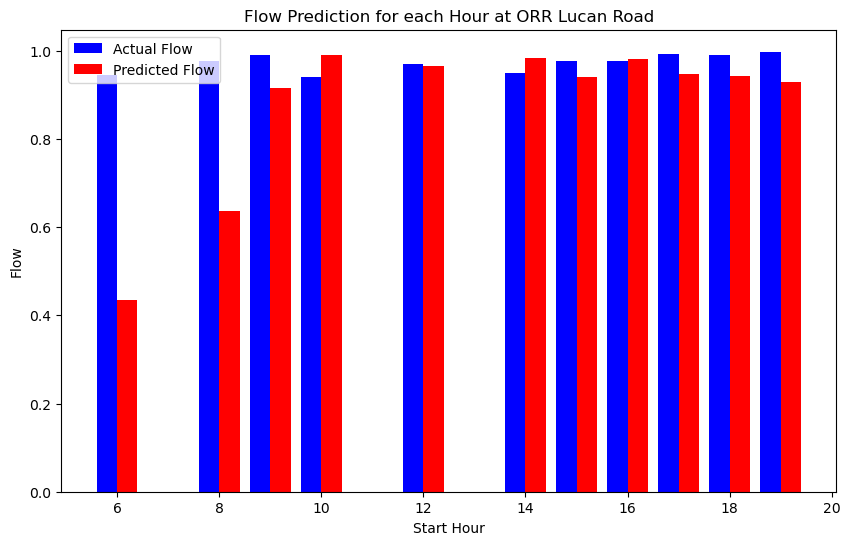

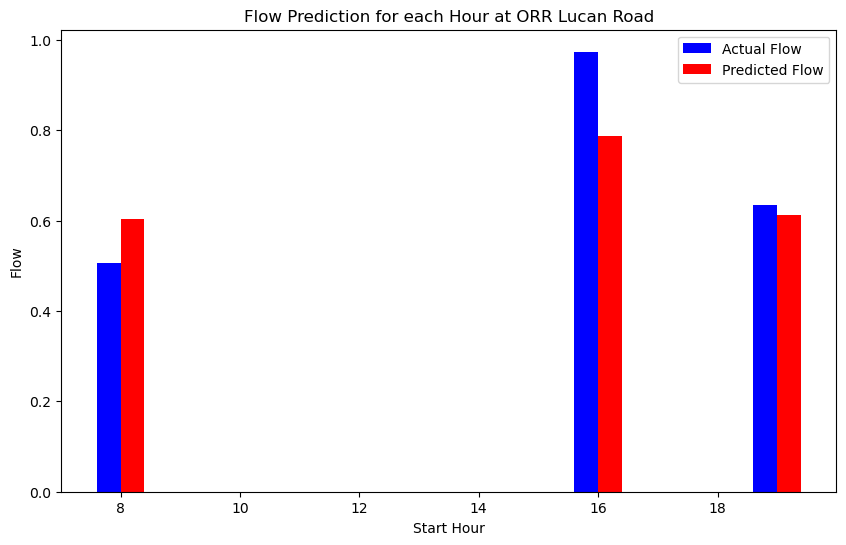

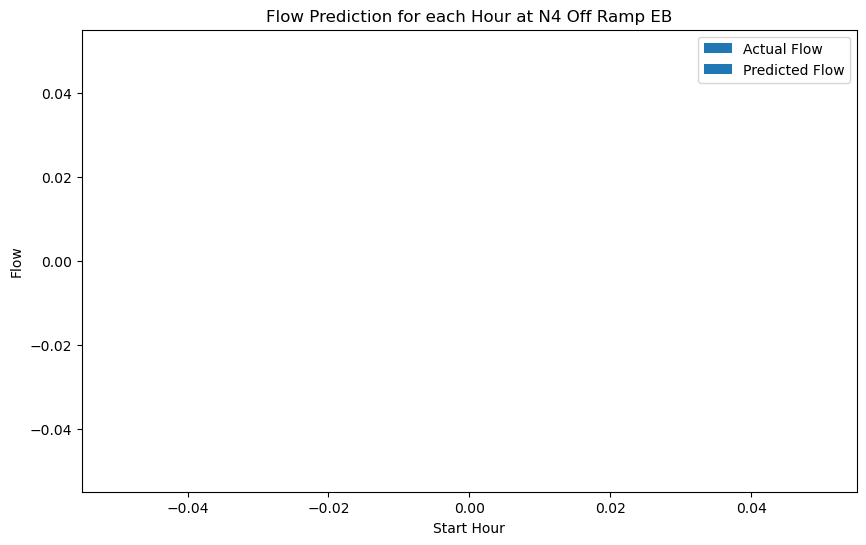

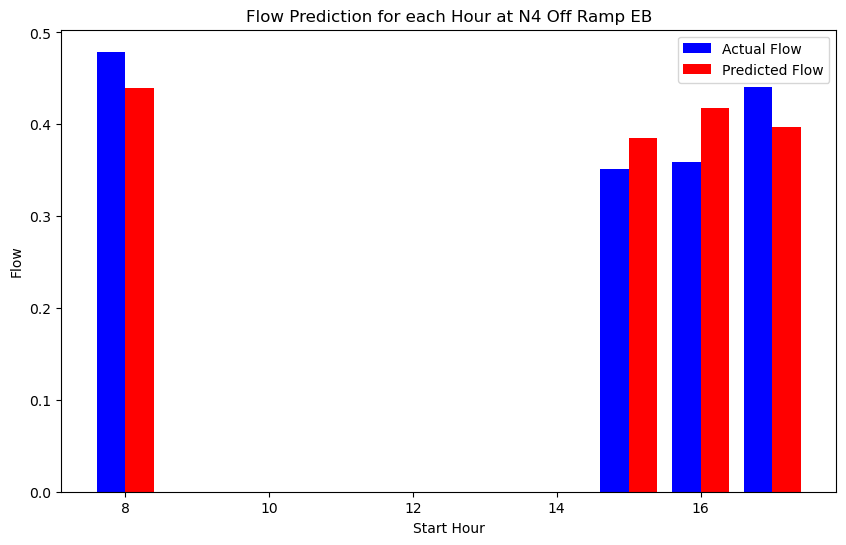

In [27]:
# Bar Chart
for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) - 0.2, y_test_site_sorted['flow'], width=0.4, label='Actual Flow', color='blue')
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) + 0.2, predictions_site_sorted[:, 0], width=0.4, label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()

# Weekends (Sat & Sun)

In [28]:
sites_columns = [col for col in df_weekend.columns if col.startswith('site_')]
# Now, `sites_columns` is a list of column names that start with 'site_'
for index, site in enumerate(sites_columns):
    print(f"Index: {index}, Site Column: {site}")

Index: 0, Site Column: site_N01111A
Index: 1, Site Column: site_N01111C
Index: 2, Site Column: site_N01111D
Index: 3, Site Column: site_N01111M
Index: 4, Site Column: site_N01121E
Index: 5, Site Column: site_N01121G
Index: 6, Site Column: site_N01121H
Index: 7, Site Column: site_N01121J
Index: 8, Site Column: site_N01121V
Index: 9, Site Column: site_N01131A
Index: 10, Site Column: site_N01131B
Index: 11, Site Column: site_N01131C
Index: 12, Site Column: site_N01131F
Index: 13, Site Column: site_N01141G
Index: 14, Site Column: site_N01151A
Index: 15, Site Column: site_N01151B
Index: 16, Site Column: site_N01151C
Index: 17, Site Column: site_N01151J
Index: 18, Site Column: site_N01151L
Index: 19, Site Column: site_N02111A
Index: 20, Site Column: site_N02111C
Index: 21, Site Column: site_N02111D
Index: 22, Site Column: site_N02111K
Index: 23, Site Column: site_N02111M
Index: 24, Site Column: site_N02121E
Index: 25, Site Column: site_N02121G
Index: 26, Site Column: site_N02121H
Index: 27, 

### ML Model

In [29]:
# Prediction Model

# Normalize all features except 'start_hour'
columns_to_normalize = df_weekend.columns.difference(['flow'])
X_to_normalize = df_weekend[columns_to_normalize]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_to_normalize)
X_normalized_df = pd.DataFrame(X_normalized, columns=columns_to_normalize, index=df_weekend.index)

# Add 'start_hour' back to the features without normalization
X_normalized_df['start_hour'] = df_weekend['start_hour']

X_normalized_df = X_normalized_df.drop(columns=['cong', 'dsat'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized_df, df_weekend[['flow']], test_size=0.2, random_state=23)


# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to create and evaluate the model, now including 'start_hour' in training
def train_and_evaluate_model(neurons, lr, activation):
    model = Sequential([
        LSTM(neurons, activation=activation, input_shape=(1, X_train.shape[1])),
        Dense(1)  # Output features: 'flow'
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    # Fit model
    model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_test_reshaped, y_test), batch_size=32, verbose=0)
    
    # Predict on test set
    predictions = model.predict(X_test_reshaped)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print(f"MAE:{mae} || RMSE:{rmse} || MSE:{mse} || R2:{r2} || MAPE:{mape} || Model: {model}")
    print("==========================================================================")

    return mae, mse, rmse, r2, mape, model

# Parameters for model training
neurons = [10, 50, 100]
learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['relu', 'tanh', 'sigmoid']

# Store results
results = []

# Iterate over parameter combinations
for neuron in neurons:
    for lr in learning_rates:
        for activation in activation_functions:
            mae, mse, rmse, r2, mape, trained_model = train_and_evaluate_model(neuron, lr, activation)
            results.append({
                'neurons': neuron,
                'learning_rate': lr,
                'activation': activation,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape,
                'model': trained_model
            })

# Find the best model configuration
best_result = sorted(results, key=lambda x: x['MAE'])[0]
best_model = best_result['model']

# Predict on reshaped test set with the best model
predictions = best_model.predict(X_test_reshaped)

print("Best configuration:", best_result)


15/15 [==============================] - 0s 431us/step
MAE:0.07628583821947837 || RMSE:0.10726484729945517 || MSE:0.011505747466175435 || R2:0.8872559290855722 || MAPE:58.123688506272075 || Model: <keras.src.engine.sequential.Sequential object at 0x2ee5b5190>


15/15 [==============================] - 0s 443us/step


MAE:0.07710963928211591 || RMSE:0.1087752108433338 || MSE:0.011832046494011724 || R2:0.884058546139194 || MAPE:67.57262575652064 || Model: <keras.src.engine.sequential.Sequential object at 0x2ee59f450>
15/15 [==============================] - 0s 391us/step


MAE:0.08195727655450515 || RMSE:0.12235864810354045 || MSE:0.014971638765726046 || R2:0.8532938857149017 || MAPE:64.444120970262 || Model: <keras.src.engine.sequential.Sequential object at 0x2ee3c3f10>
15/15 [==============================] - 0s 413us/step


MAE:0.07378592355987498 || RMSE:0.1024689725174596 || MSE:0.01049989032878389 || R2:0.8971122577388163 || MAPE:43.724332289287425 || Model: <keras.src.engine.sequential.Sequential object at 0x2edc7b7d0>
15/15 [==============================] - 0s 419us/step


MAE:0.07230181161490047 || RMSE:0.10251965810095236 || MSE:0.010510280297136167 || R2:0.8970104471148519 || MAPE:87.89555837282373 || Model: <keras.src.engine.sequential.Sequential object at 0x2ebce3850>
15/15 [==============================] - 0s 402us/step


MAE:0.07752718710374223 || RMSE:0.11009378966745906 || MSE:0.012120642523342714 || R2:0.8812306124224 || MAPE:86.91503431399978 || Model: <keras.src.engine.sequential.Sequential object at 0x2ec1cba50>
15/15 [==============================] - 0s 388us/step


MAE:0.28618215659547724 || RMSE:0.3199121064337945 || MSE:0.10234375584290743 || R2:-0.0028598055296222835 || MAPE:201.90164106769652 || Model: <keras.src.engine.sequential.Sequential object at 0x2ed2dbd50>
15/15 [==============================] - 0s 419us/step


MAE:0.07843737026608731 || RMSE:0.10952640566166587 || MSE:0.011996033537163794 || R2:0.8824516477715272 || MAPE:36.80189818823938 || Model: <keras.src.engine.sequential.Sequential object at 0x2ed1e0a10>
15/15 [==============================] - 0s 390us/step


MAE:0.09408393501318289 || RMSE:0.1356340373177597 || MSE:0.018396592079115426 || R2:0.8197329910074036 || MAPE:52.88521602106181 || Model: <keras.src.engine.sequential.Sequential object at 0x2ed59ddd0>
15/15 [==============================] - 0s 493us/step


MAE:0.0766541730994922 || RMSE:0.11378821518818281 || MSE:0.0129477579157122 || R2:0.8731257625005793 || MAPE:113.6066363220682 || Model: <keras.src.engine.sequential.Sequential object at 0x2d6a45f50>
15/15 [==============================] - 0s 584us/step


MAE:0.0770920110641915 || RMSE:0.11143809456955518 || MSE:0.012418448921293124 || R2:0.8783124269026849 || MAPE:75.6822363907078 || Model: <keras.src.engine.sequential.Sequential object at 0x2ed61b690>
15/15 [==============================] - 0s 403us/step


MAE:0.07985341458145113 || RMSE:0.12064228502499072 || MSE:0.0145545609360511 || R2:0.8573808042348802 || MAPE:103.20963301101212 || Model: <keras.src.engine.sequential.Sequential object at 0x2cc71a1d0>
15/15 [==============================] - 0s 470us/step


MAE:0.08482789506191453 || RMSE:0.19317435945134592 || MSE:0.0373163331494378 || R2:0.6343396790834381 || MAPE:390.1981876184386 || Model: <keras.src.engine.sequential.Sequential object at 0x2edfcc890>
15/15 [==============================] - 0s 477us/step


MAE:0.07823224564115677 || RMSE:0.11116720682084012 || MSE:0.012358147872347442 || R2:0.8789033129584177 || MAPE:83.11076626206862 || Model: <keras.src.engine.sequential.Sequential object at 0x29a6bb490>
15/15 [==============================] - 0s 401us/step


MAE:0.07765945436659827 || RMSE:0.11746821523926561 || MSE:0.013798781591498431 || R2:0.8647866368649118 || MAPE:154.36945775344194 || Model: <keras.src.engine.sequential.Sequential object at 0x2ebf8a650>
15/15 [==============================] - 0s 601us/step


MAE:0.0967842877257505 || RMSE:0.1443390905897016 || MSE:0.020833773072262085 || R2:0.7958512130064164 || MAPE:58.042299534208475 || Model: <keras.src.engine.sequential.Sequential object at 0x2da082010>
15/15 [==============================] - 0s 495us/step


MAE:0.09229332709211097 || RMSE:0.13877100695252695 || MSE:0.01925739237061828 || R2:0.8112980649503468 || MAPE:112.73234670997165 || Model: <keras.src.engine.sequential.Sequential object at 0x2e94baf90>
15/15 [==============================] - 0s 417us/step


MAE:0.0814307185054812 || RMSE:0.11257112683506947 || MSE:0.012672258596917297 || R2:0.875825362402837 || MAPE:48.971920918288255 || Model: <keras.src.engine.sequential.Sequential object at 0x2e5efe090>
15/15 [==============================] - 0s 467us/step


MAE:0.07372263865881551 || RMSE:0.10790037870650912 || MSE:0.011642491725008086 || R2:0.8859159809891715 || MAPE:78.21184928053559 || Model: <keras.src.engine.sequential.Sequential object at 0x2f24e8550>
15/15 [==============================] - 0s 511us/step


MAE:0.07840880048268142 || RMSE:0.11573055477042286 || MSE:0.013393561307469845 || R2:0.8687573640664945 || MAPE:119.590053306411 || Model: <keras.src.engine.sequential.Sequential object at 0x2ed677e10>
15/15 [==============================] - 0s 473us/step


MAE:0.08327095711480181 || RMSE:0.12493727882085436 || MSE:0.015609323639159903 || R2:0.8470452531247252 || MAPE:103.53897909506733 || Model: <keras.src.engine.sequential.Sequential object at 0x2f89c3450>
15/15 [==============================] - 0s 452us/step


MAE:0.07794687790093344 || RMSE:0.12936308817711936 || MSE:0.016734808582721156 || R2:0.8360166993812134 || MAPE:188.1153012949798 || Model: <keras.src.engine.sequential.Sequential object at 0x2a78197d0>
15/15 [==============================] - 0s 502us/step


MAE:0.08223311663182317 || RMSE:0.11356405965169004 || MSE:0.012896795644572613 || R2:0.8736251384801246 || MAPE:58.38445420701379 || Model: <keras.src.engine.sequential.Sequential object at 0x29be63e50>
15/15 [==============================] - 0s 555us/step


MAE:0.07504258262926901 || RMSE:0.11275098040550134 || MSE:0.012712783582401748 || R2:0.8754282607064285 || MAPE:140.27587195045808 || Model: <keras.src.engine.sequential.Sequential object at 0x2f24ba810>
15/15 [==============================] - 0s 451us/step


MAE:0.09454144407656748 || RMSE:0.13232008208442397 || MSE:0.017508604122828696 || R2:0.8284343272229835 || MAPE:60.688581456346625 || Model: <keras.src.engine.sequential.Sequential object at 0x2fe6f8950>
15/15 [==============================] - 0s 560us/step


MAE:0.08656889393933884 || RMSE:0.12263974610376728 || MSE:0.015040507324396503 || R2:0.8526190471887353 || MAPE:43.54151089721846 || Model: <keras.src.engine.sequential.Sequential object at 0x2ffd6f710>
15/15 [==============================] - 0s 453us/step
MAE:0.07711910086418422 || RMSE:0.11128530890315444 || MSE:0.012384419977670504 || R2:0.8786458743074893 || MAPE:54.02324210875814 || Model: <keras.src.engine.sequential.Sequential object at 0x3022eef50>
15/15 [==============================] - 0s 386us/step
Best configuration: {'neurons': 10, 'learning_rate': 0.01, 'activation': 'tanh', 'MAE': 0.07230181161490047, 'MSE': 0.010510280297136167, 'RMSE': 0.10251965810095236, 'R2': 0.8970104471148519, 'MAPE': 87.89555837282373, 'model': <keras.src.engine.sequential.Sequential object at 0x2ebce3850>}


### Display Results

#### `Flow`

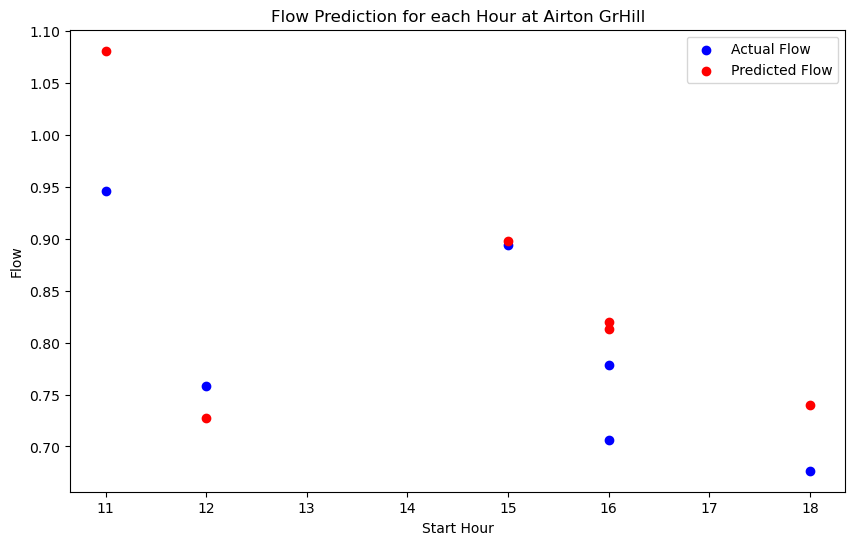

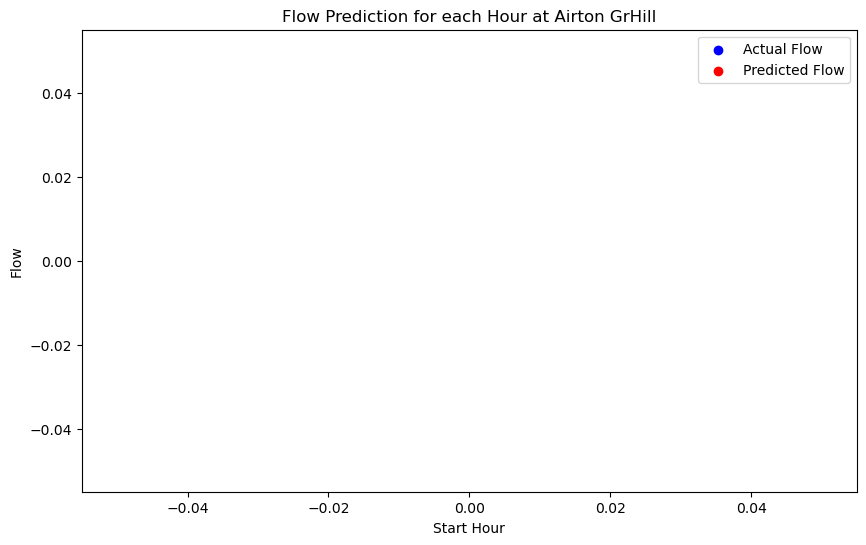

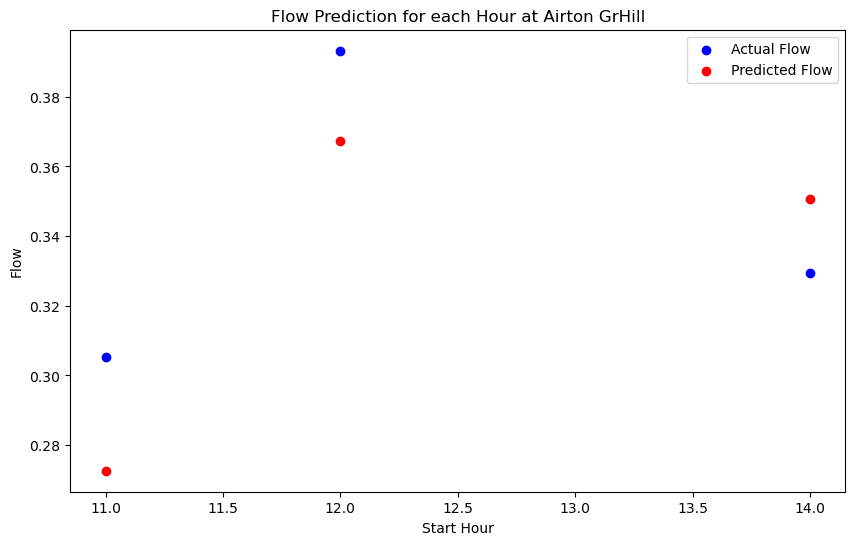

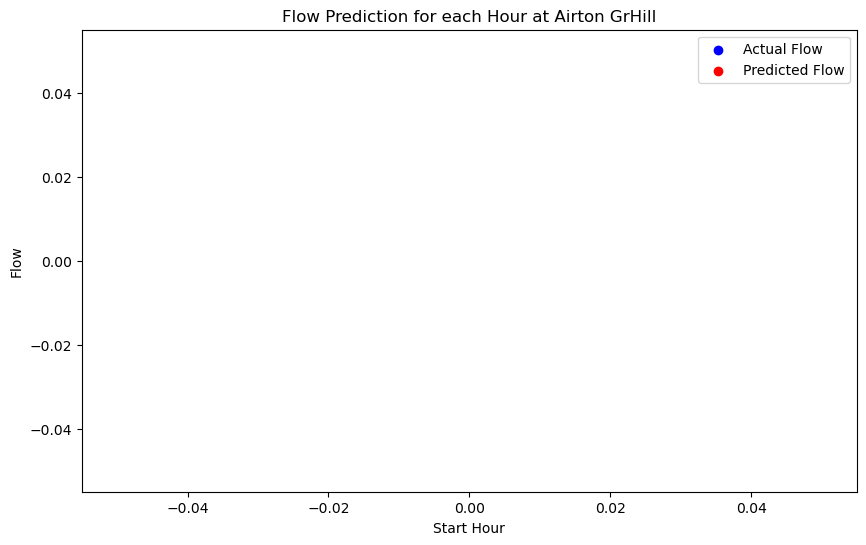

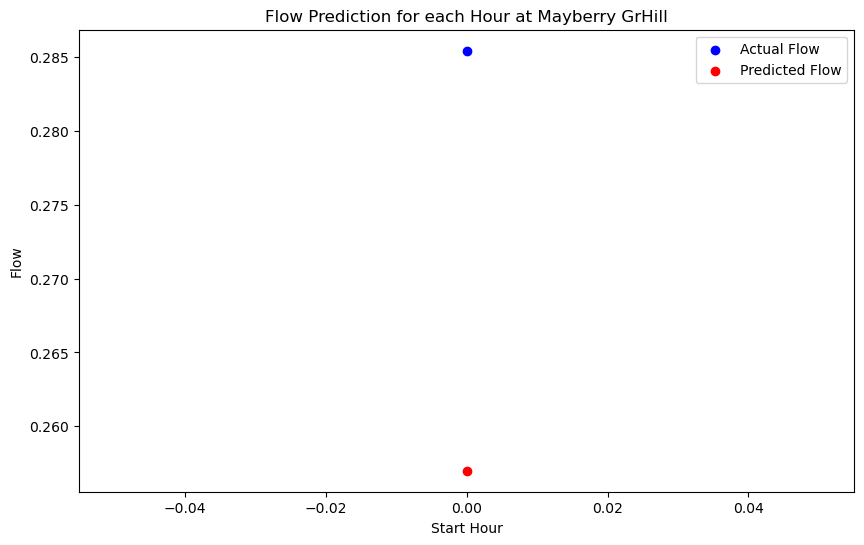

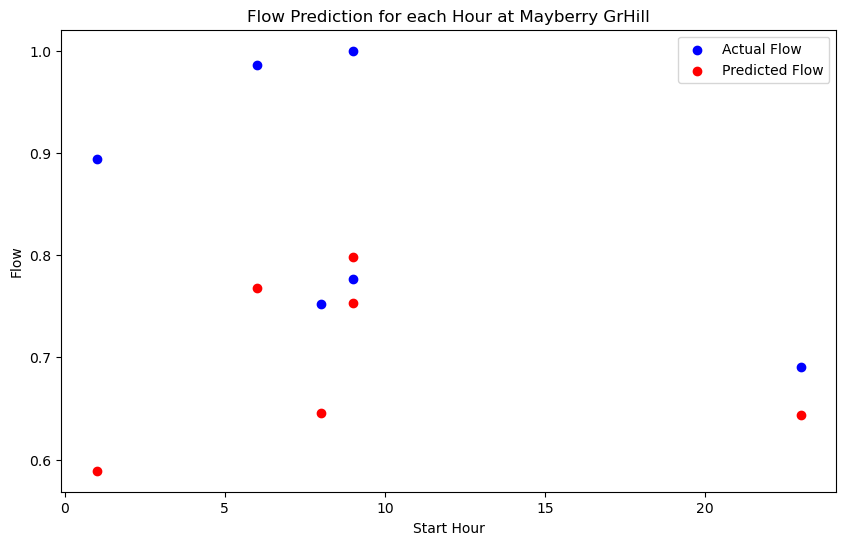

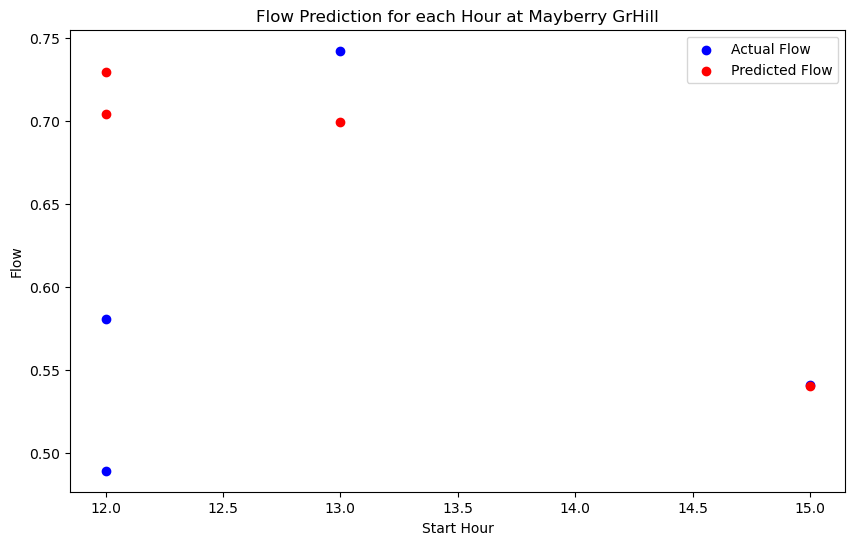

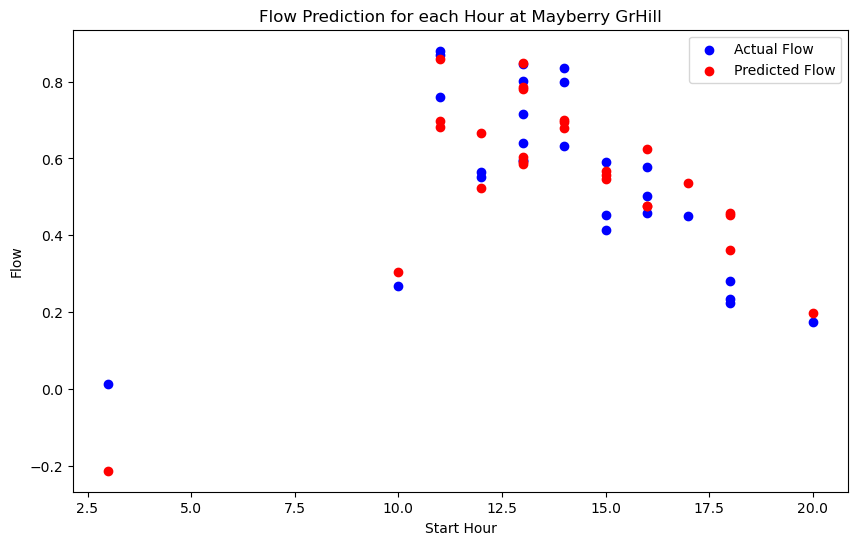

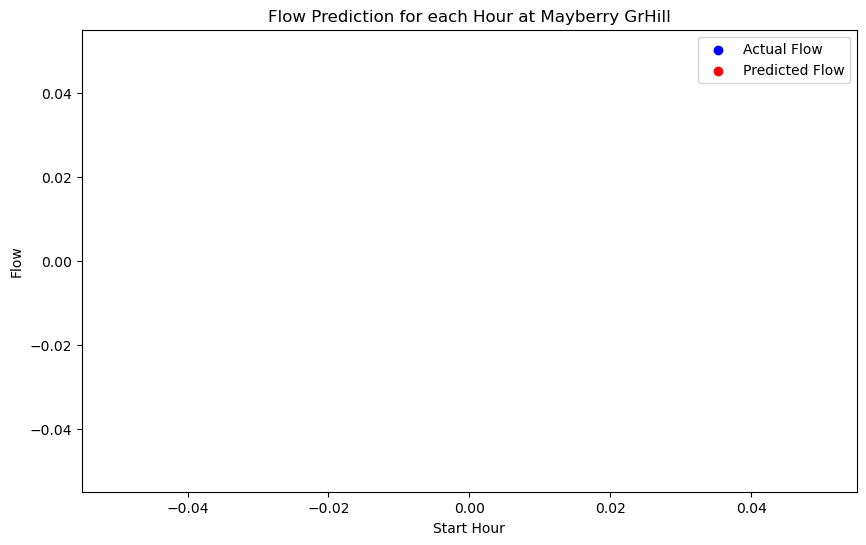

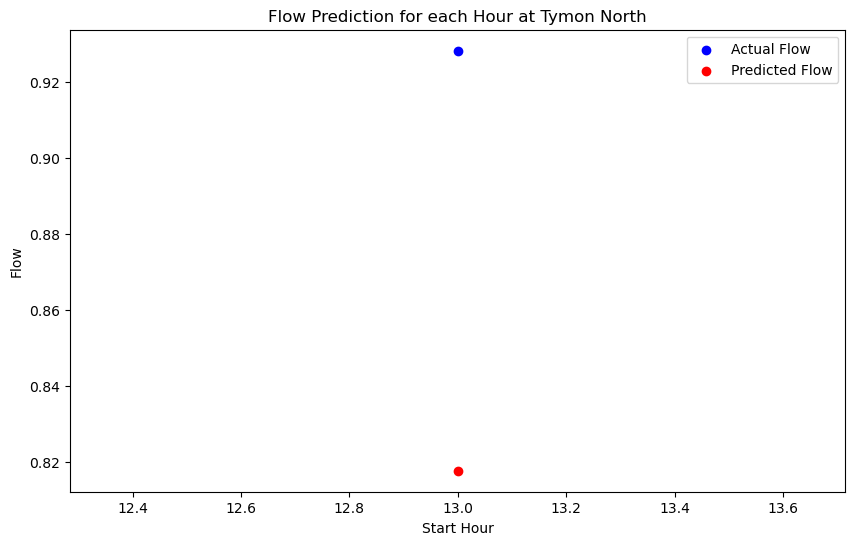

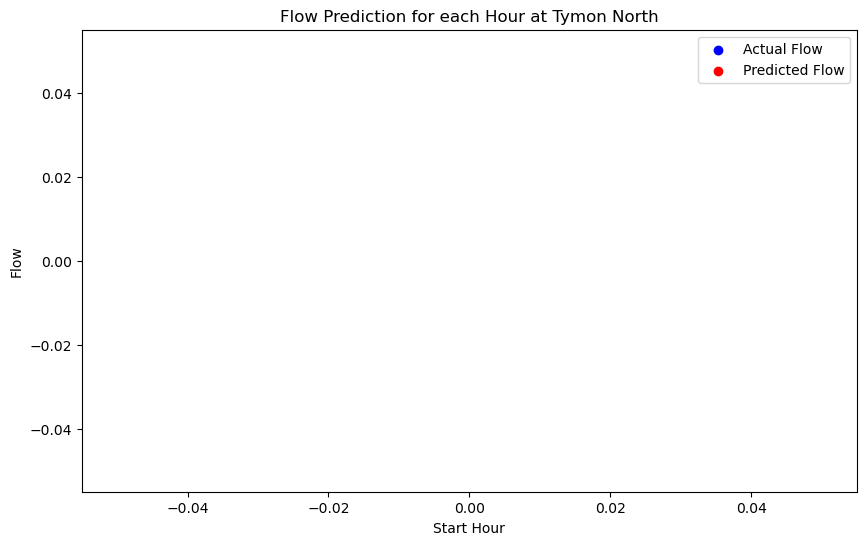

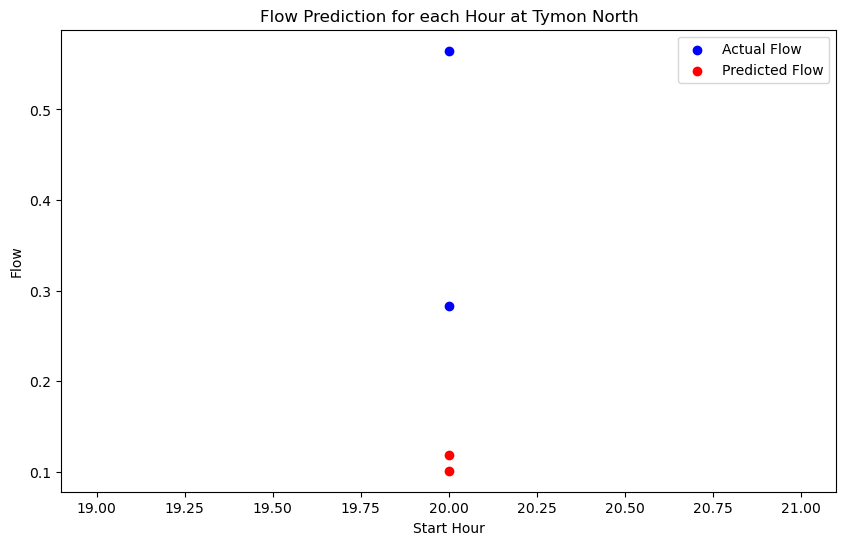

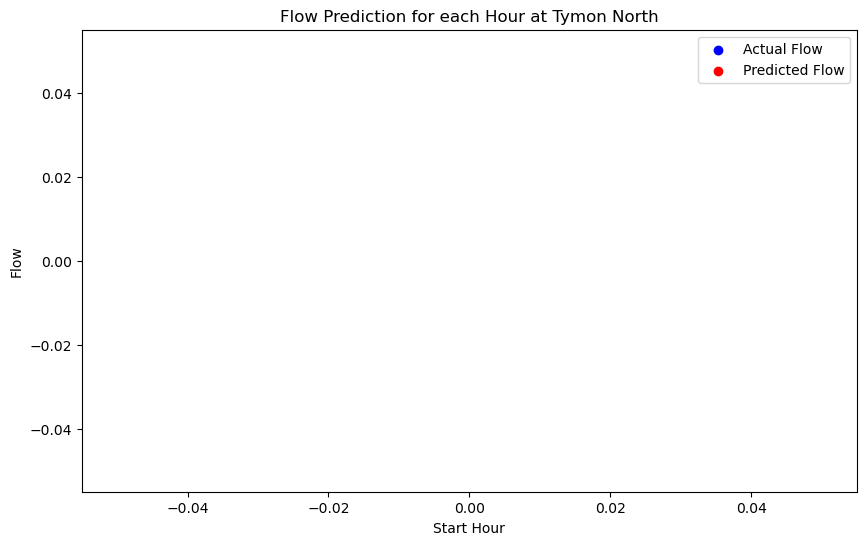

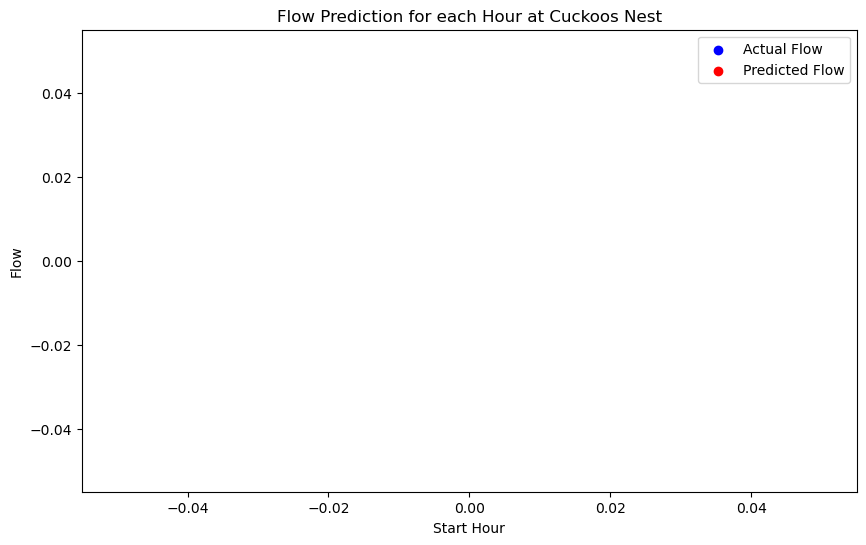

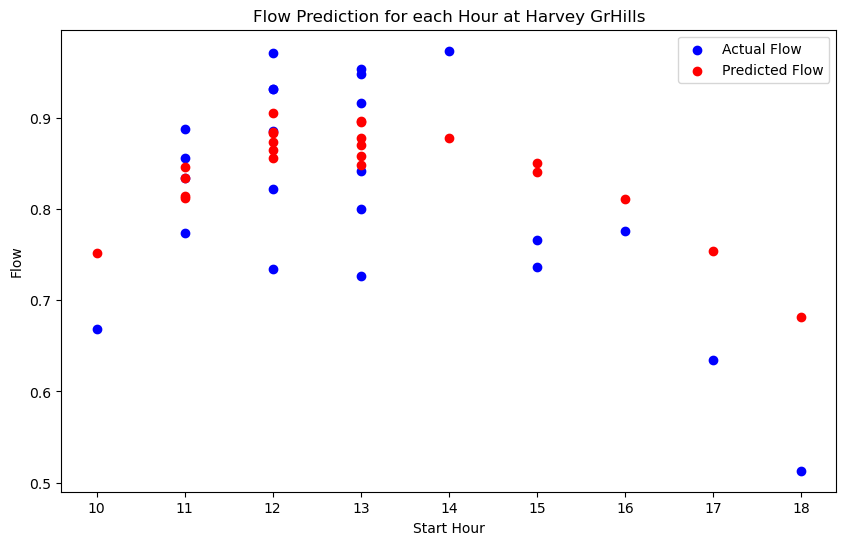

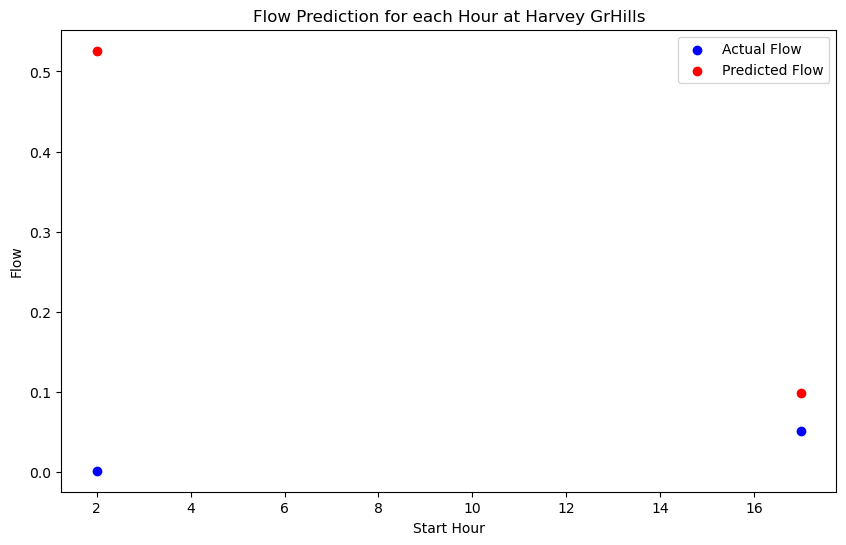

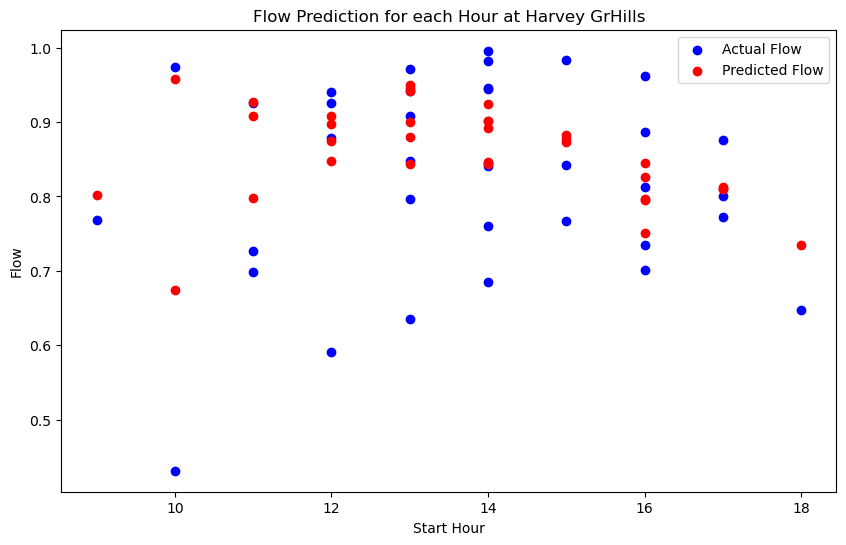

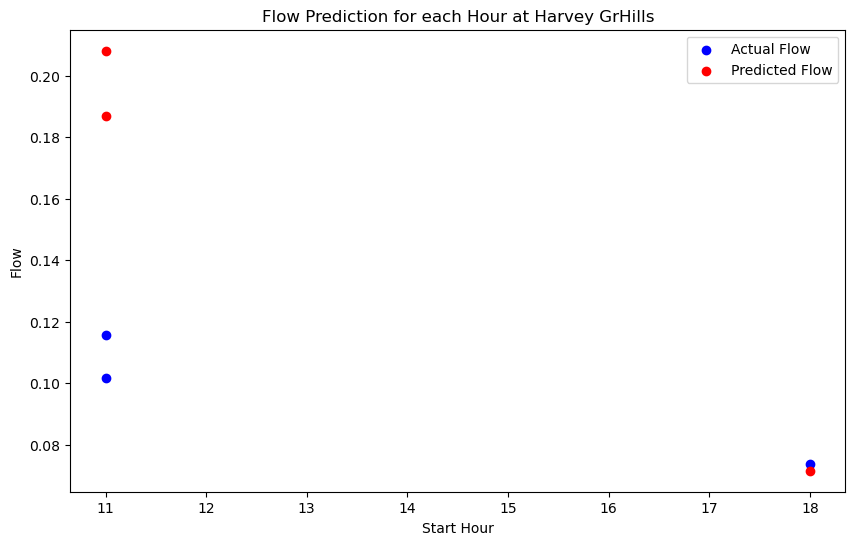

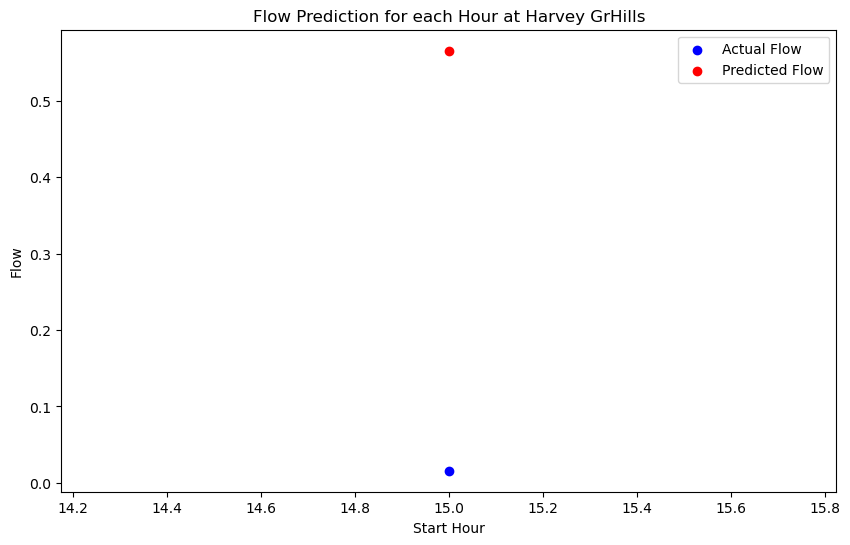

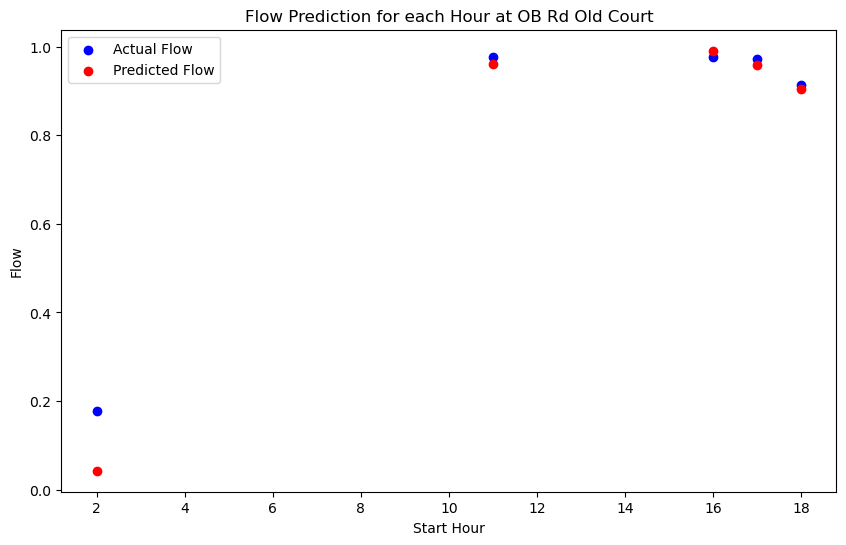

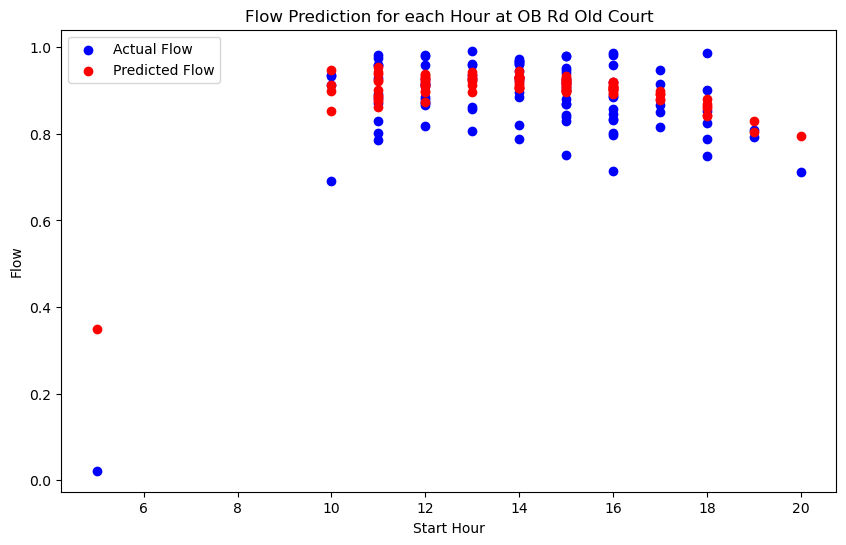

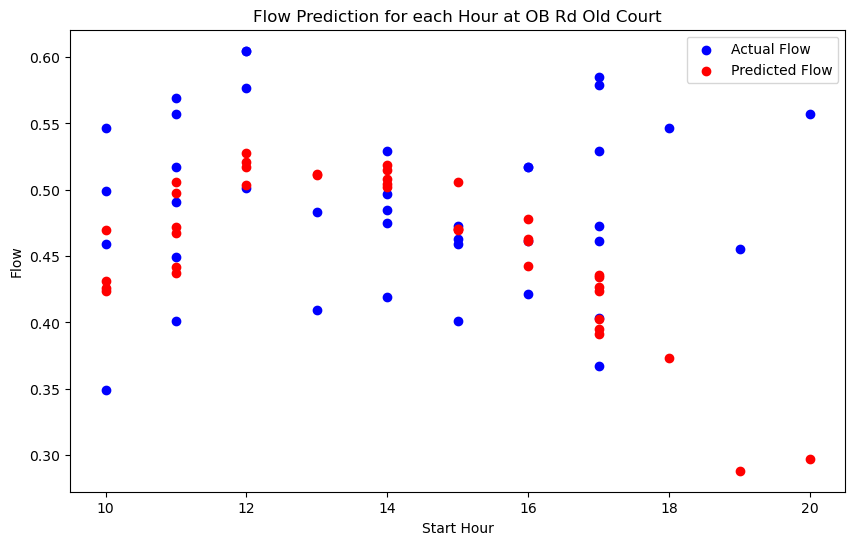

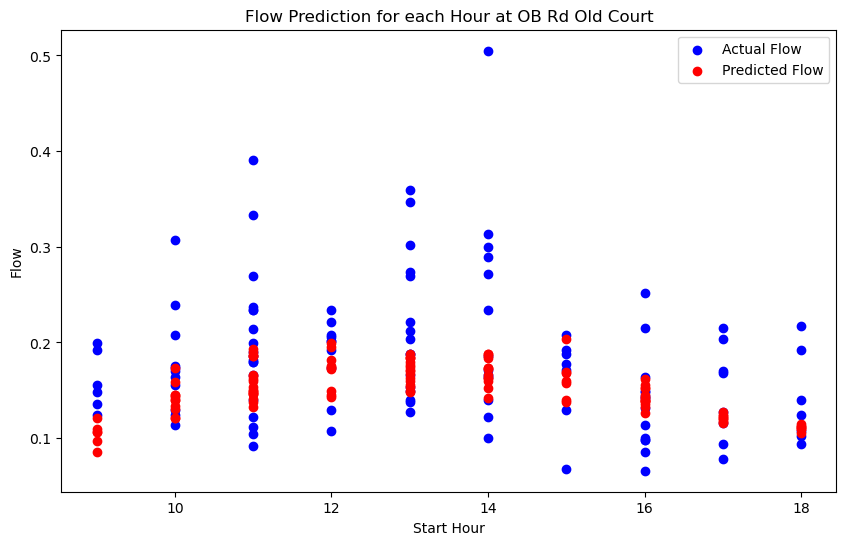

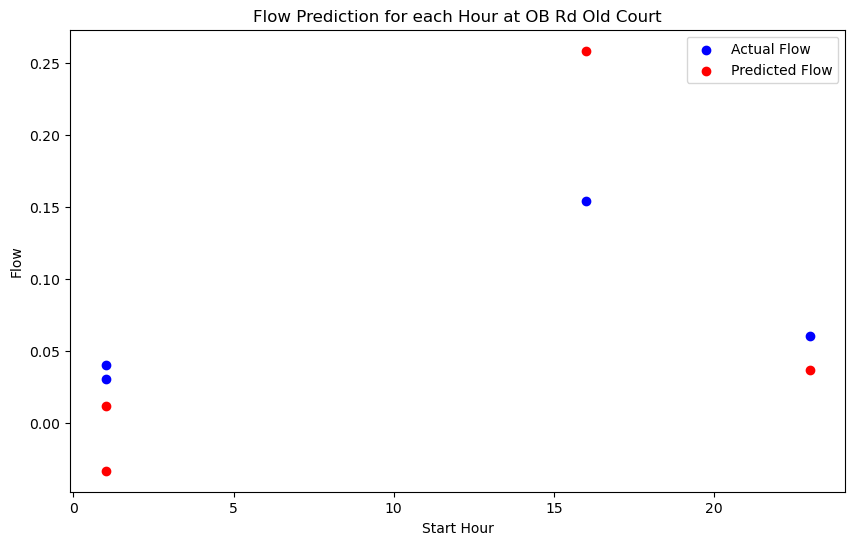

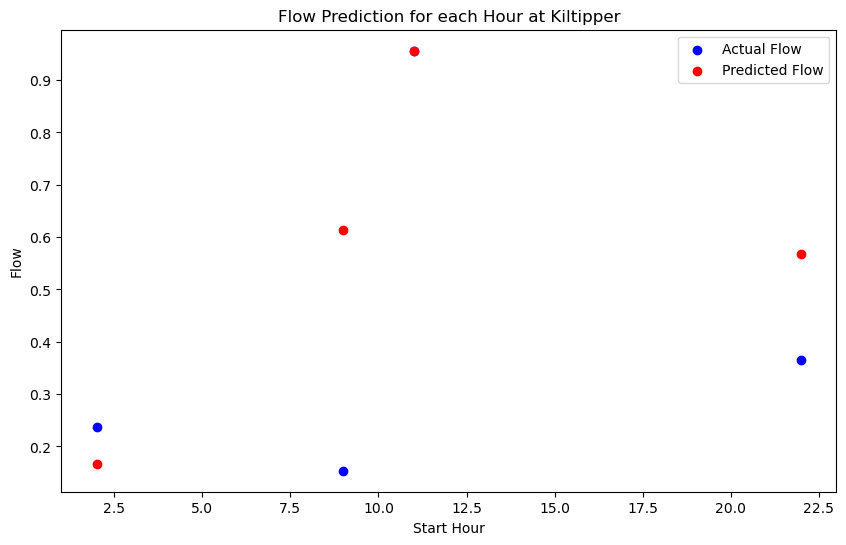

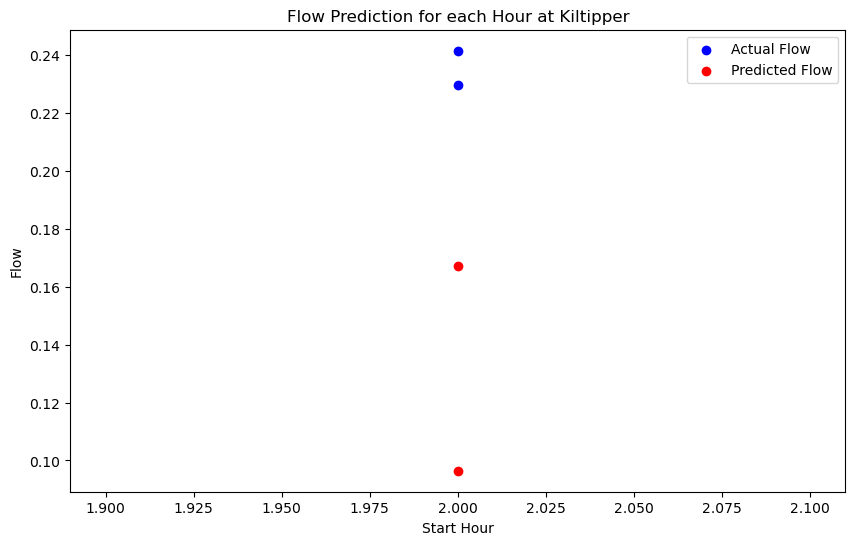

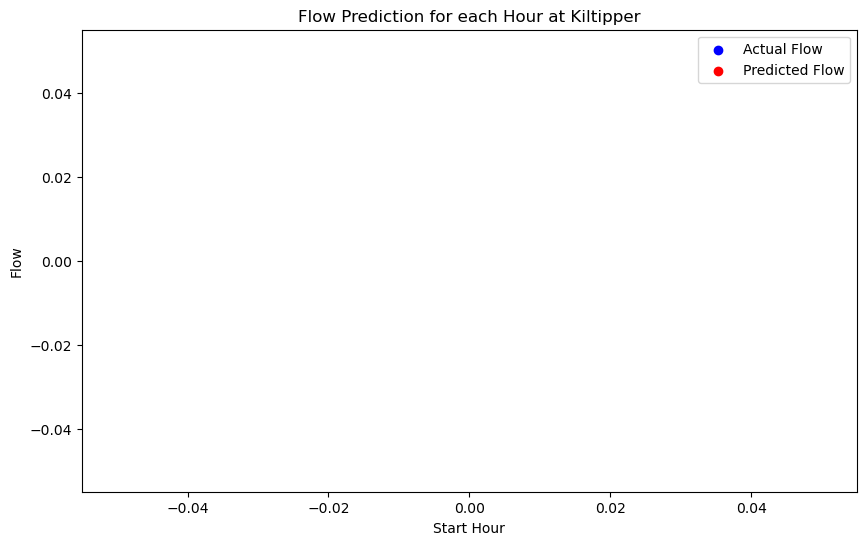

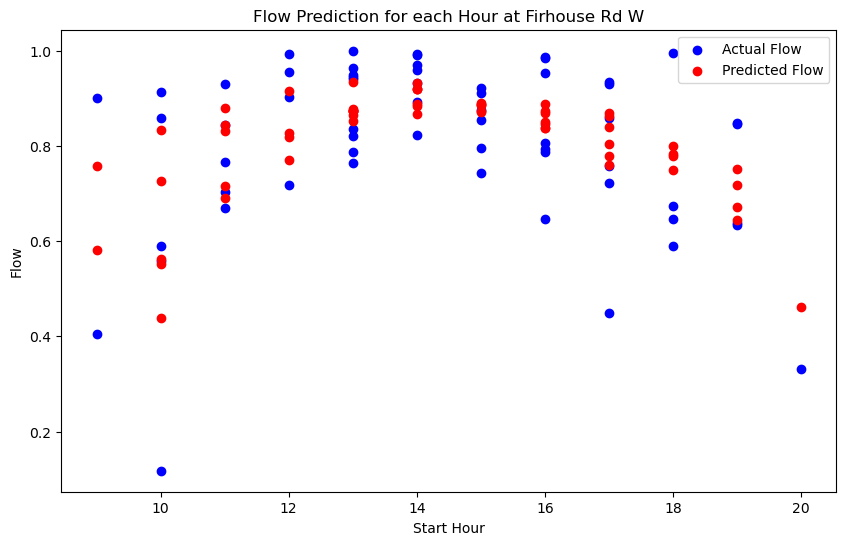

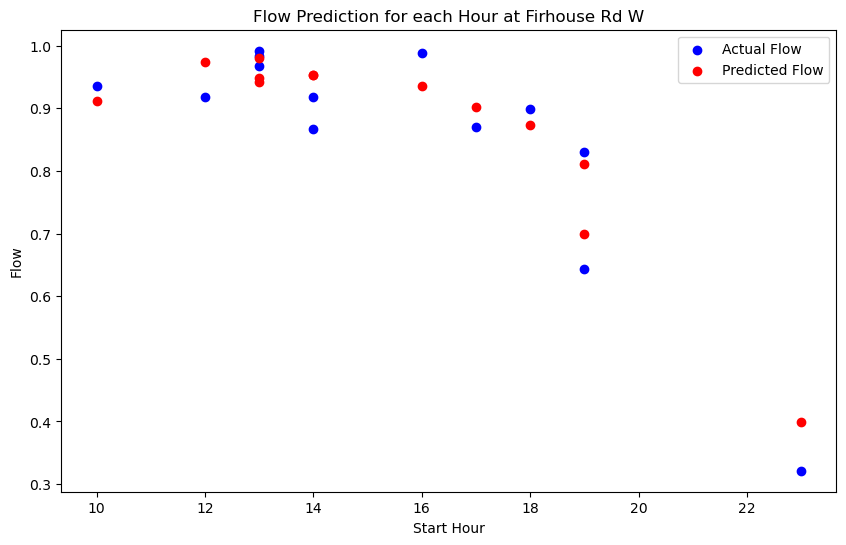

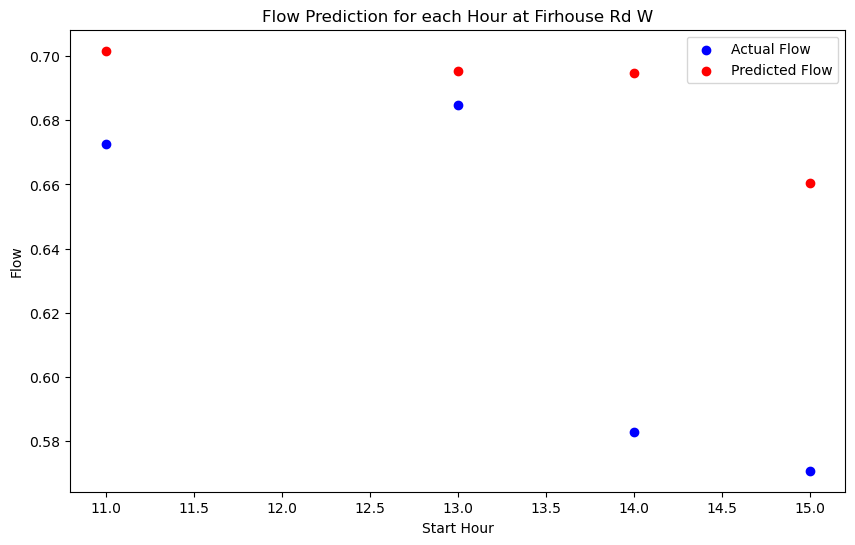

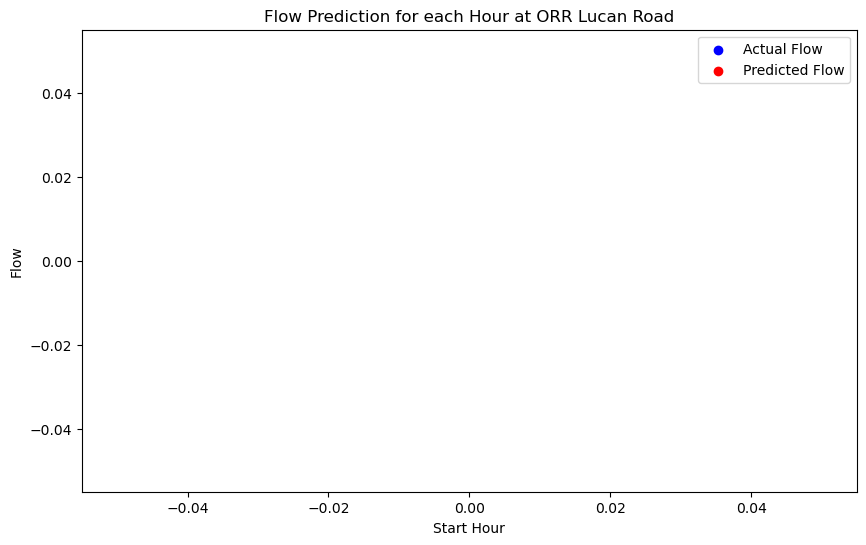

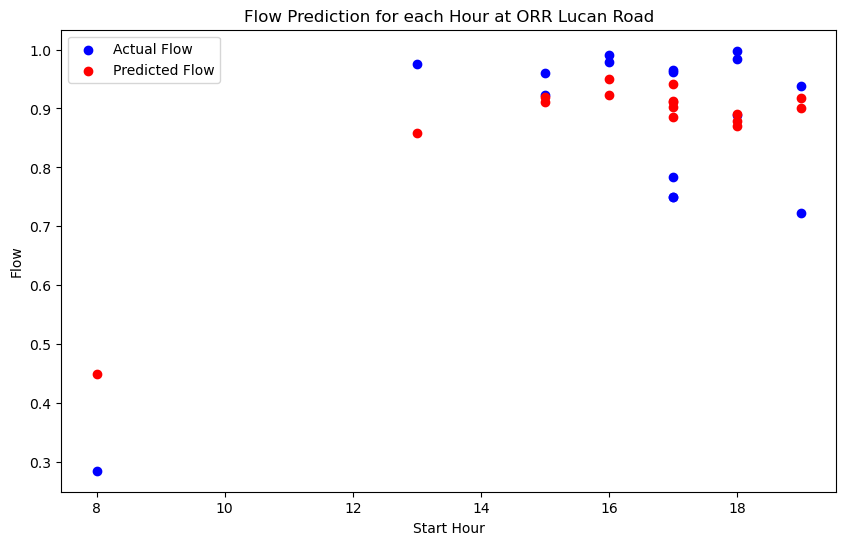

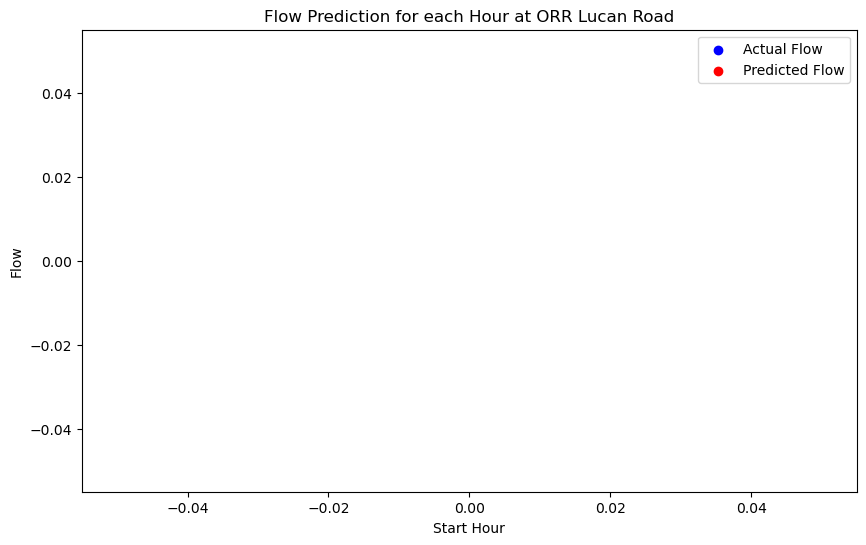

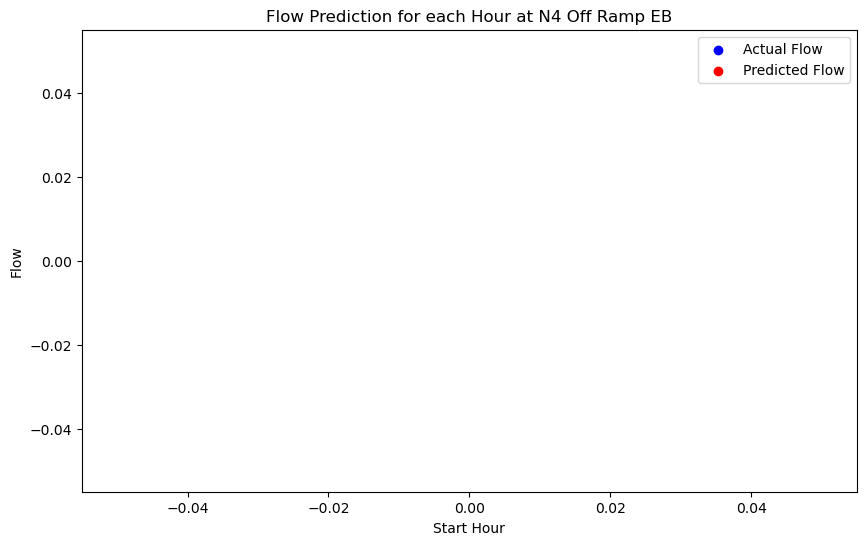

In [30]:
# Scatter Plot

for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), y_test_site_sorted['flow'], label='Actual Flow', color='blue')
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), predictions_site_sorted[:, 0], label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()

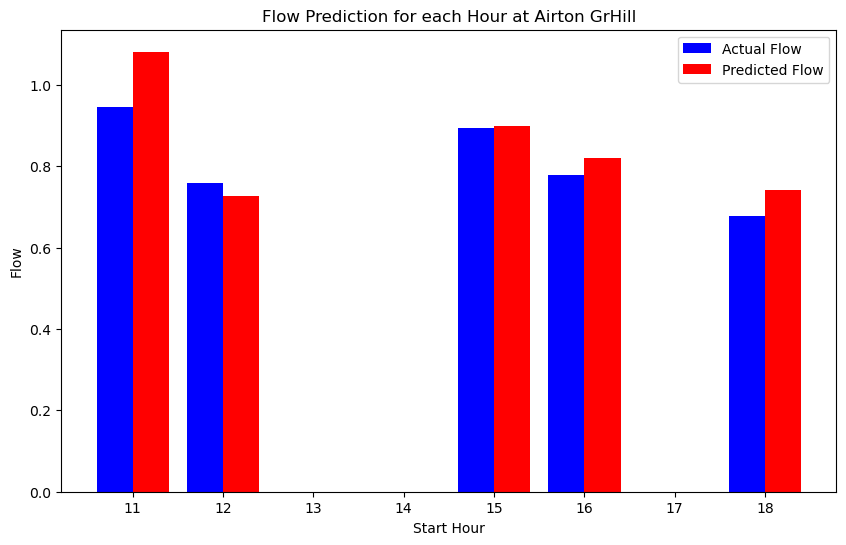

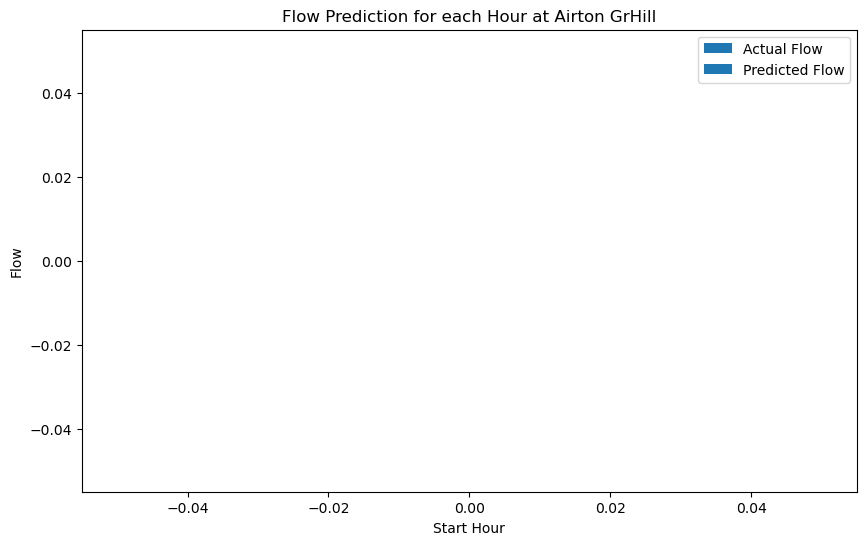

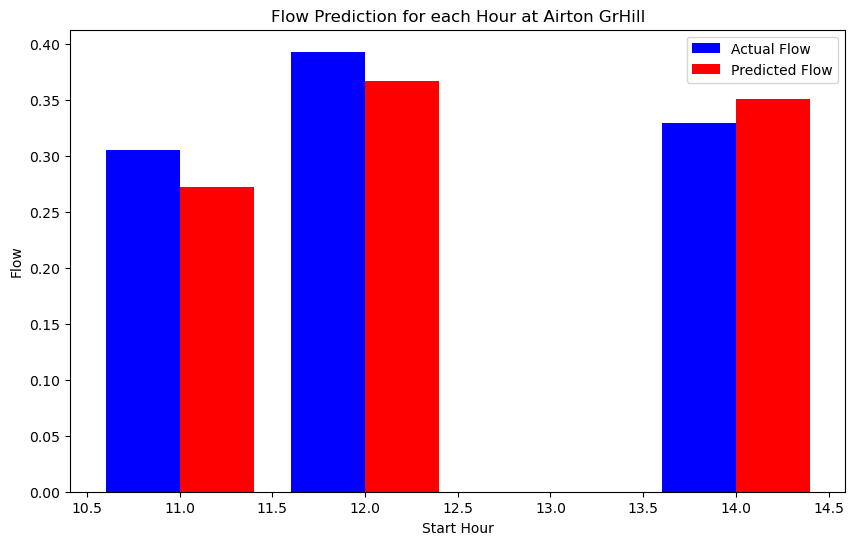

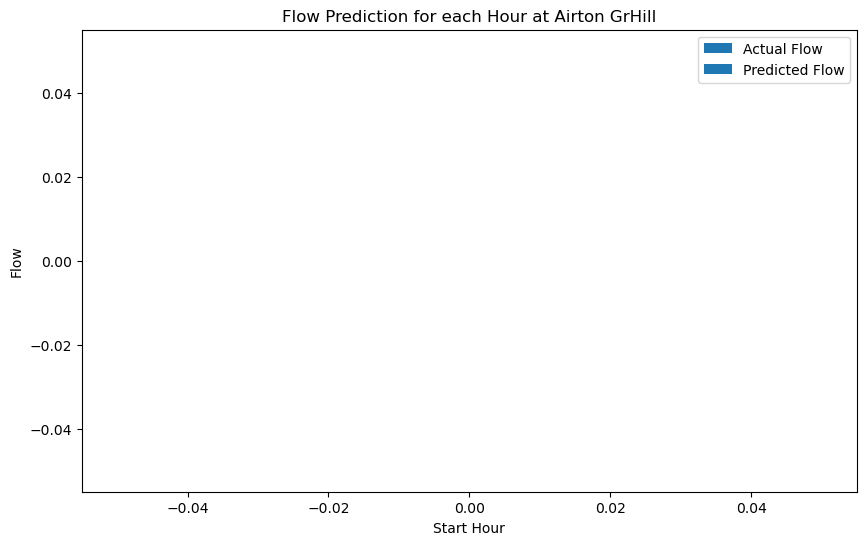

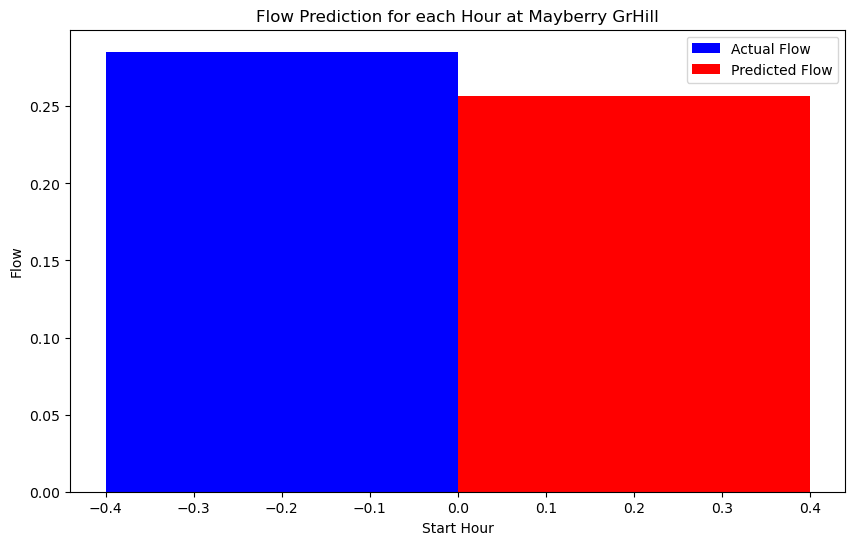

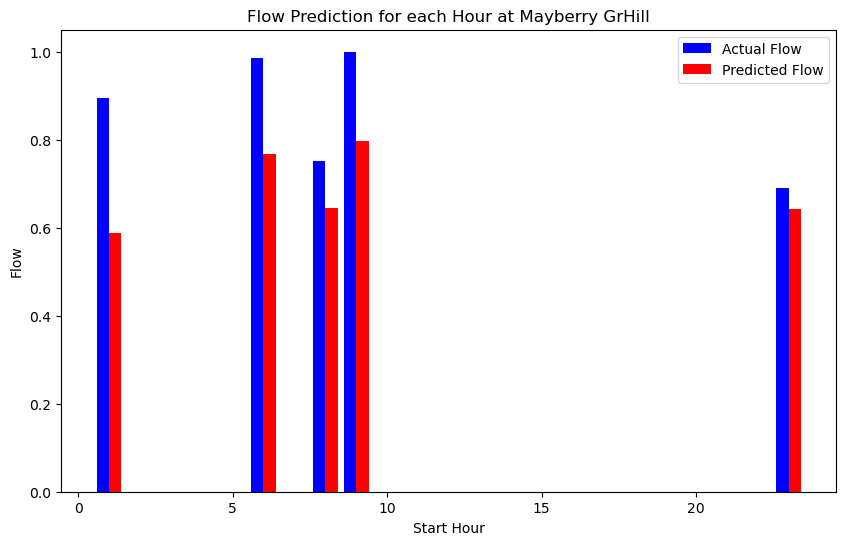

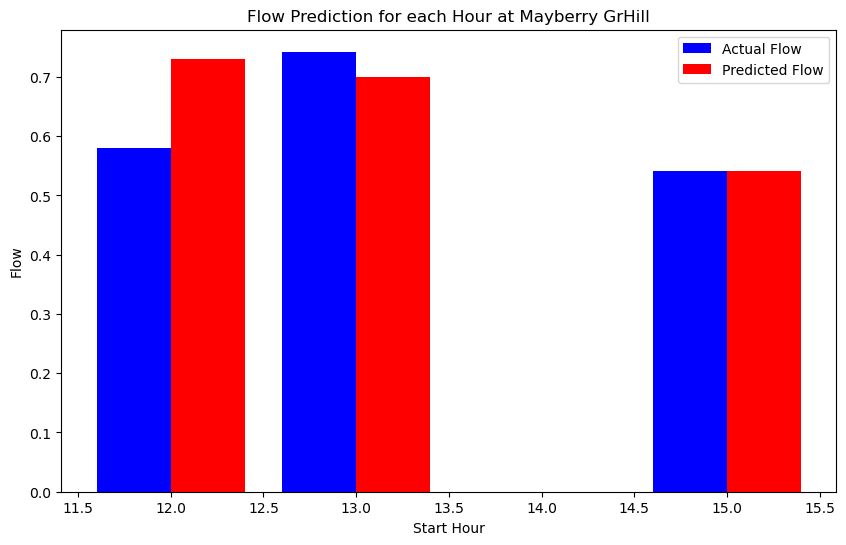

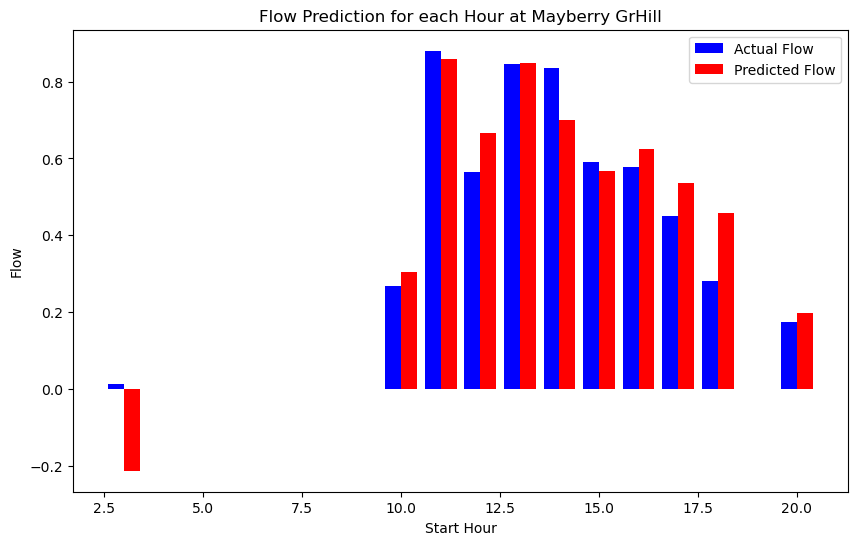

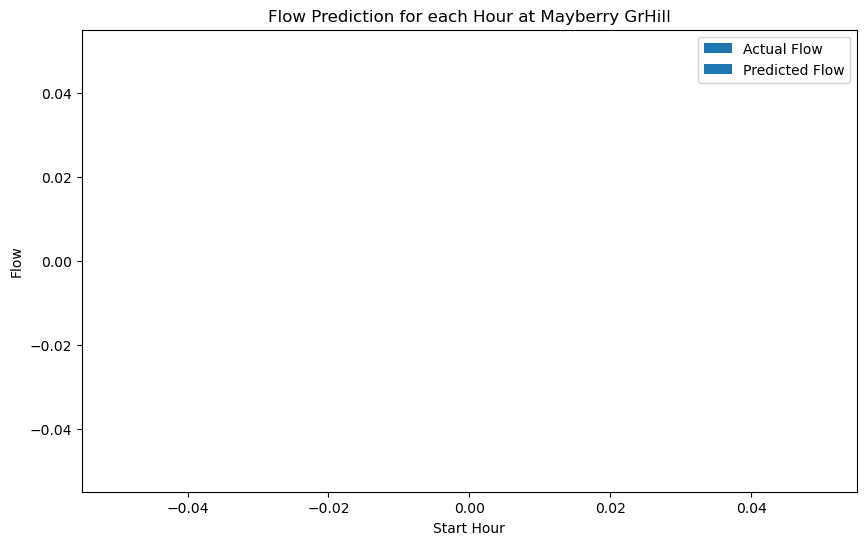

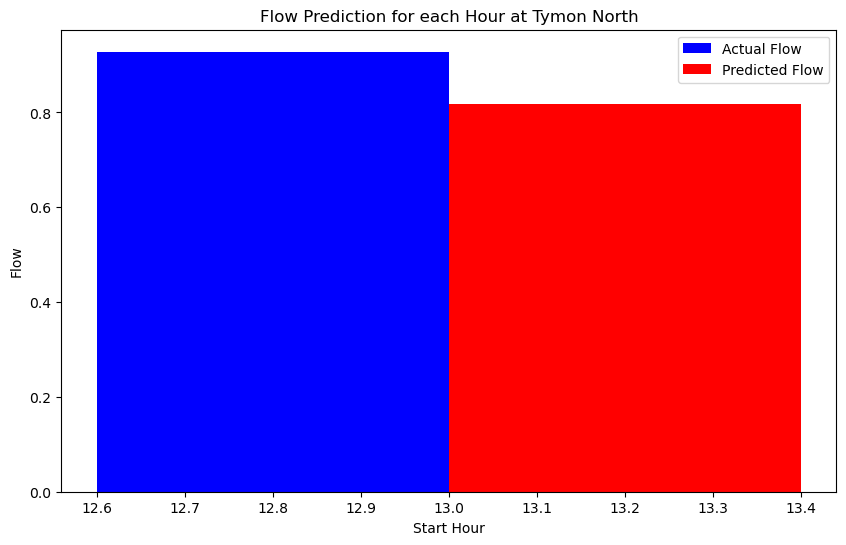

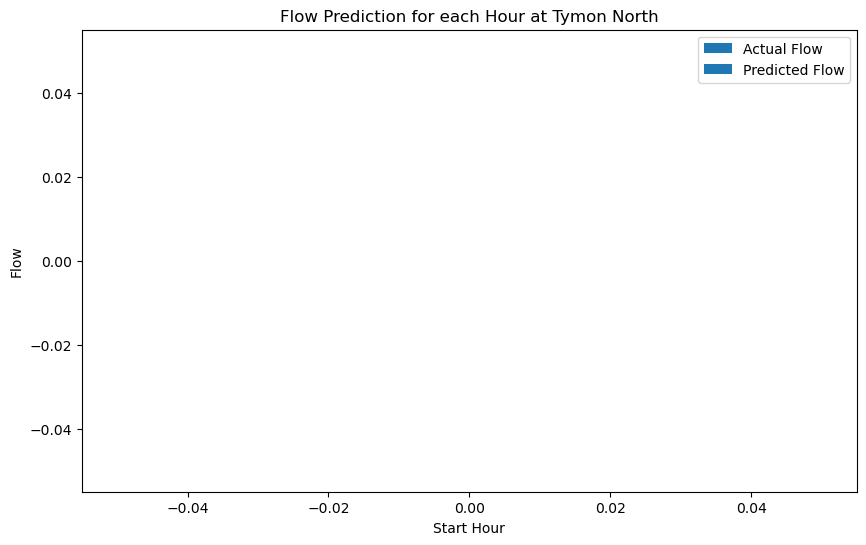

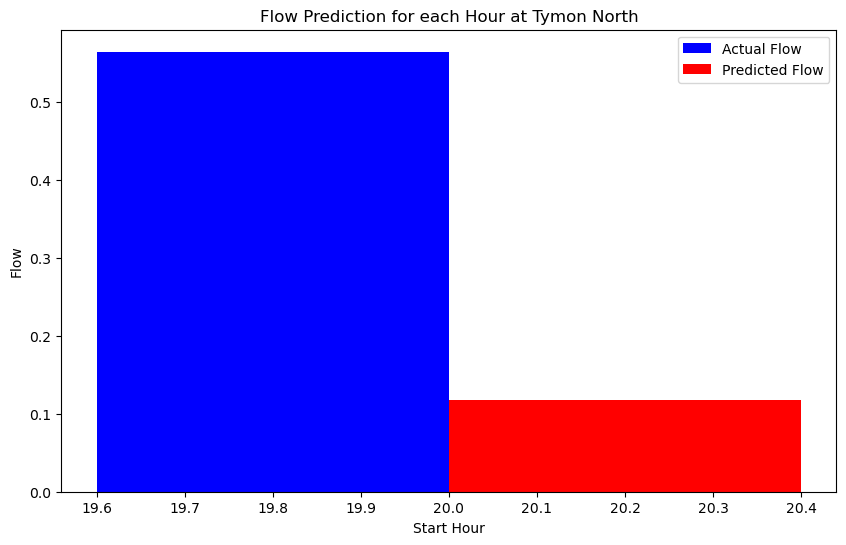

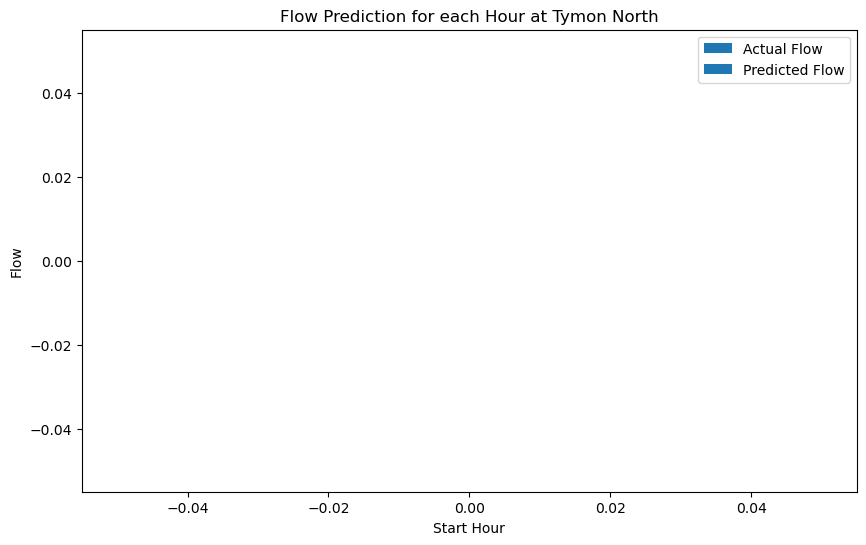

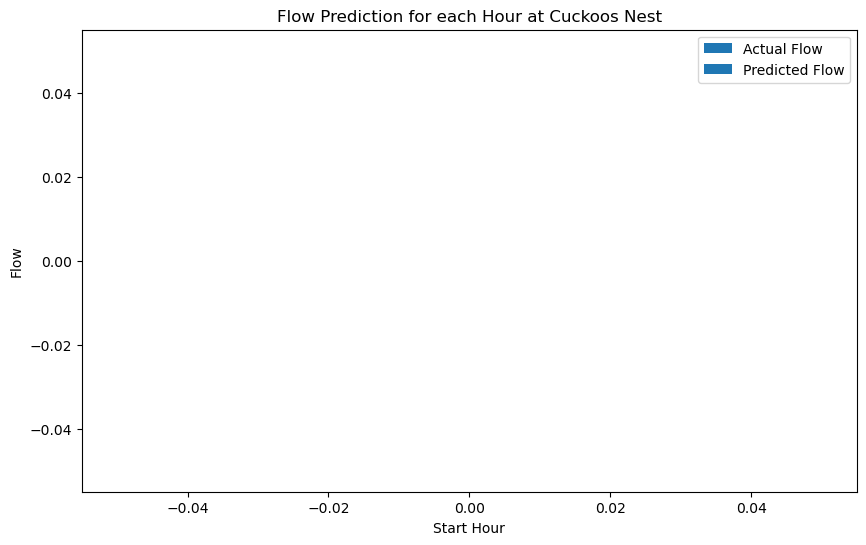

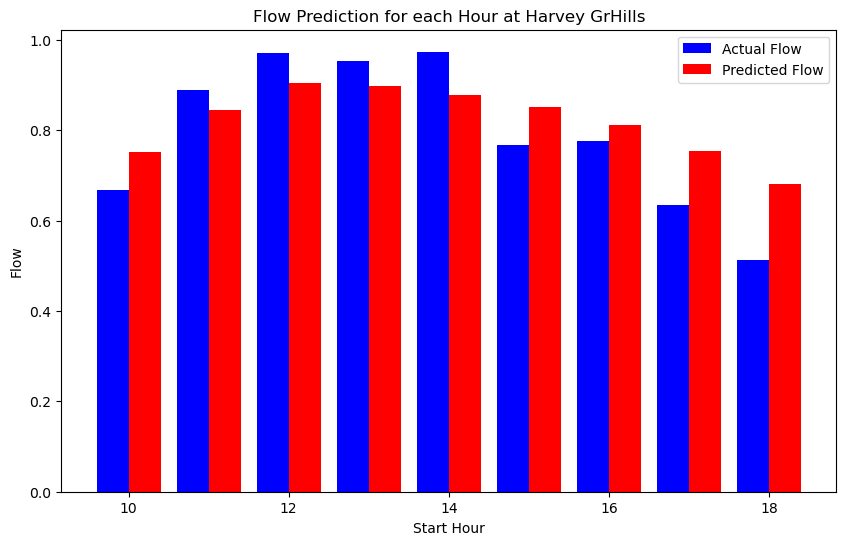

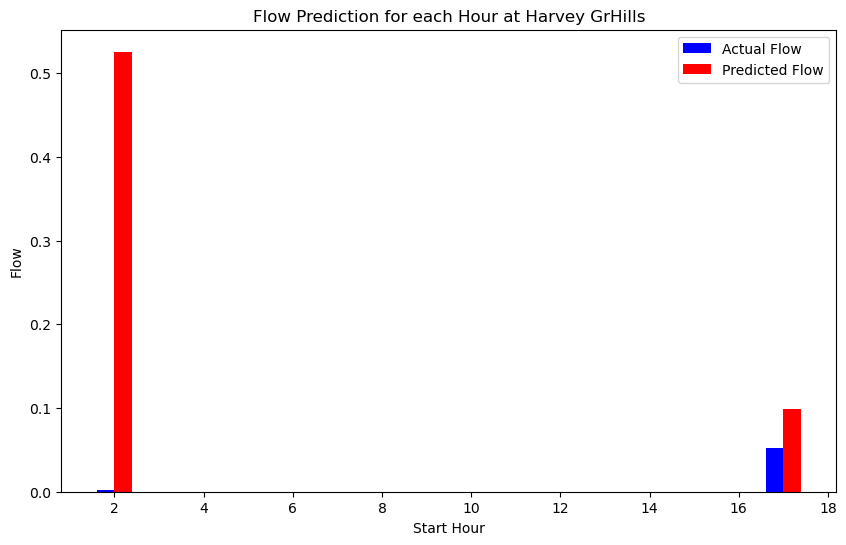

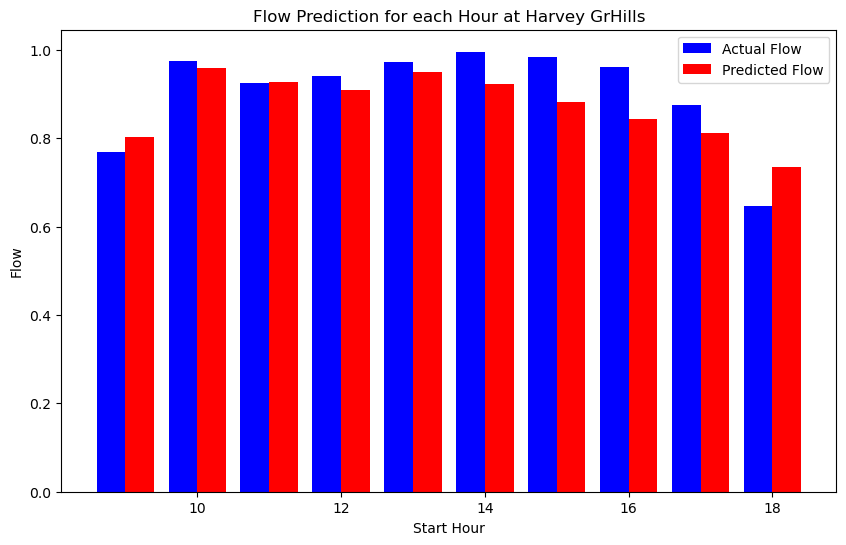

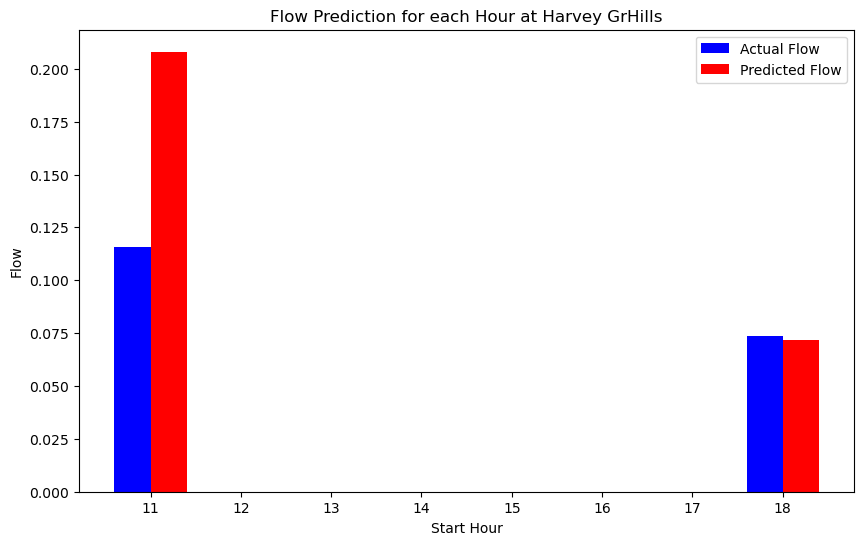

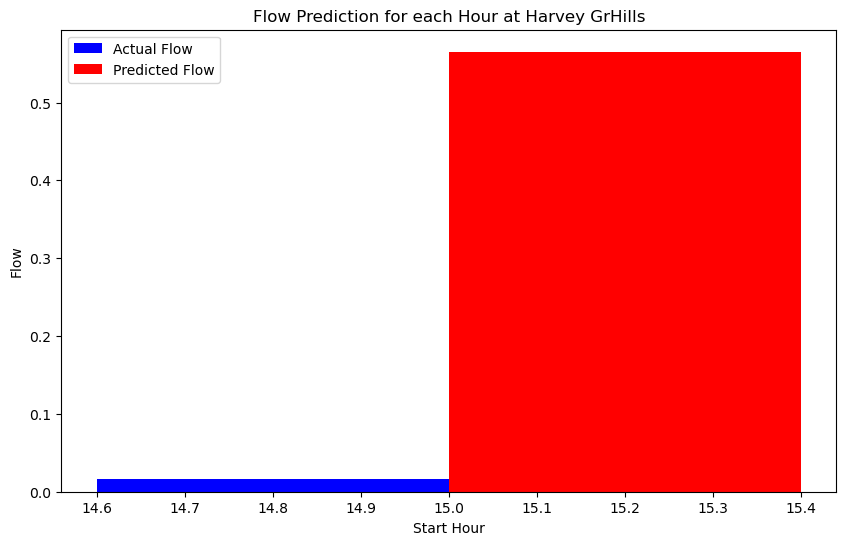

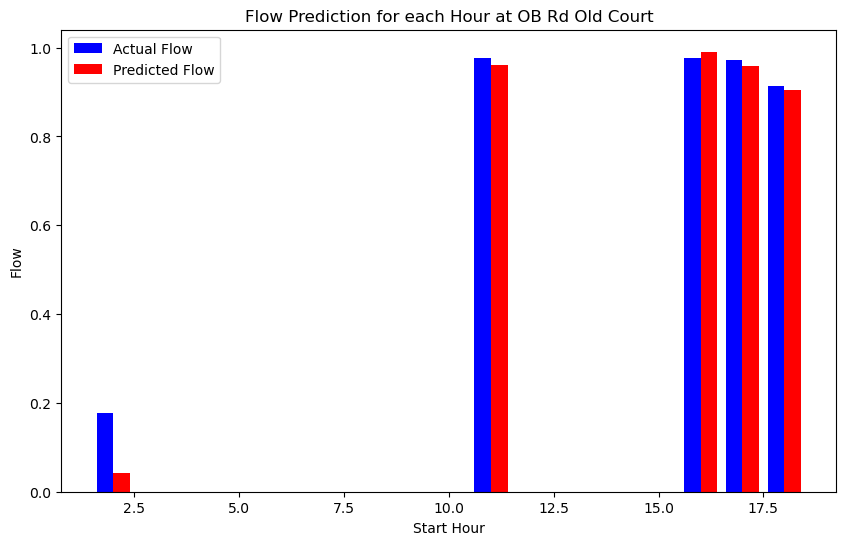

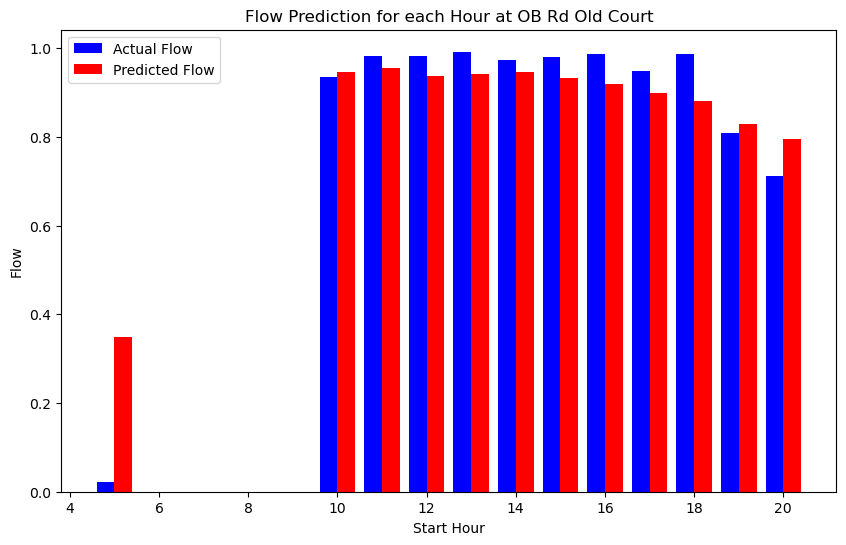

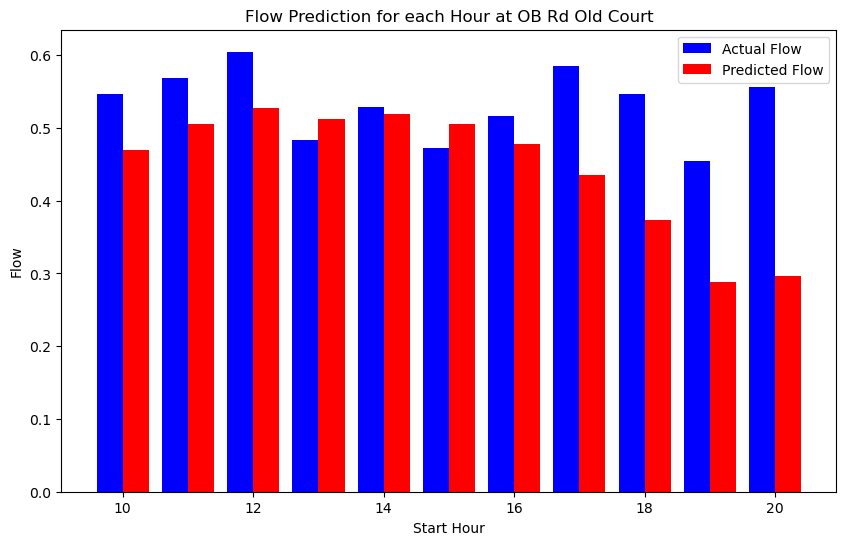

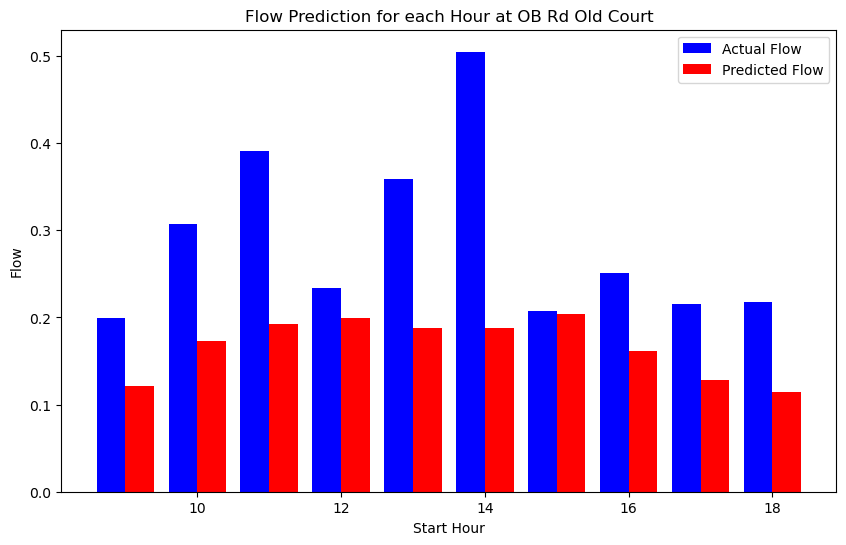

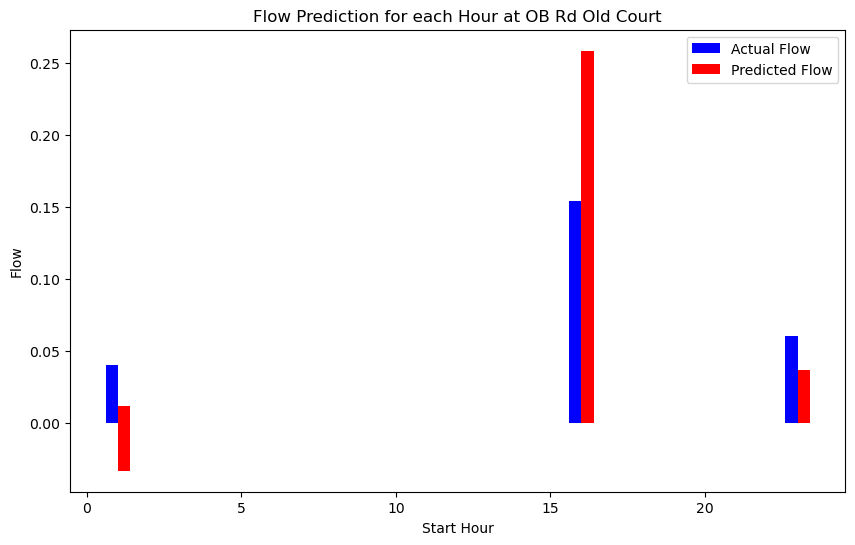

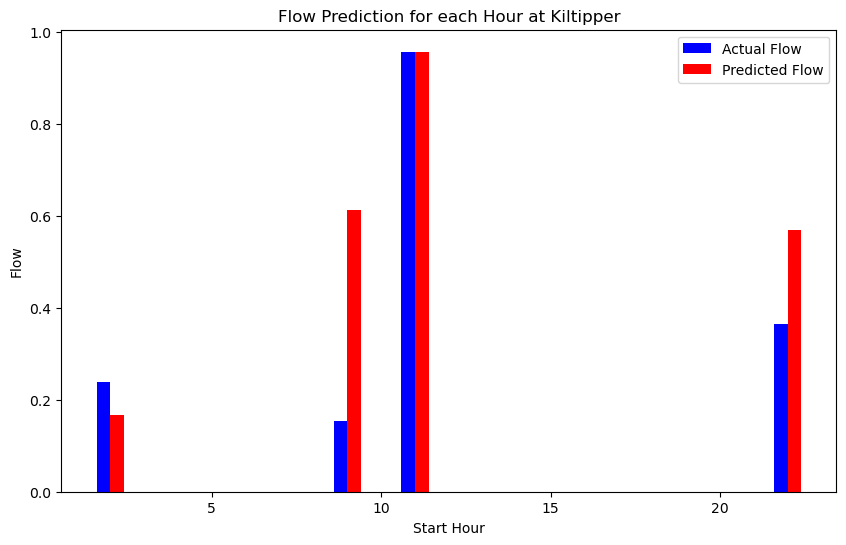

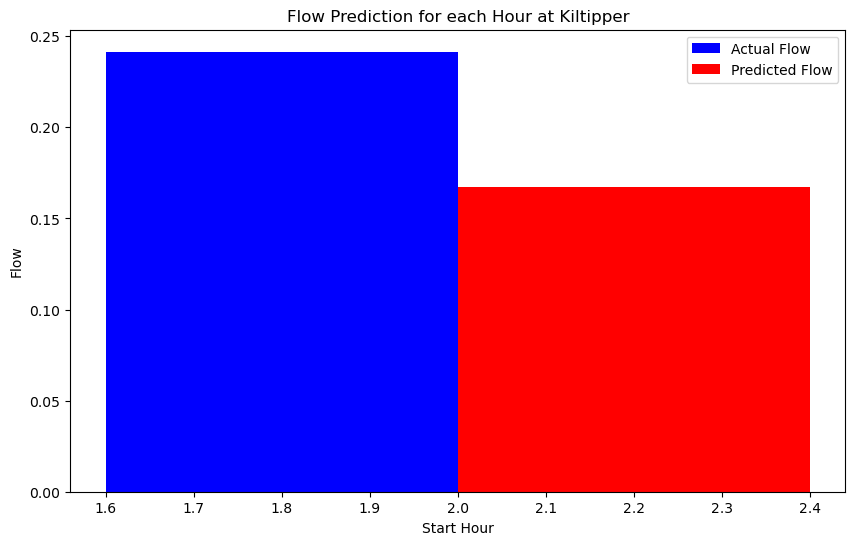

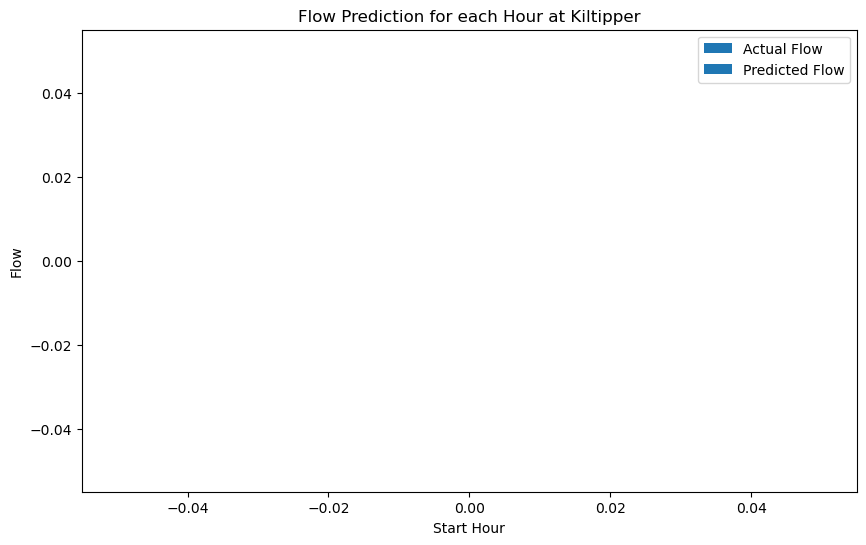

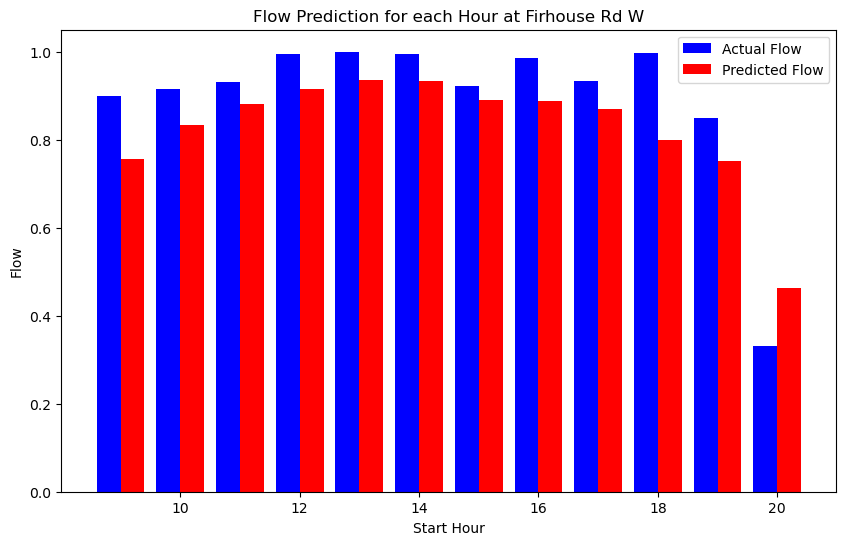

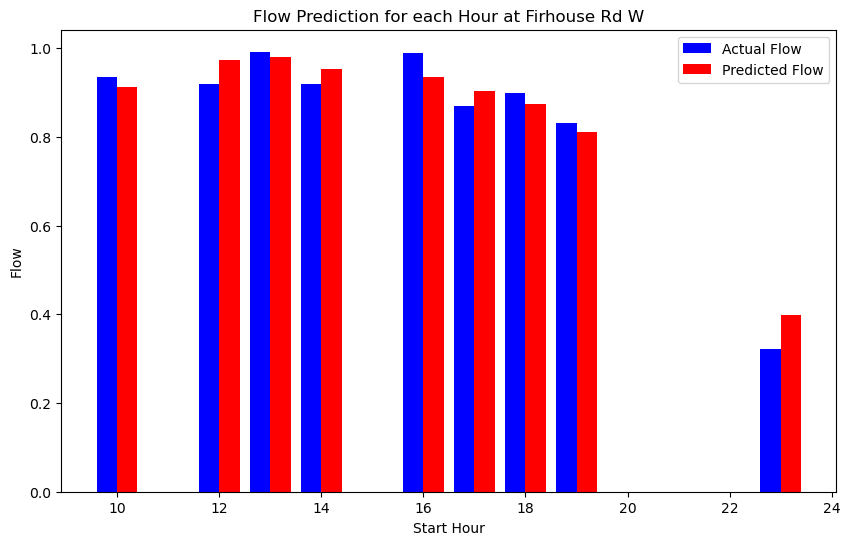

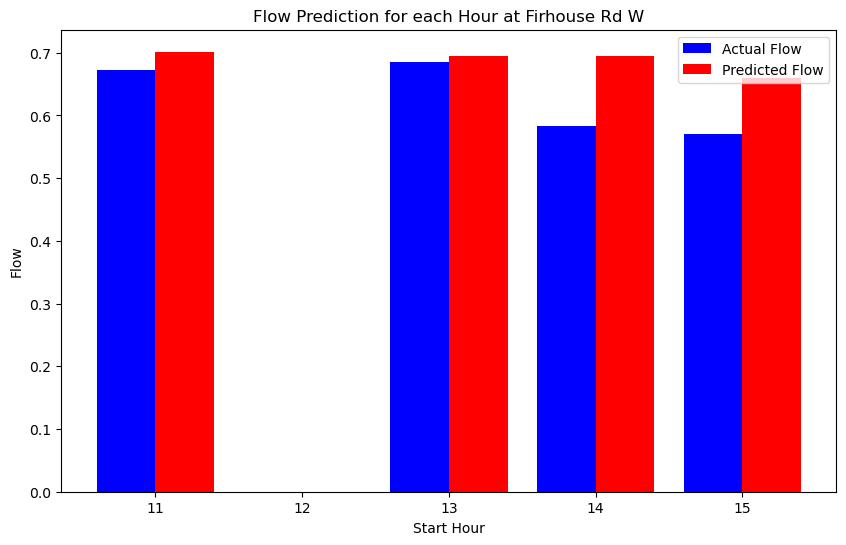

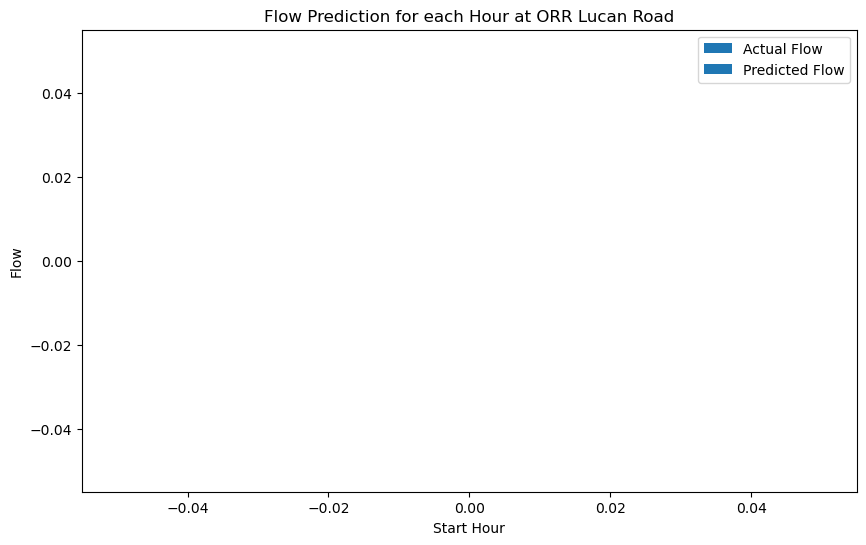

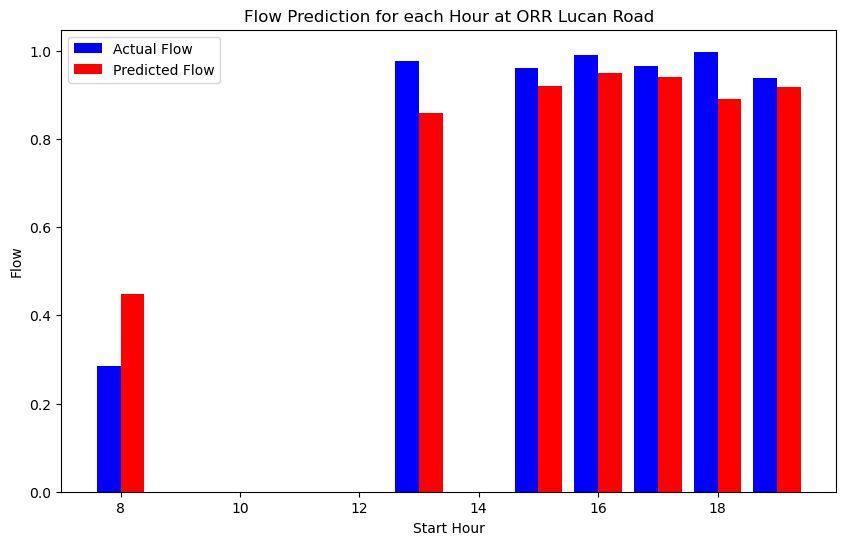

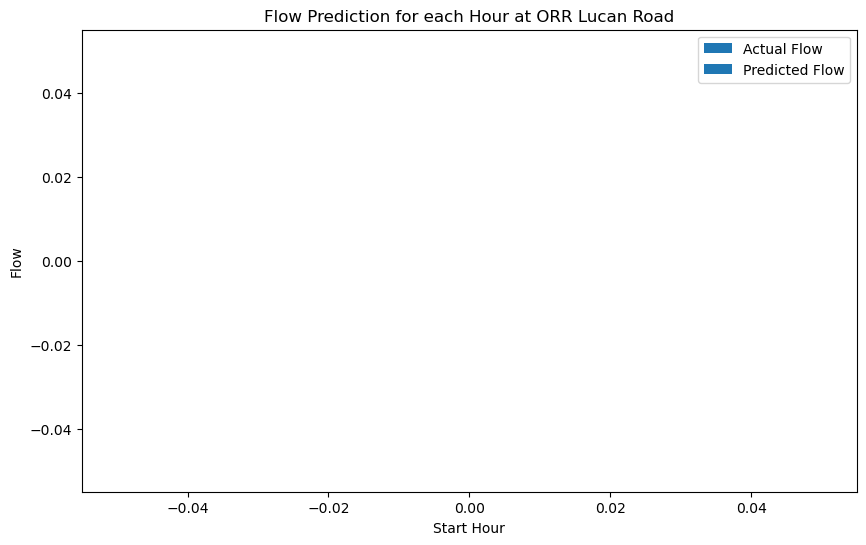

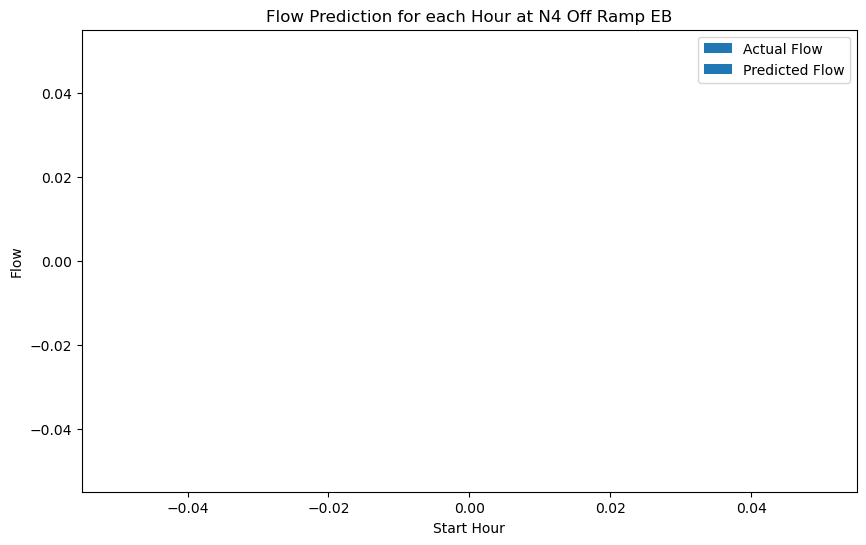

In [31]:
# Bar Chart
for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) - 0.2, y_test_site_sorted['flow'], width=0.4, label='Actual Flow', color='blue')
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) + 0.2, predictions_site_sorted[:, 0], width=0.4, label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()